In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_step
%store -r Y_motion_step
print(X_motion_step.shape)
print(Y_motion_step.shape)

(148884, 37)
(148884, 8)


In [6]:
%store -r model_fl_x
%store -r model_fl_y
%store -r model_fr_x
%store -r model_fr_y
%store -r model_rl_x
%store -r model_rl_y
%store -r model_rr_x
%store -r model_rr_y
%store -r model_fl_com_x
%store -r model_fl_com_y
%store -r model_fr_com_x
%store -r model_fr_com_y

In [7]:
X_motion_step[:100, 26]

array([0.        , 0.        , 0.07464571, 0.        , 0.06010439,
       0.        , 0.06078163, 0.        , 0.05450465, 0.        ,
       0.06848326, 0.        , 0.09516867, 0.        , 0.08363788,
       0.        , 0.0862579 , 0.        , 0.08774815, 0.        ,
       0.052808  , 0.        , 0.0544083 , 0.        , 0.05372943,
       0.        , 0.06195404, 0.        , 0.0687784 , 0.        ,
       0.08469264, 0.        , 0.08332793, 0.        , 0.09989096,
       0.        , 0.09243038, 0.        , 0.05933575, 0.        ,
       0.05358246, 0.        , 0.05847915, 0.        , 0.05842283,
       0.        , 0.05954041, 0.        , 0.08378454, 0.        ,
       0.09065428, 0.        , 0.08591603, 0.        , 0.0970754 ,
       0.        , 0.07003787, 0.        , 0.05217314, 0.        ,
       0.05968502, 0.        , 0.06025758, 0.        , 0.05286194,
       0.        , 0.08810744, 0.        , 0.09398463, 0.        ,
       0.0959523 , 0.        , 0.08868574, 0.        , 0.07720

# Foot prediction test

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict

## Test Foot Models

In [9]:
X_motion_step[1, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.35253631e-02, -5.45018454e-03,
        1.90322078e-37, -5.57888703e-24, -4.46281599e-23,  9.45164094e-02,
        1.59093827e-01,  1.32301375e-01, -3.42030436e-01,  2.06204250e-01,
       -1.36616319e-01, -3.38554084e-01, -2.68098682e-01,  1.39270037e-01,
       -3.41048896e-01, -2.74800837e-01, -1.31081313e-01, -3.37453157e-01,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.58638060e-02, -4.57940996e-03,  2.44542360e-02,  1.46174431e-03,
        0.00000000e+00,  0.00000000e+00,  1.09132966e-01,  3.01721154e-03,
        3.34074736e-01])

In [10]:
Y_motion_step[1, :]

array([ 0.07464571, -0.00153224,  0.        ,  0.        ,  0.        ,
        0.        ,  0.03709272, -0.01009694])

In [10]:
min(Y_motion_step[np.where(X_motion_step[:, 1] > 0)[0], 5])

0.0

In [11]:
Y_motion_step[np.where(X_motion_step[:, 24] == 1)[0][:20], 3]

array([-0.00457941,  0.0040237 ,  0.00552526,  0.00480825,  0.00888479,
        0.00985001,  0.00600404,  0.00918202,  0.00653468,  0.00955936,
        0.009455  ,  0.00937624,  0.00945383,  0.00561441,  0.01031588,
        0.01084518,  0.00587085,  0.00323692,  0.00665227,  0.00956017])

In [20]:
Y_motion_step[:10]

array([[ 0.        ,  0.        ,  0.01586381, -0.00457941,  0.02445424,
         0.00146174,  0.        ,  0.        ],
       [ 0.07464571, -0.00153224,  0.        ,  0.        ,  0.        ,
         0.        ,  0.03709272, -0.01009694],
       [ 0.        ,  0.        ,  0.05948897,  0.0040237 ,  0.05842423,
         0.00554843,  0.        ,  0.        ],
       [ 0.06010439, -0.00485645,  0.        ,  0.        ,  0.        ,
         0.        ,  0.05468392, -0.00500219],
       [ 0.        ,  0.        ,  0.05894744,  0.00552526,  0.05314526,
         0.00387365,  0.        ,  0.        ],
       [ 0.06078163, -0.00433466,  0.        ,  0.        ,  0.        ,
         0.        ,  0.05656737, -0.00456366],
       [ 0.        ,  0.        ,  0.06044418,  0.00480825,  0.05624932,
         0.00392984,  0.        ,  0.        ],
       [ 0.05450465, -0.00735374,  0.        ,  0.        ,  0.        ,
         0.        ,  0.0481399 , -0.00227286],
       [ 0.        ,  0.        

In [21]:
#for x in lol:
    #print(Y_motion_step[x])
    #print(FR_X_LABEL[lol,0], FR_Y_LABEL[lol,0])

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07454862 -0.0114148 ]


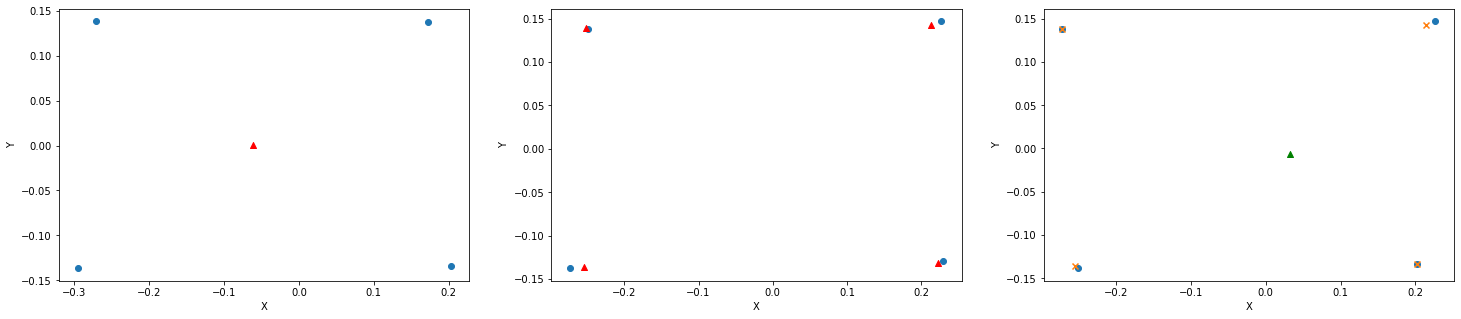

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07447282 -0.01167507]


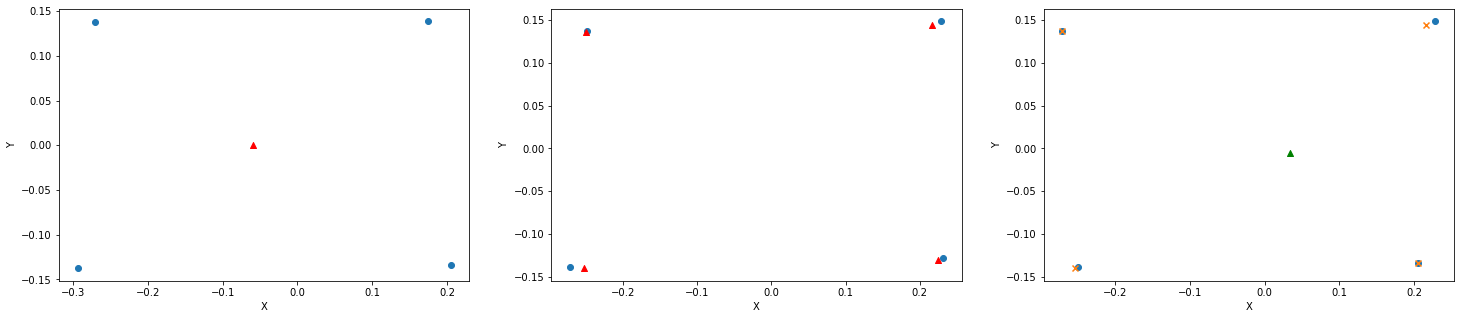

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.01441291 0.02796383]


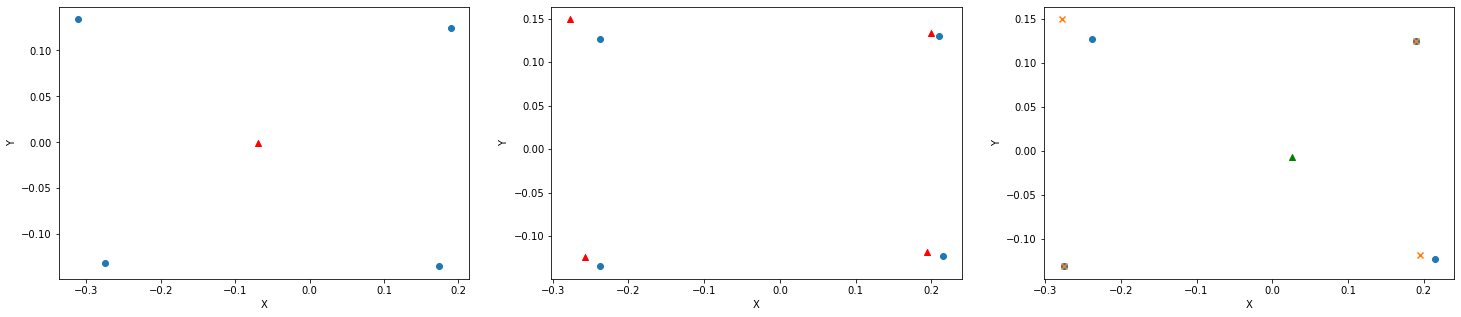

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.10460736 -0.00363014]


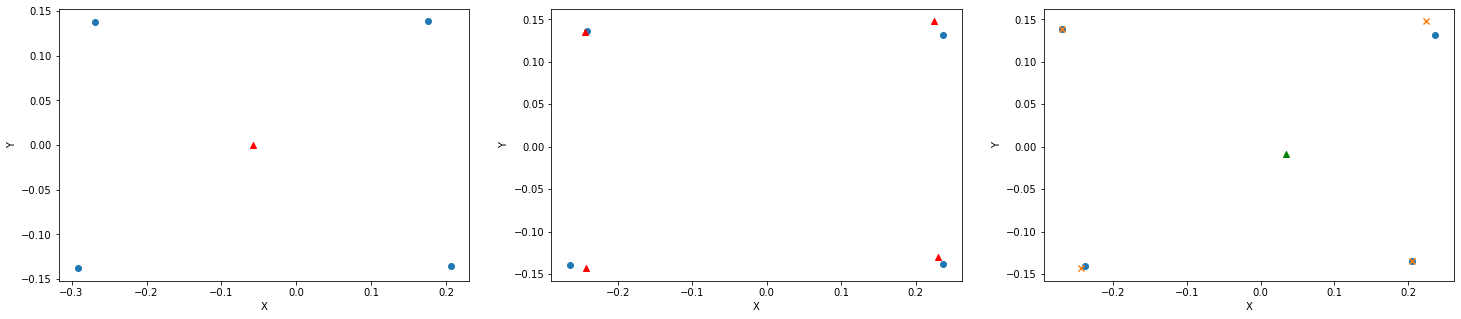

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08562568 0.0142081 ]


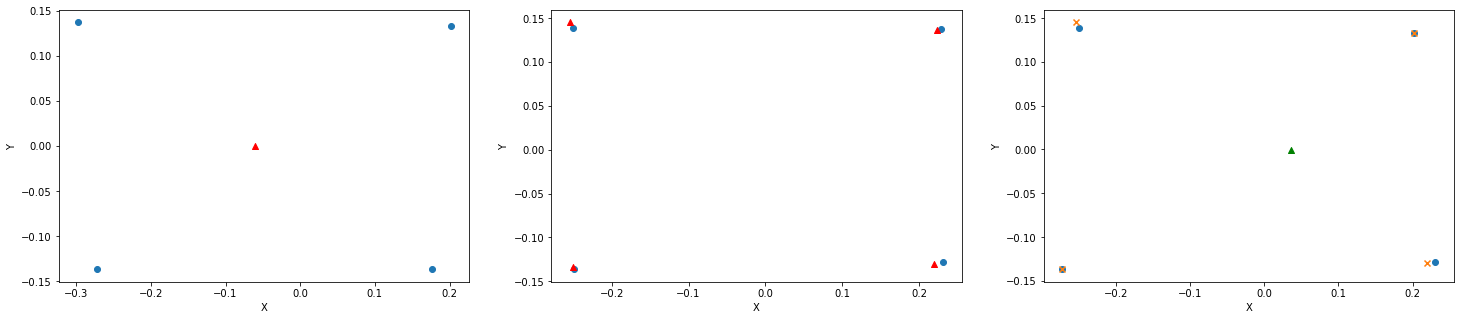

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07608426 -0.01828453]


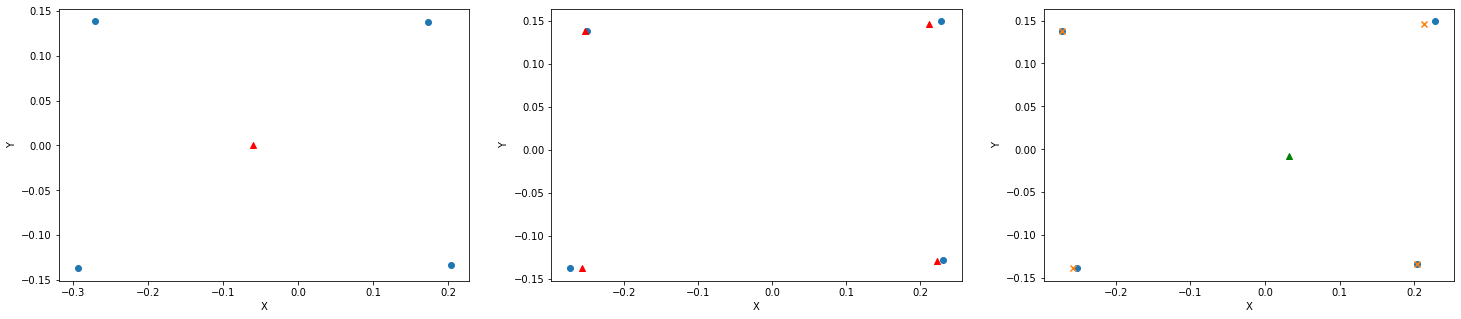

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08662861 0.01732916]


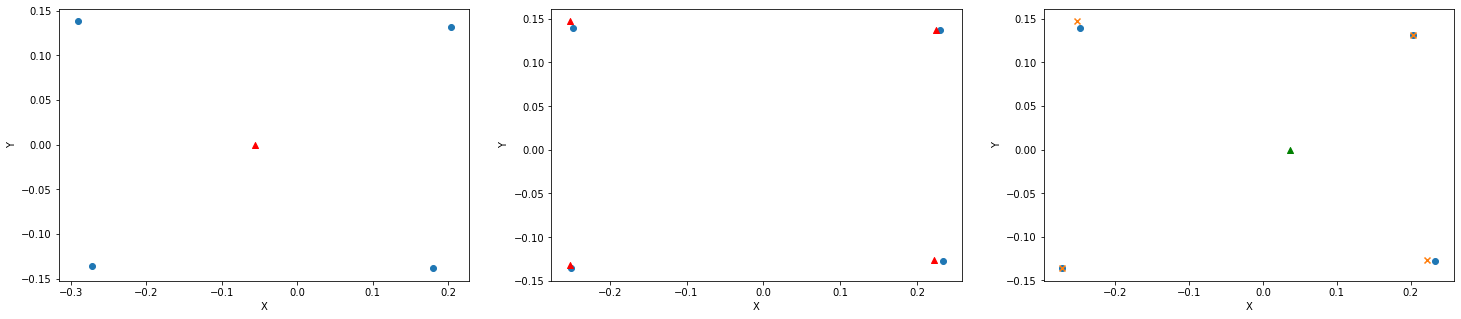

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08649419 0.03380938]


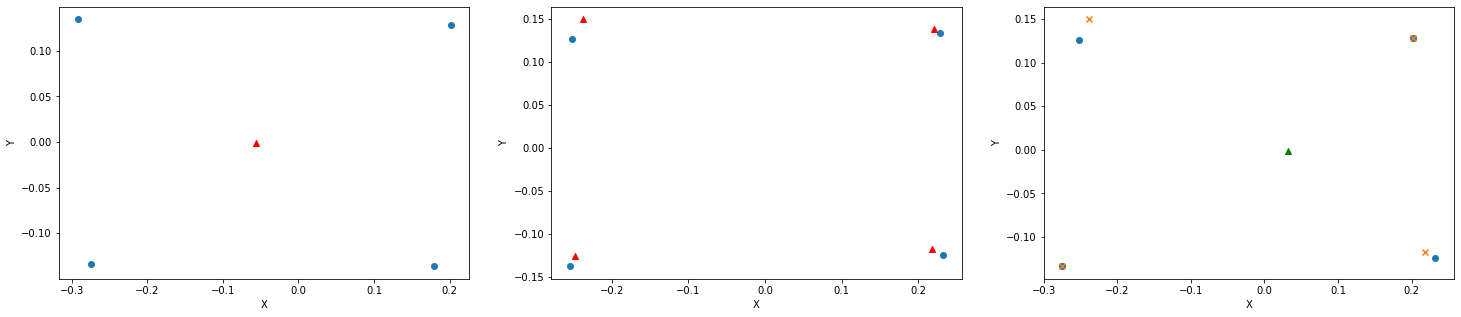

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08921367 0.00650882]


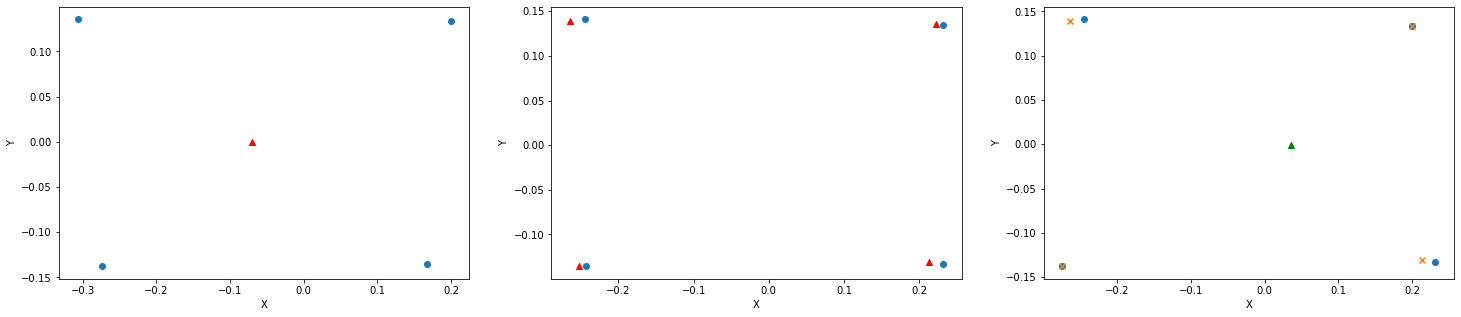

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.0997914  -0.00178602]


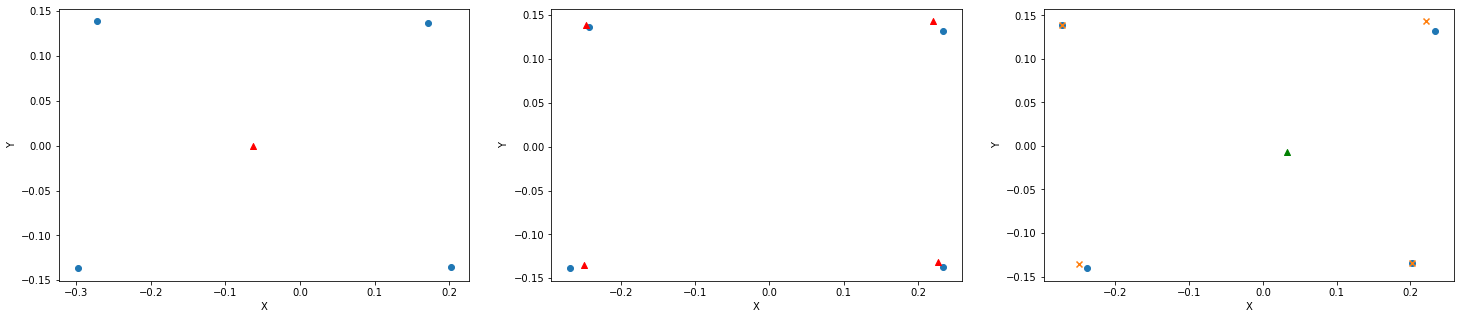

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08859178 0.01541259]


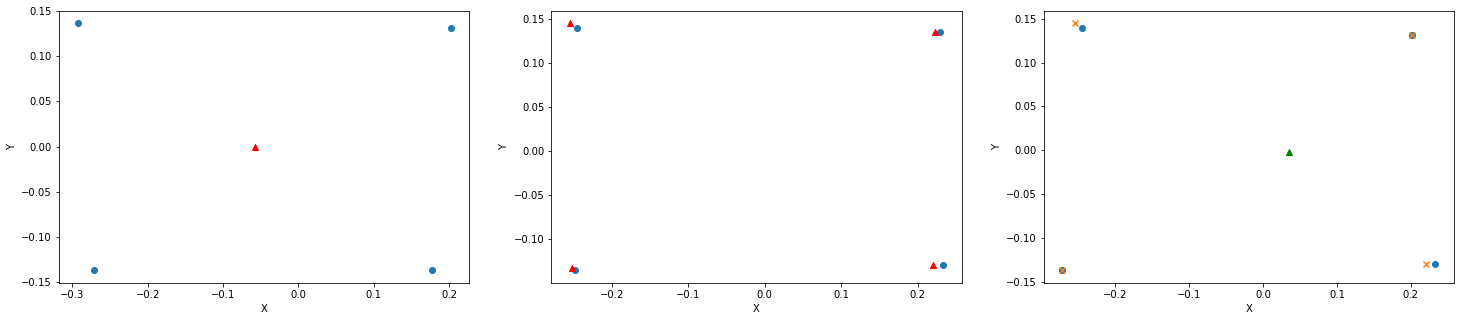

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08332607 0.01703869]


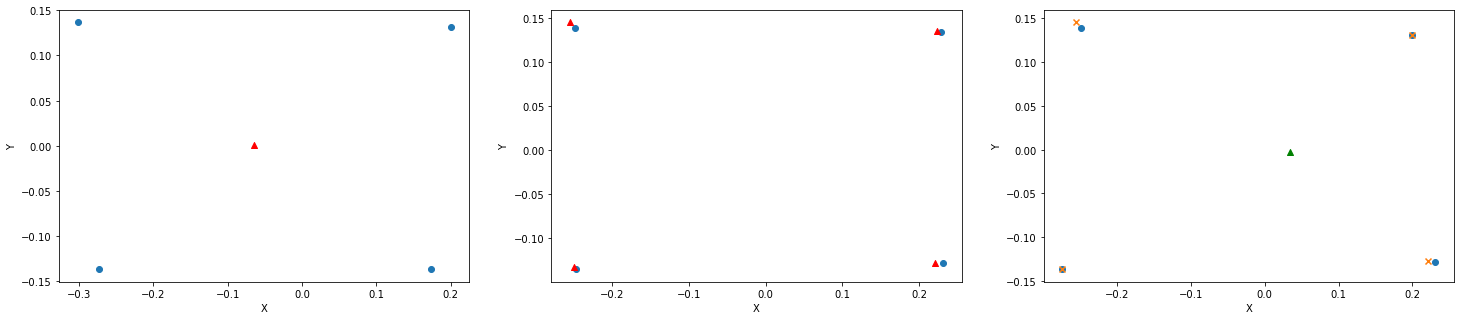

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08800633 -0.00253003]


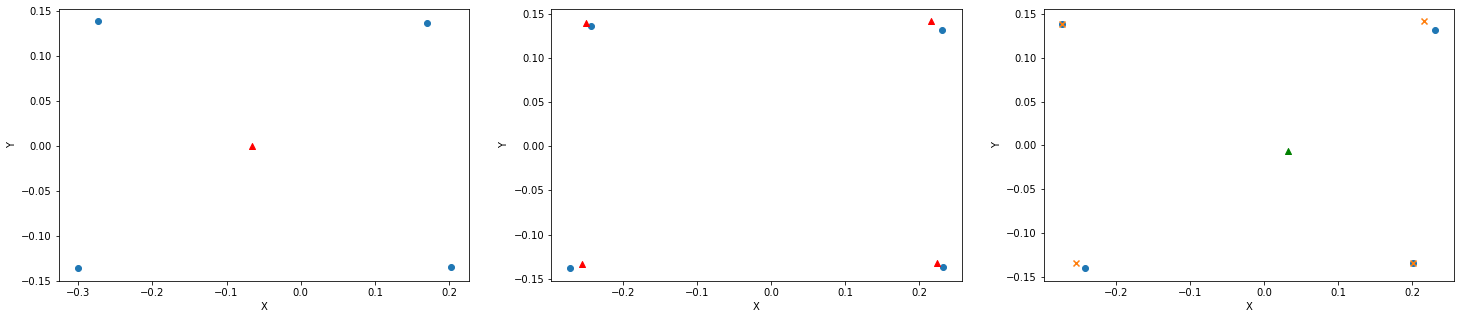

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.05013273 0.01092009]


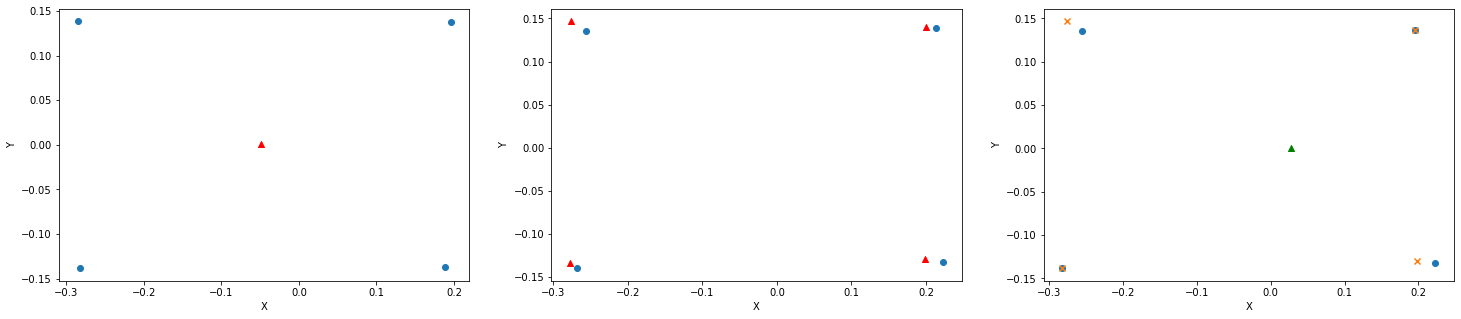

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08557391 -0.00950168]


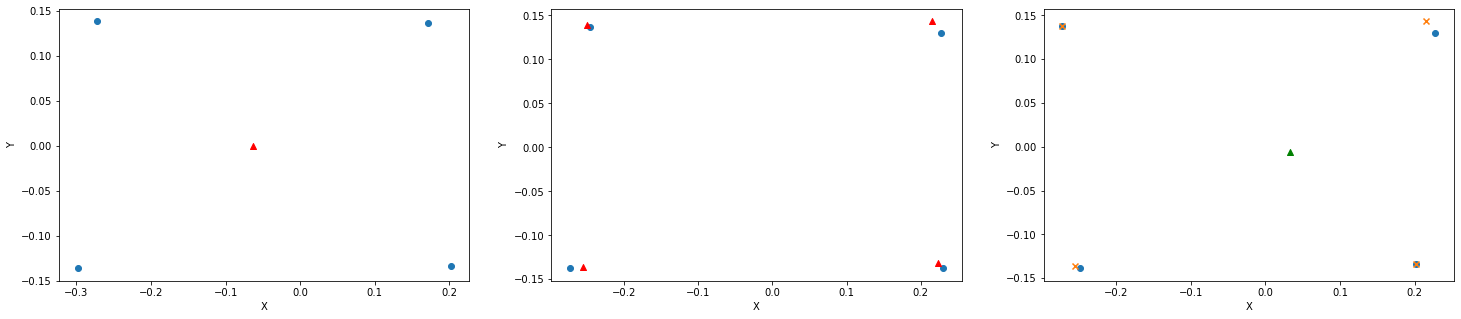

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.10286337 -0.00297804]


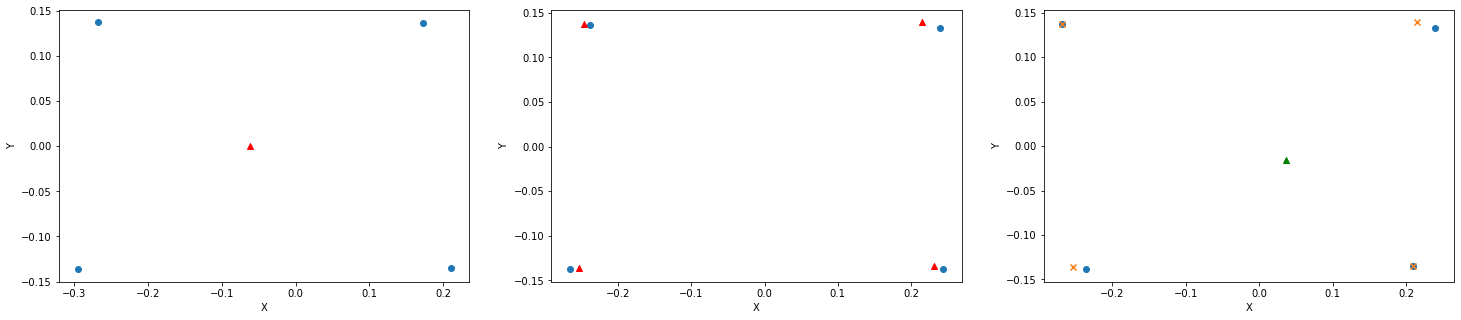

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08545687 0.01743423]


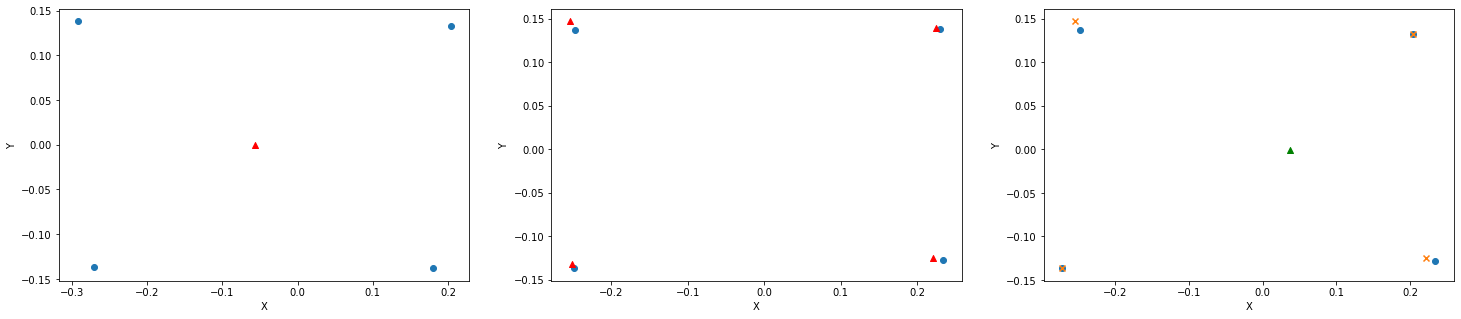

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08803914 -0.01495802]


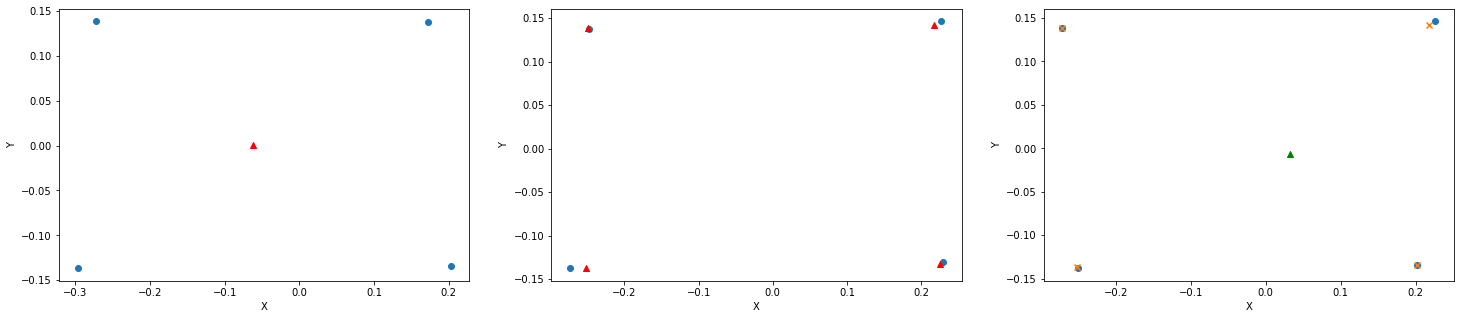

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08873566 0.01141572]


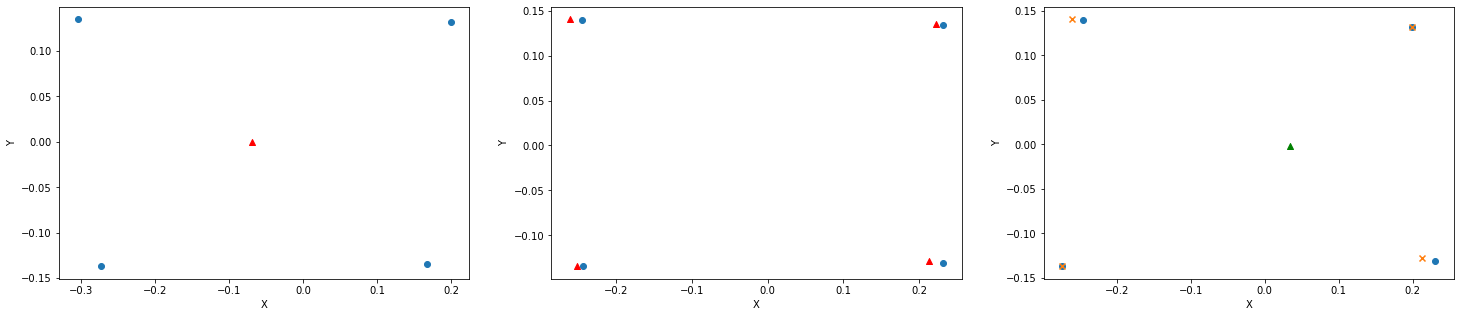

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.05096401 -0.01194507]


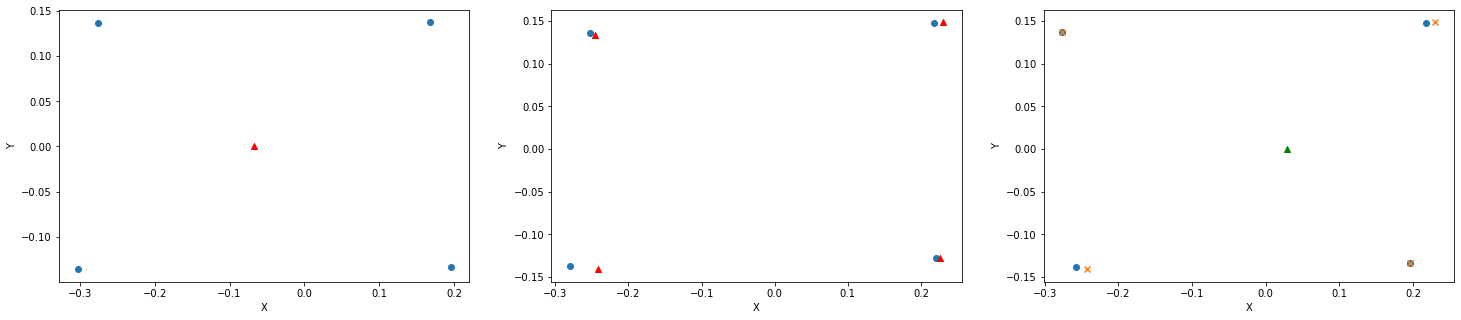

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08880706 0.00987824]


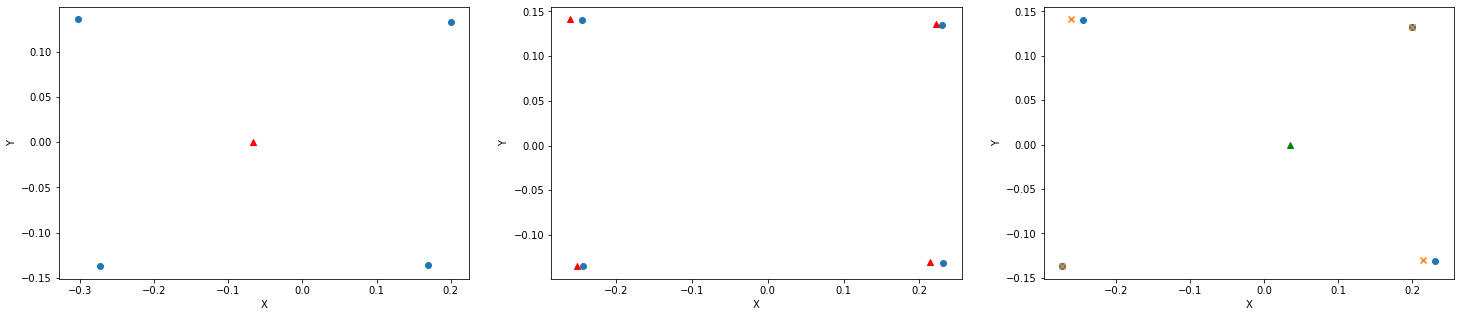

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08398494 0.0137005 ]


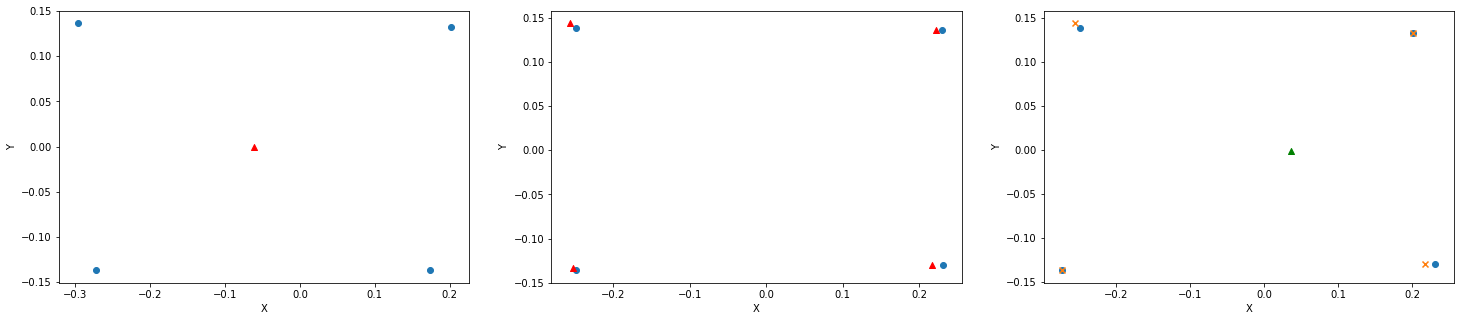

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.0969763  -0.00684529]


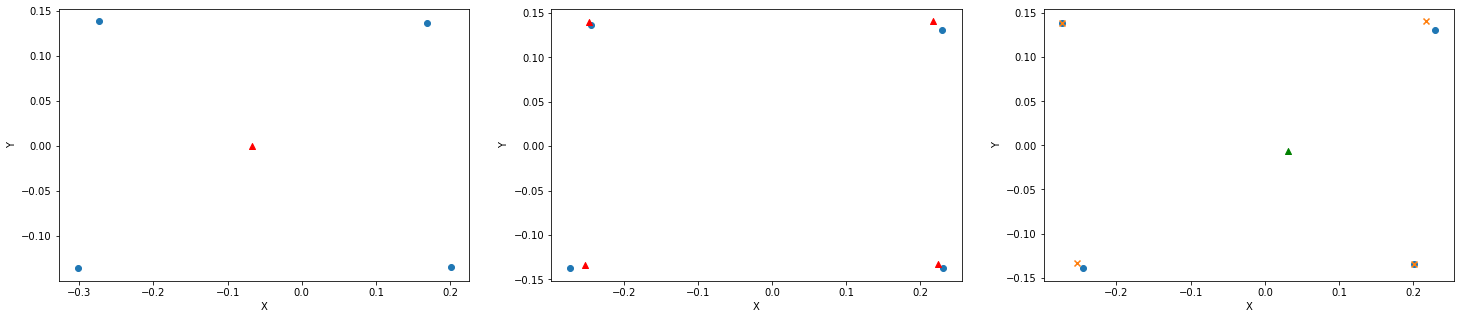

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.34994419 -0.01175255]


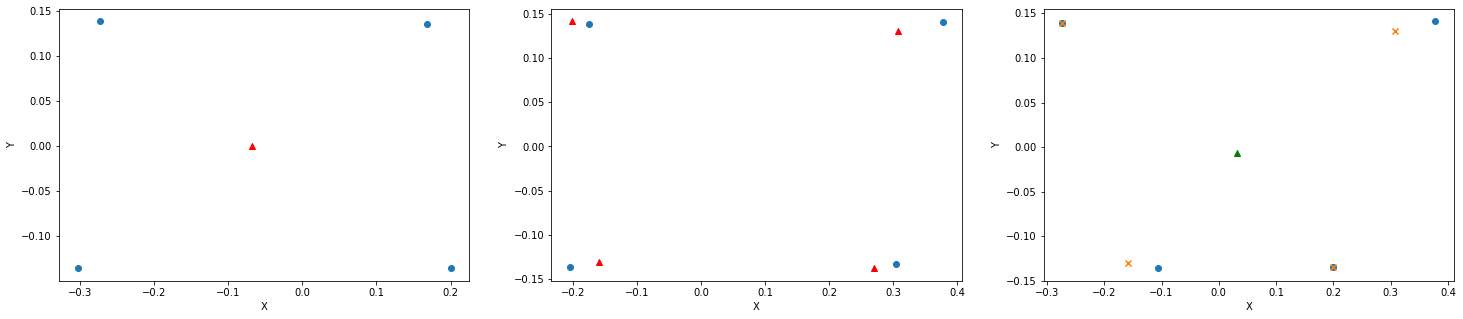

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09445654 -0.00304012]


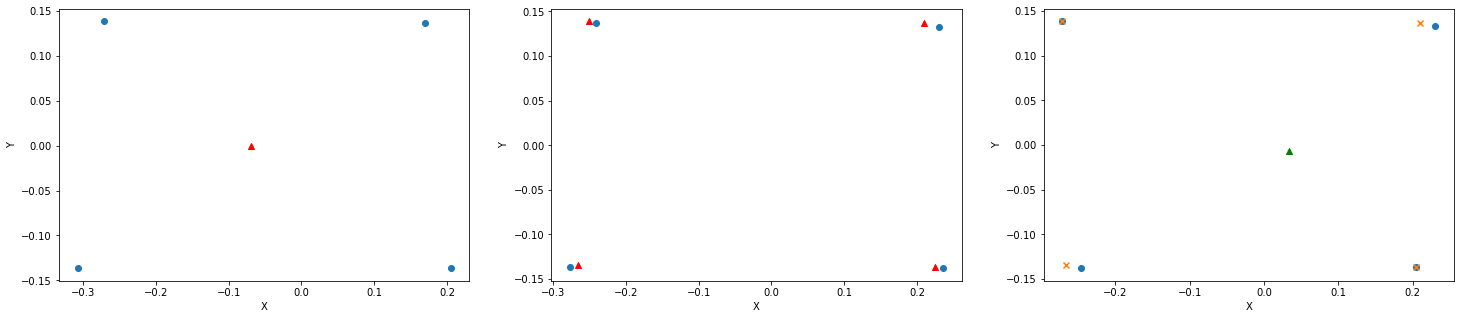

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [ 0.11249617 -0.00301365]


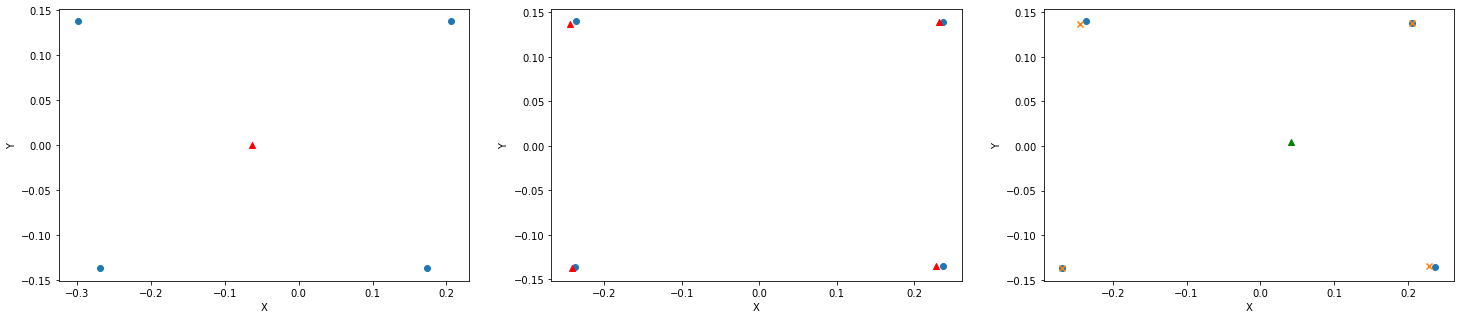

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09774352 -0.00150063]


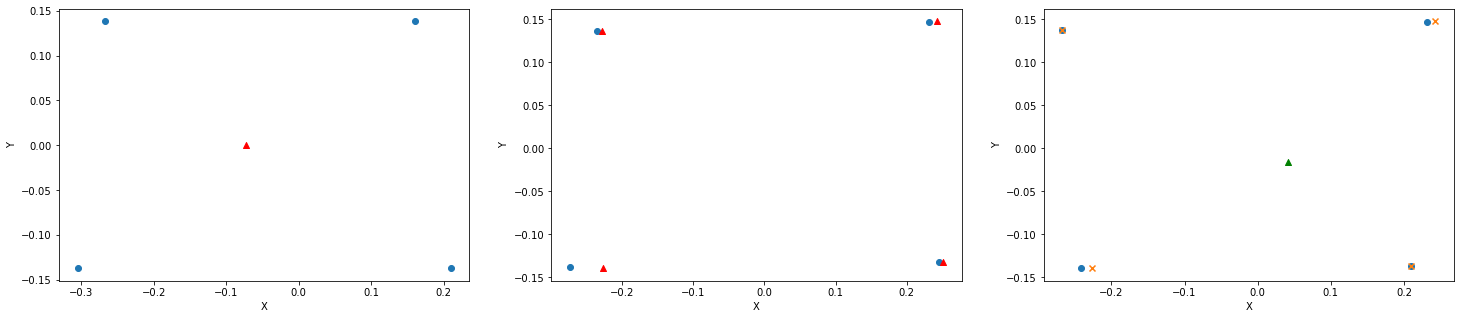

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08936185 0.00966086]


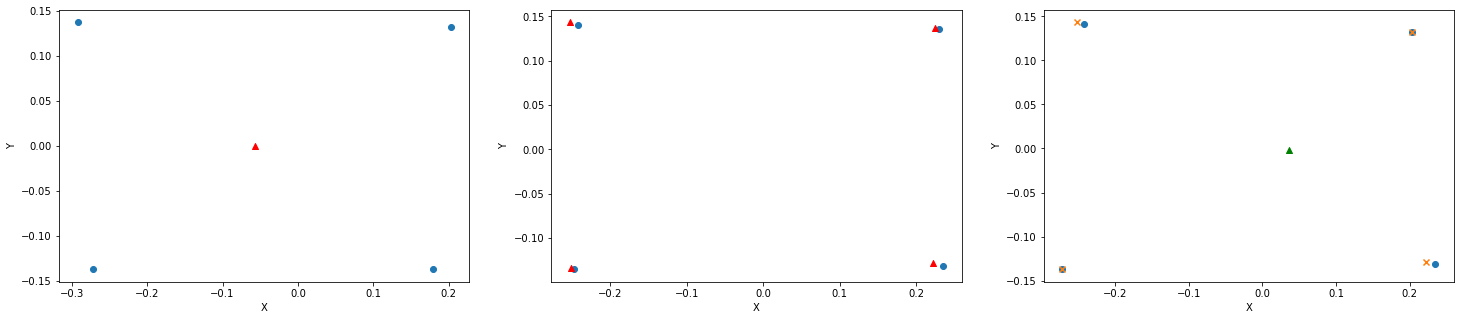

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0791346  0.03206216]


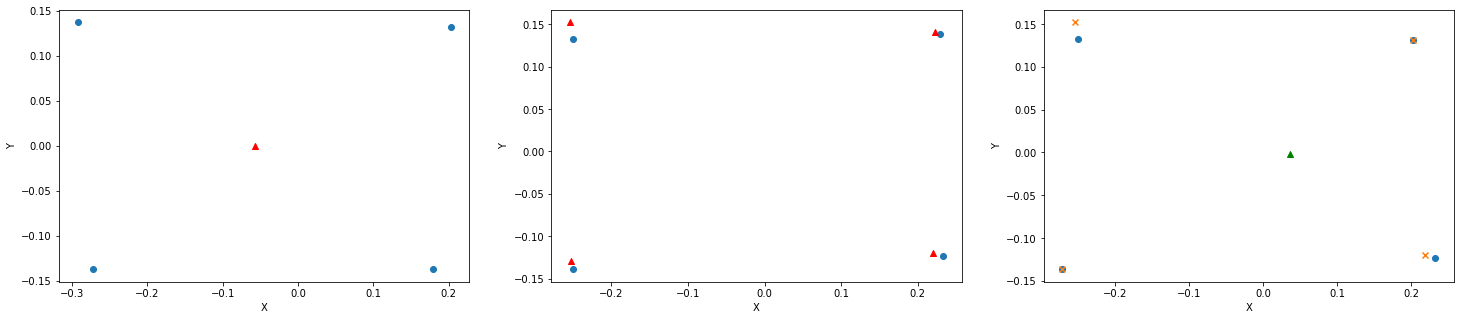

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08197669 -0.00796308]


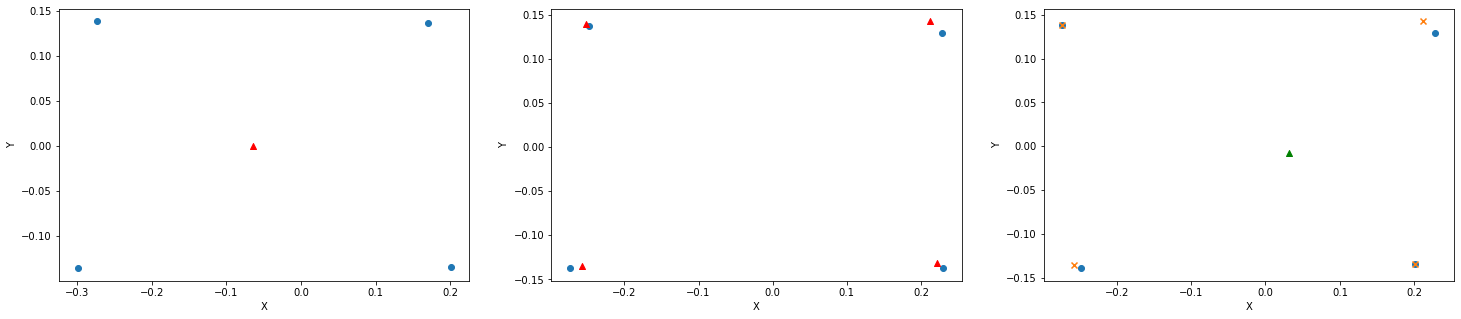

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08692145 0.01756522]


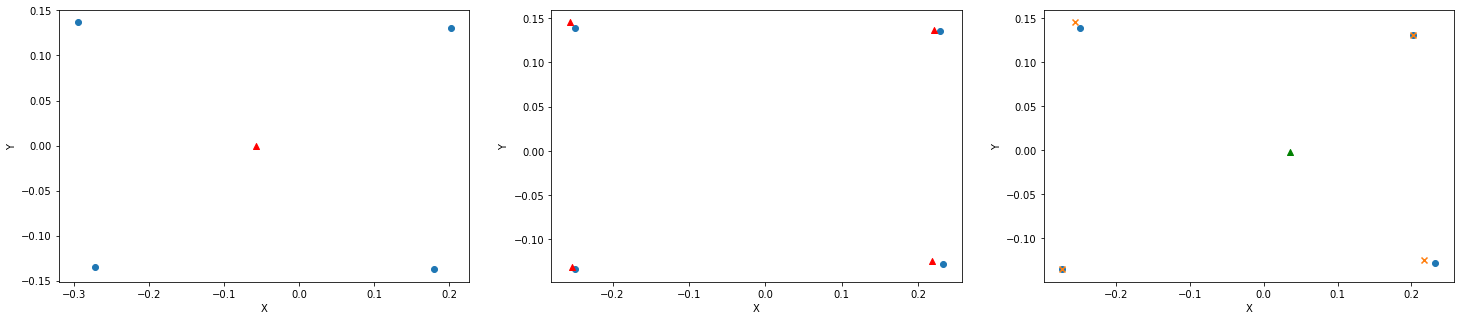

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.0508633  -0.01350908]


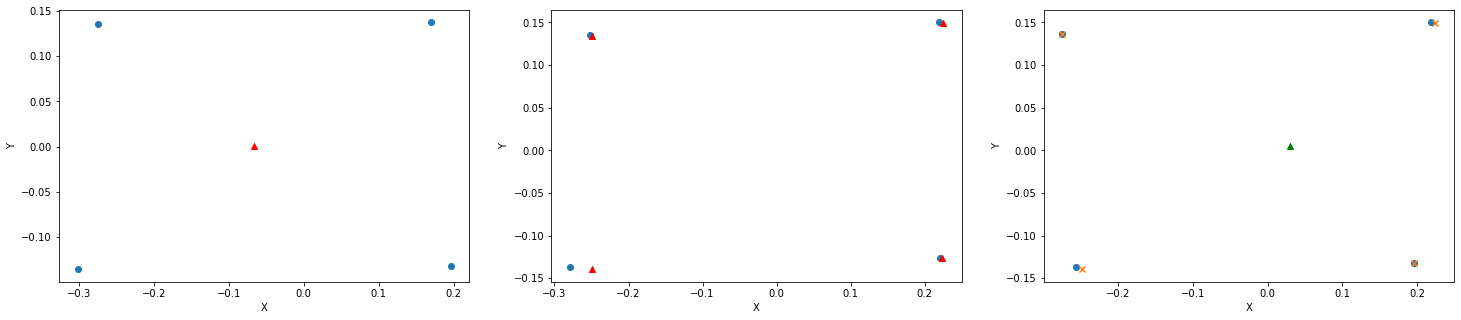

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.07539302 0.01266447]


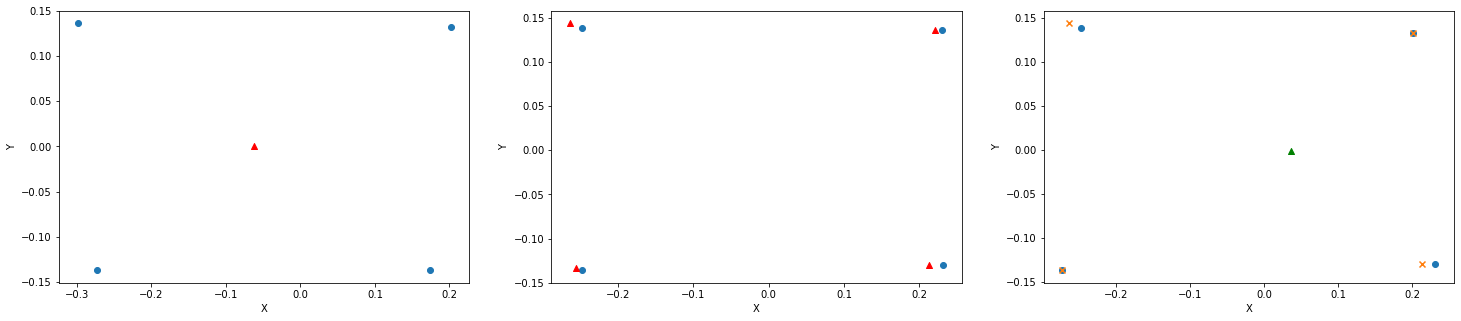

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09728968 -0.00385218]


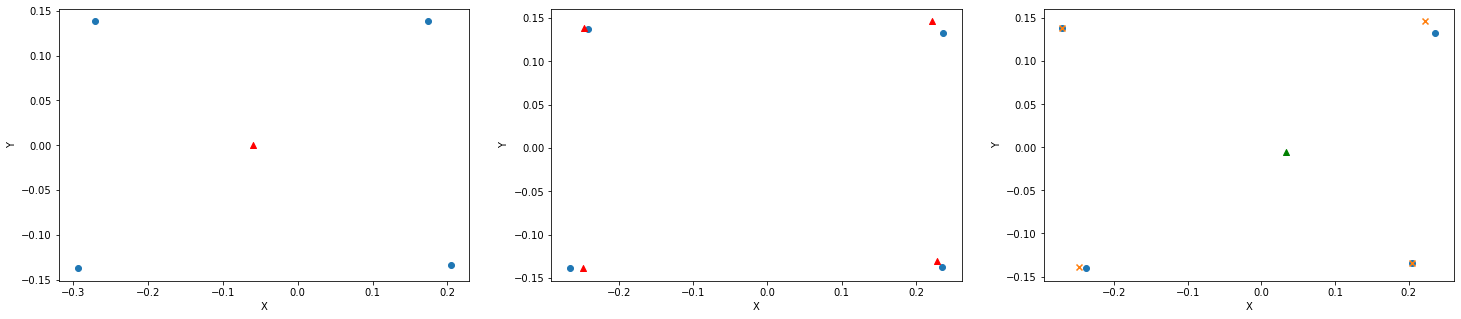

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09239826 -0.00628104]


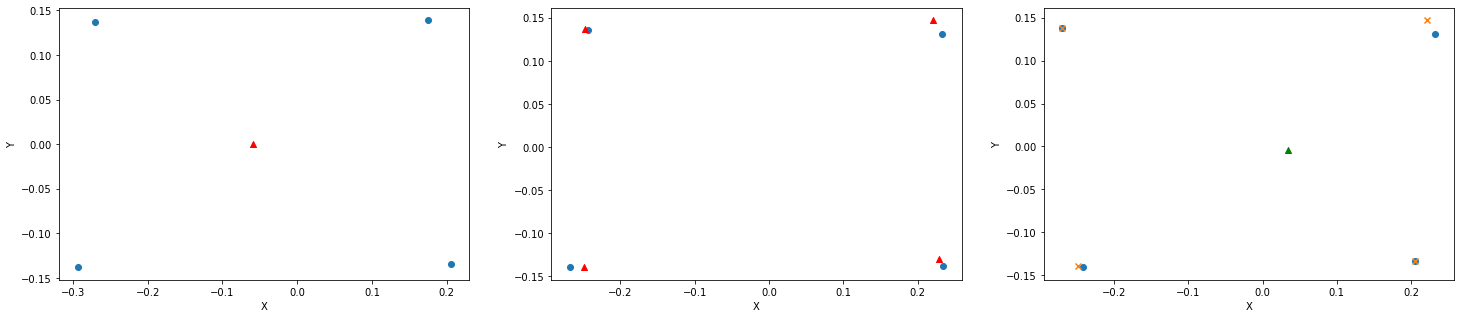

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0848625  0.01885546]


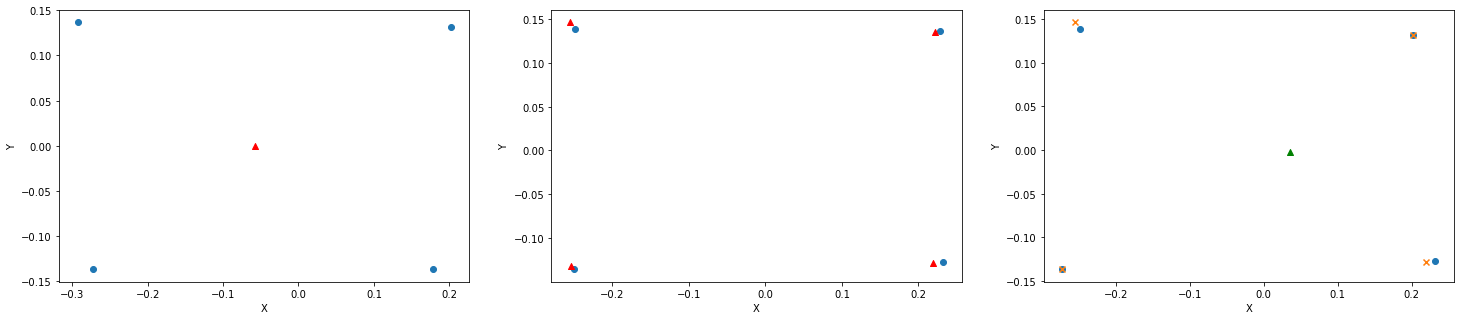

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [4.80570642e-02 8.84758742e-05]


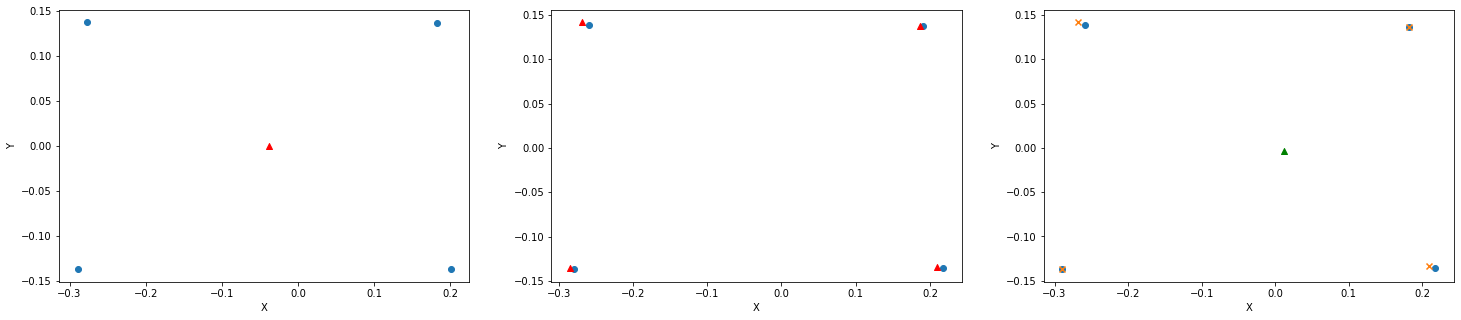

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07642546 -0.01082371]


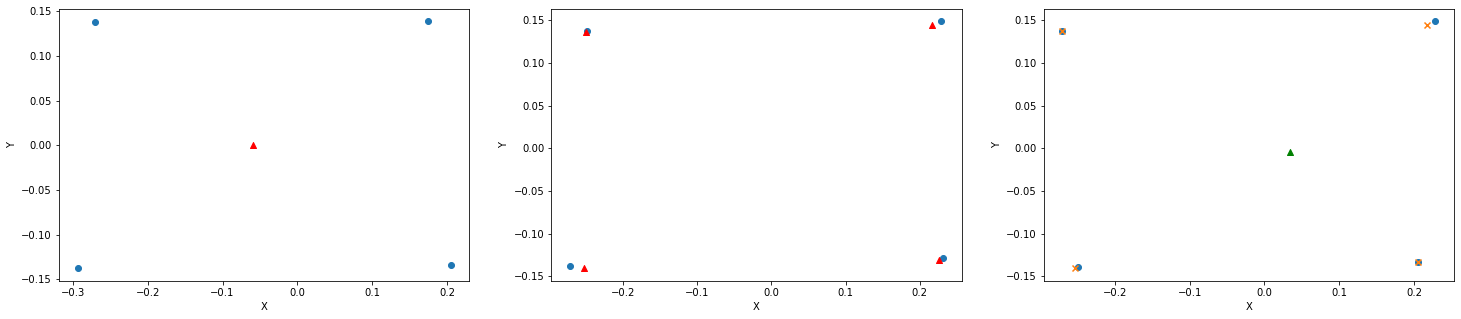

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09243325 0.01857396]


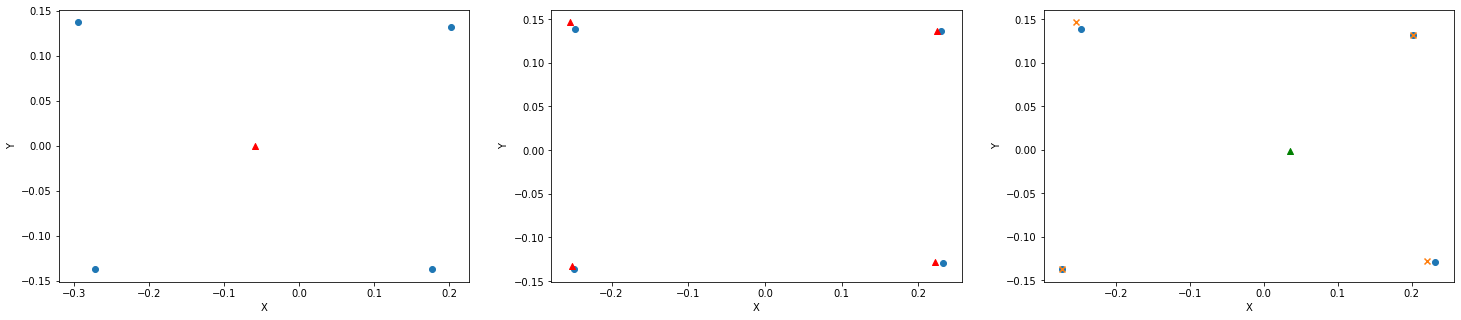

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.01871505 0.02886612]


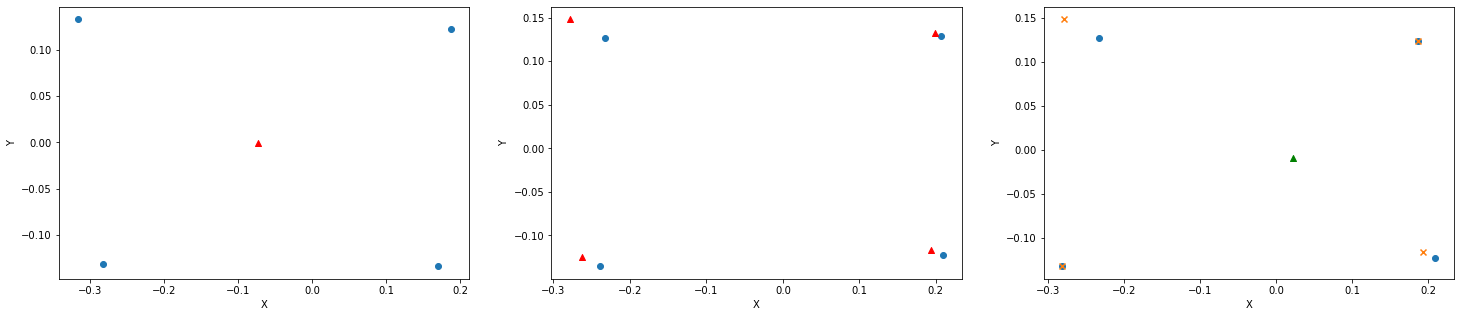

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0459404  0.00297648]


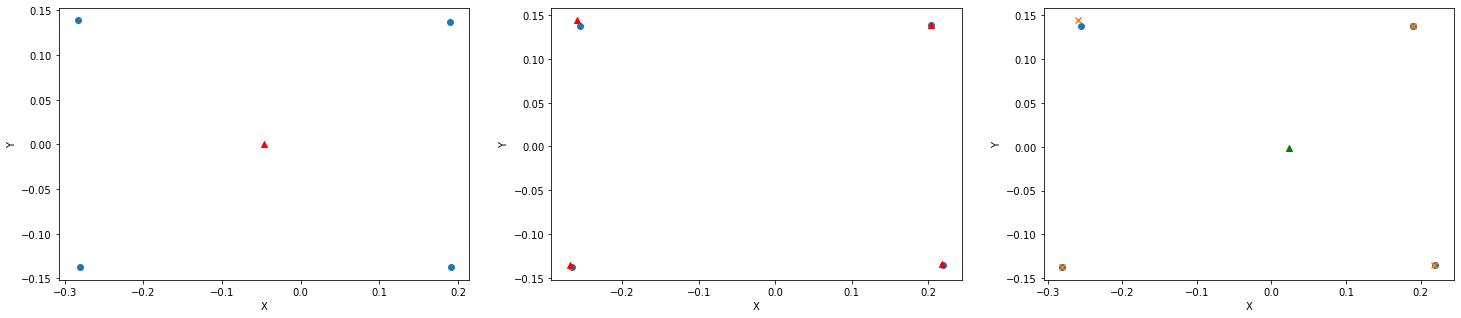

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09783118 -0.00344202]


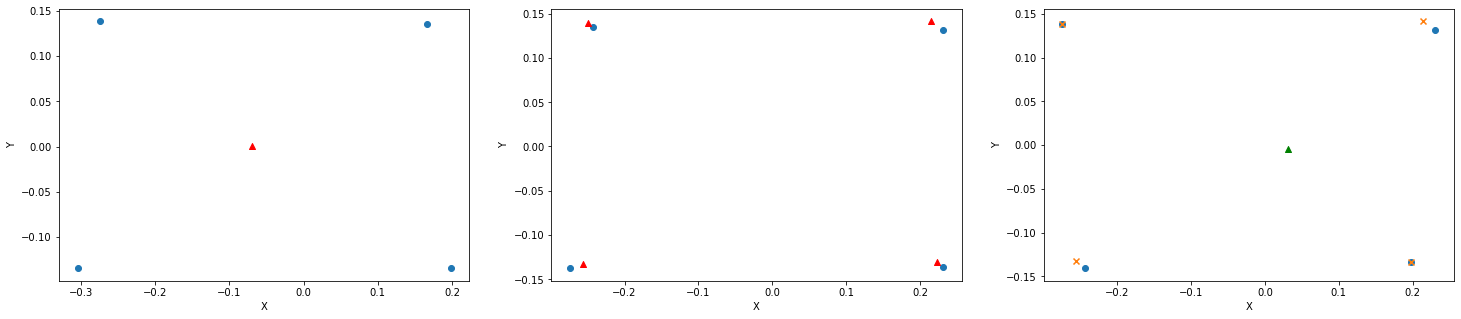

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0895288  0.01059047]


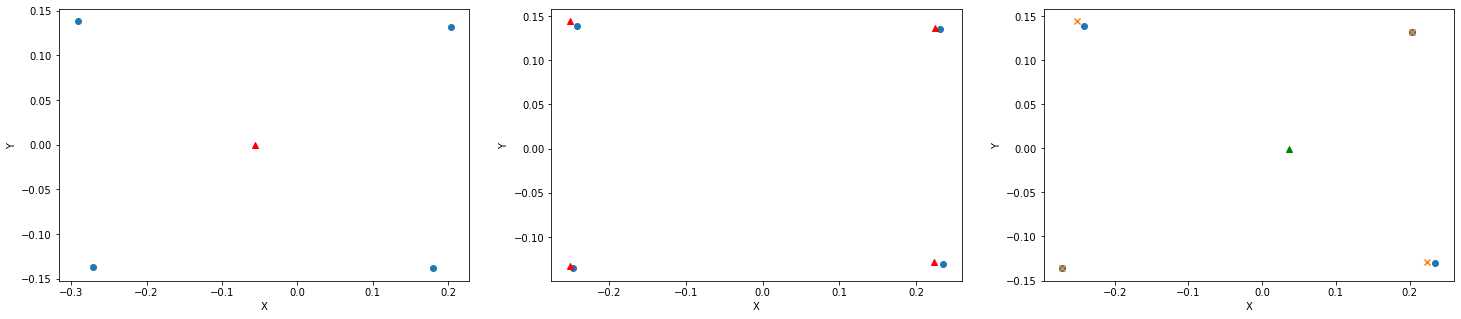

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09625533 0.00883614]


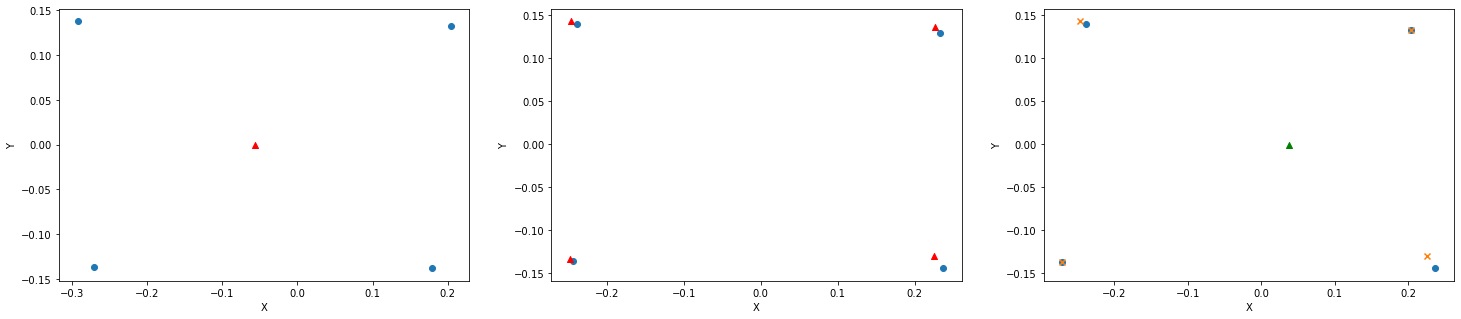

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08807611 0.0145112 ]


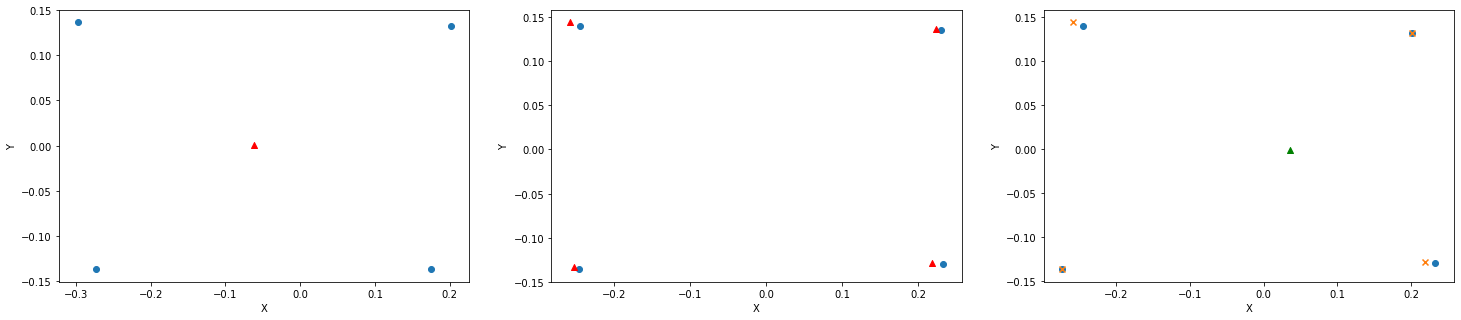

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09818643 0.01020602]


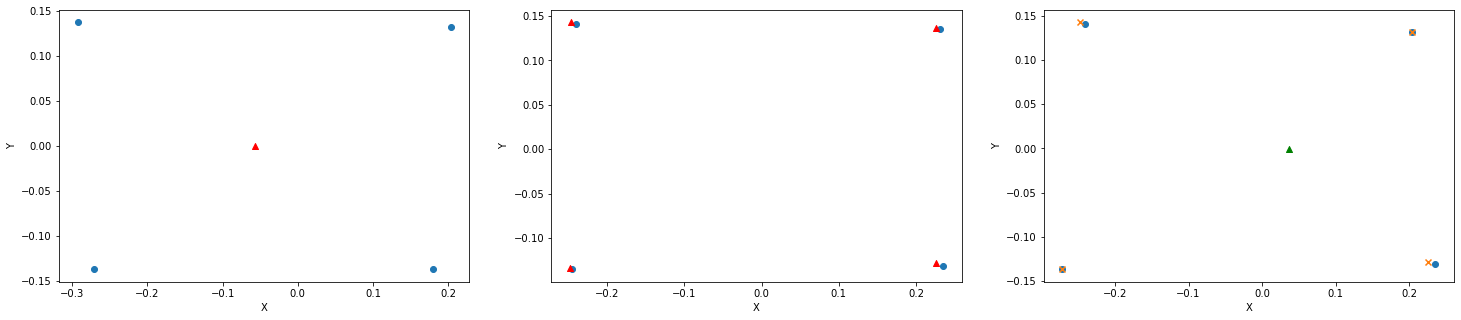

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.06784203 -0.00825302]


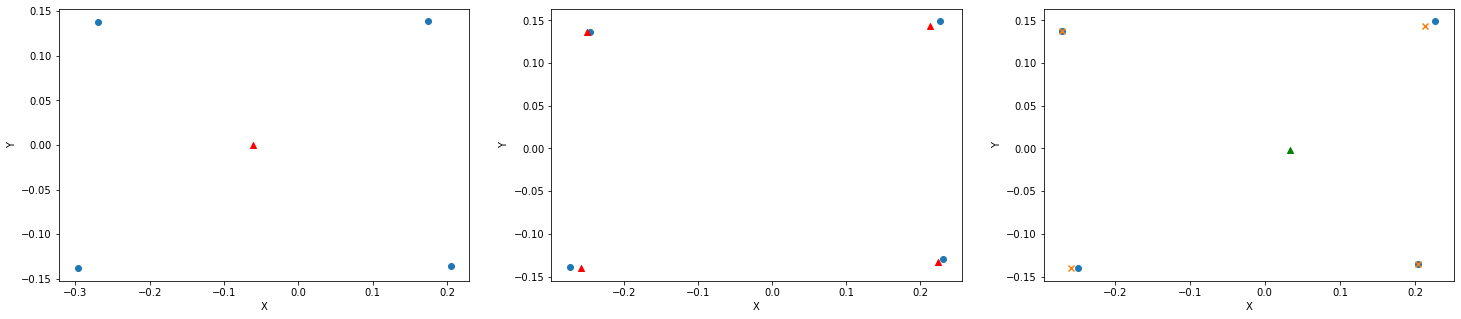

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07642959 -0.01078517]


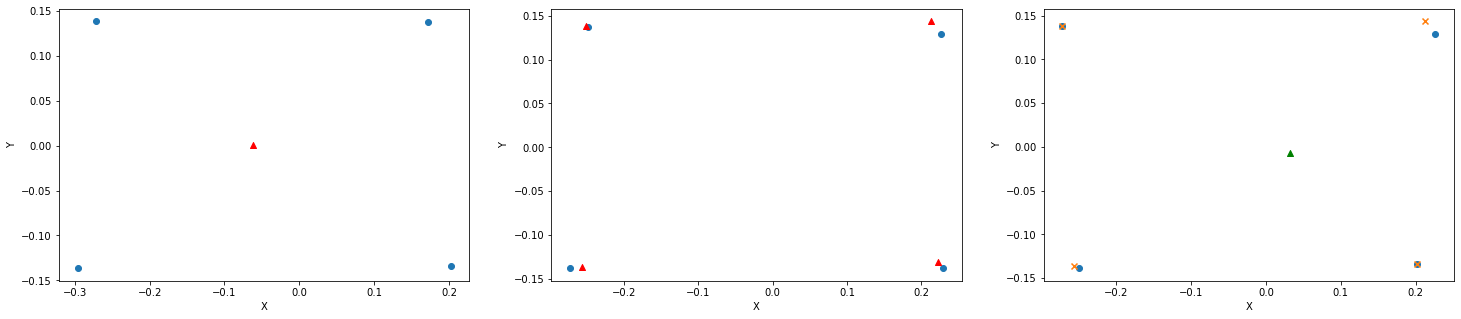

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07178816 -0.01427594]


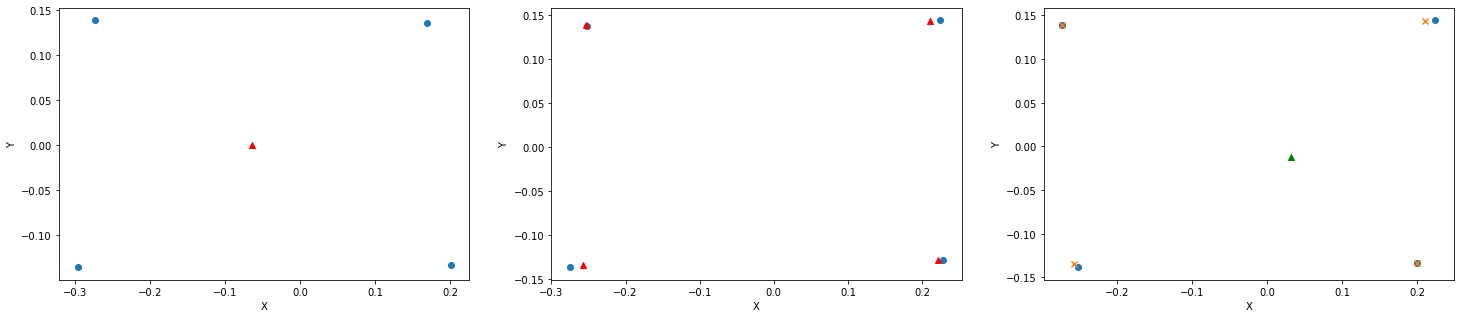

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08074056 0.02581228]


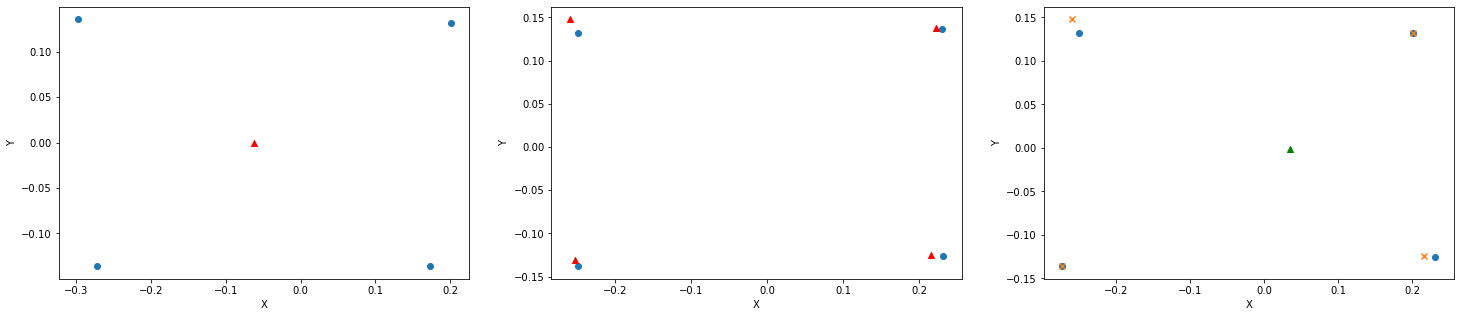

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.01871505 0.02886612]


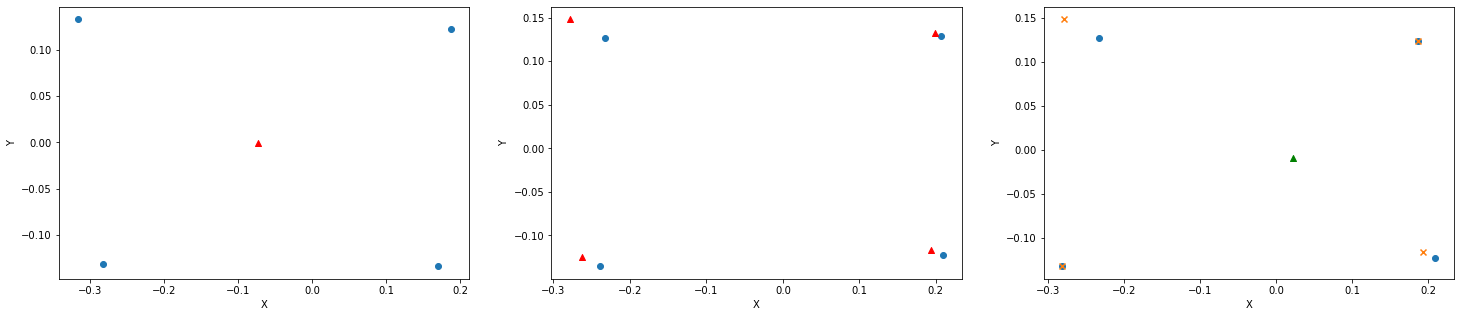

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07851975 -0.00507047]


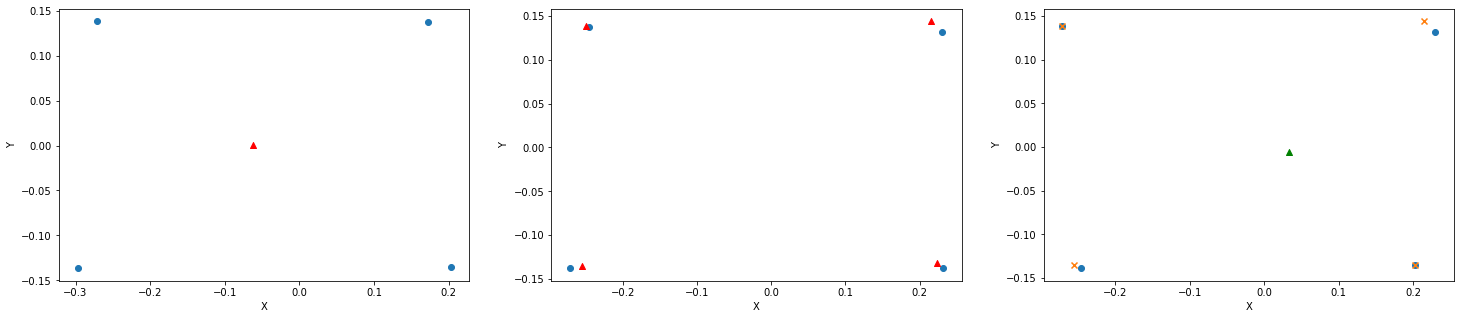

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09518829 0.01770637]


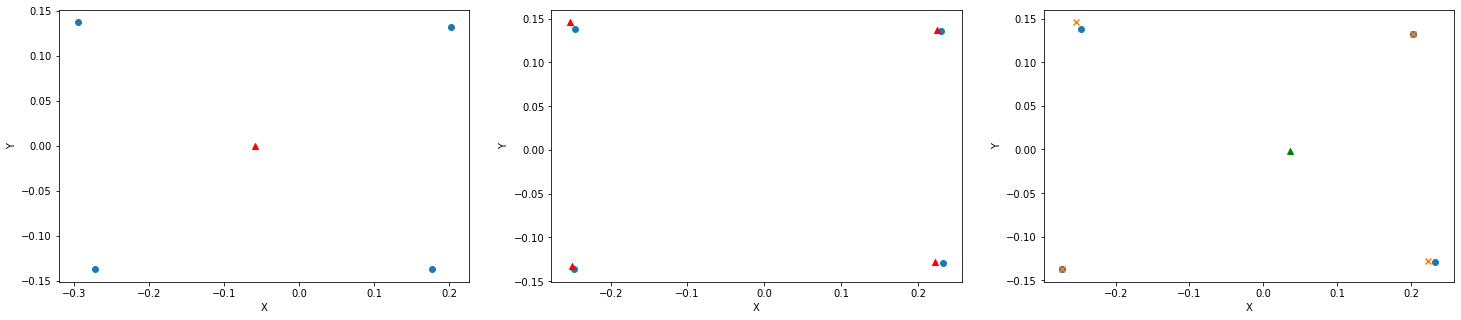

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09449952 0.00913572]


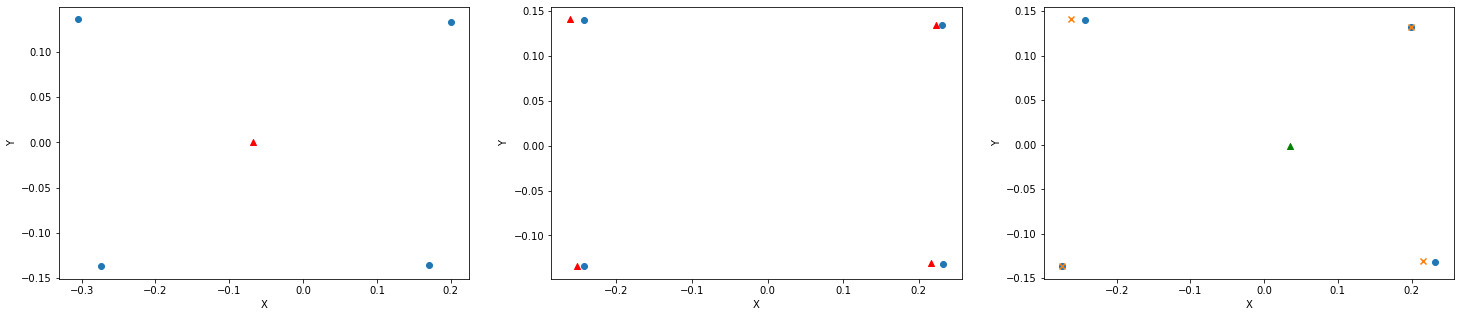

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0963363  0.00998971]


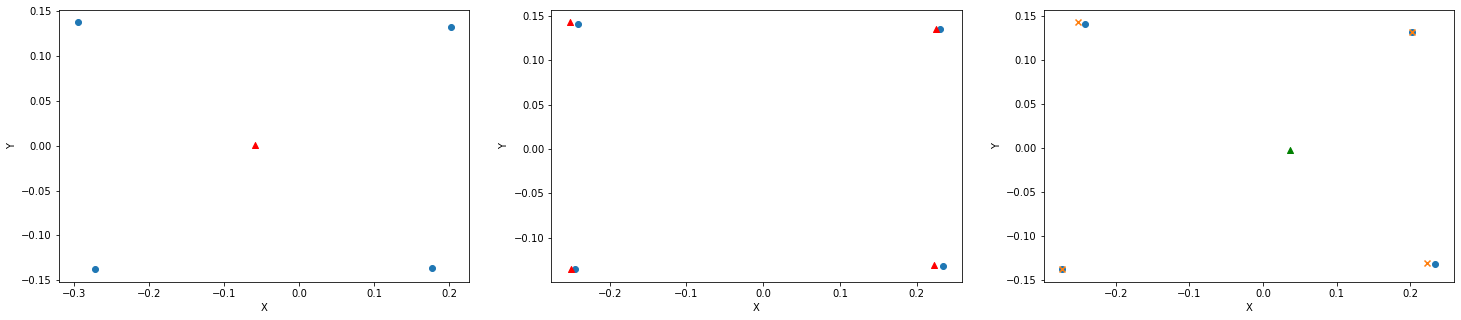

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09411469 -0.00072325]


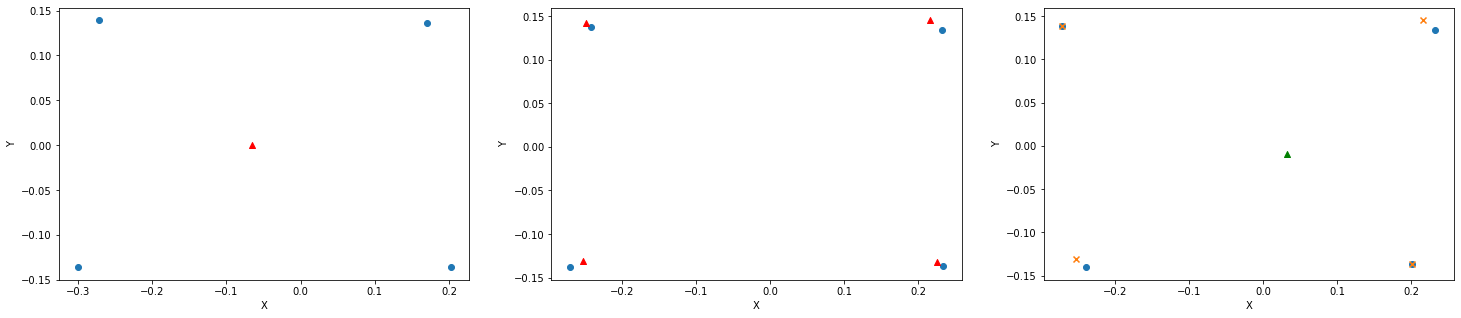

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.10185754 0.00818475]


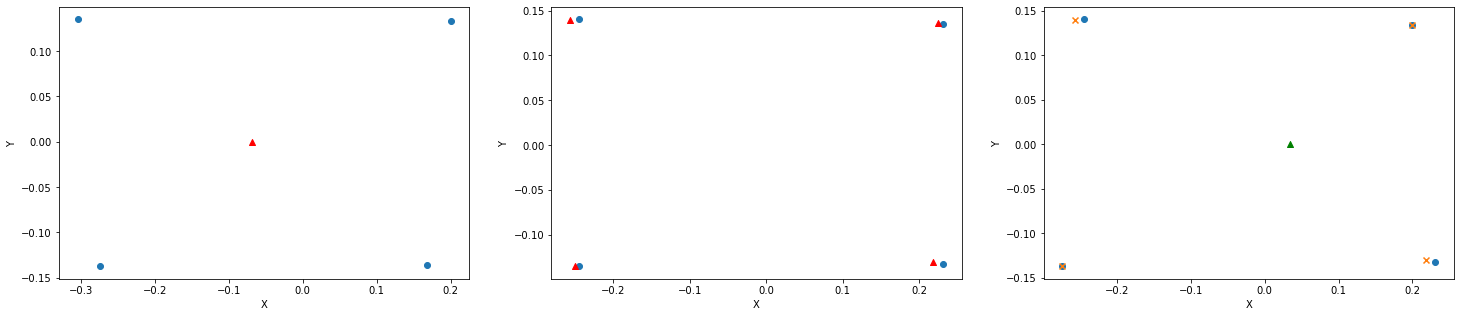

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08039097 -0.01108219]


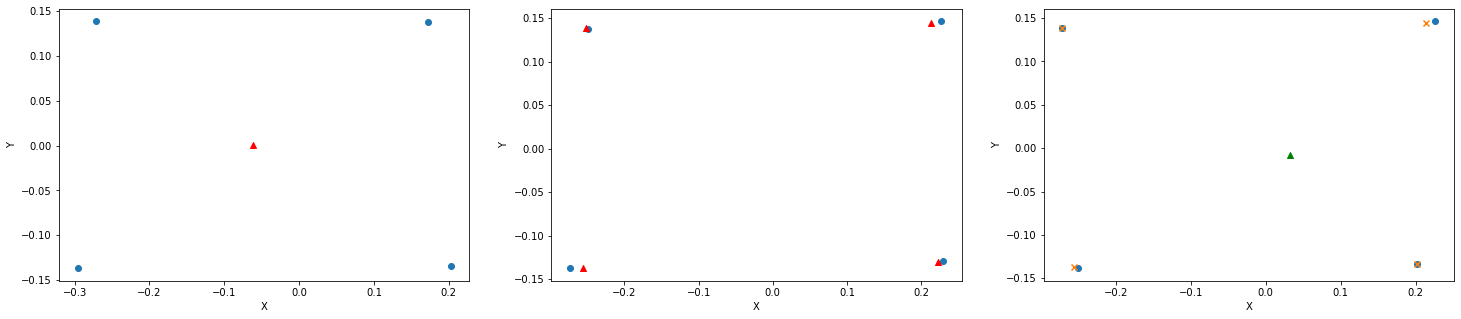

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08649419 0.03380938]


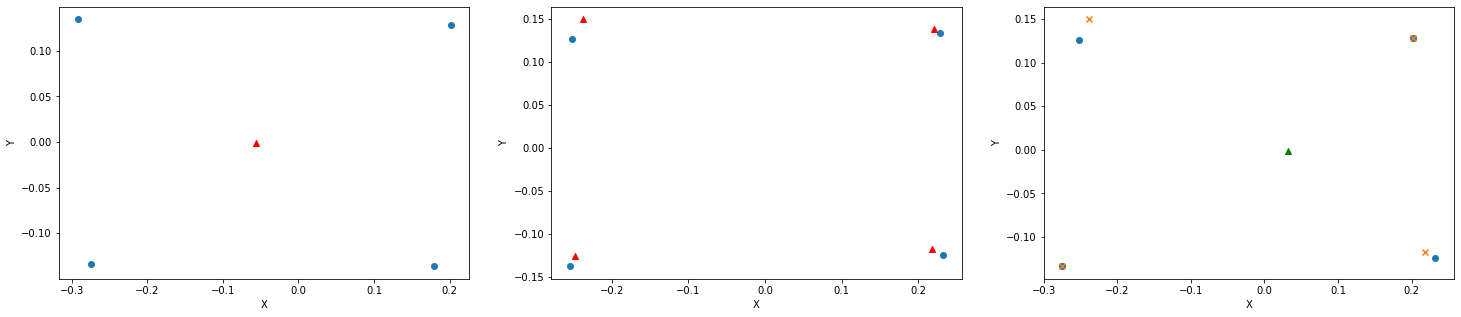

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.21340441 0.03570609]


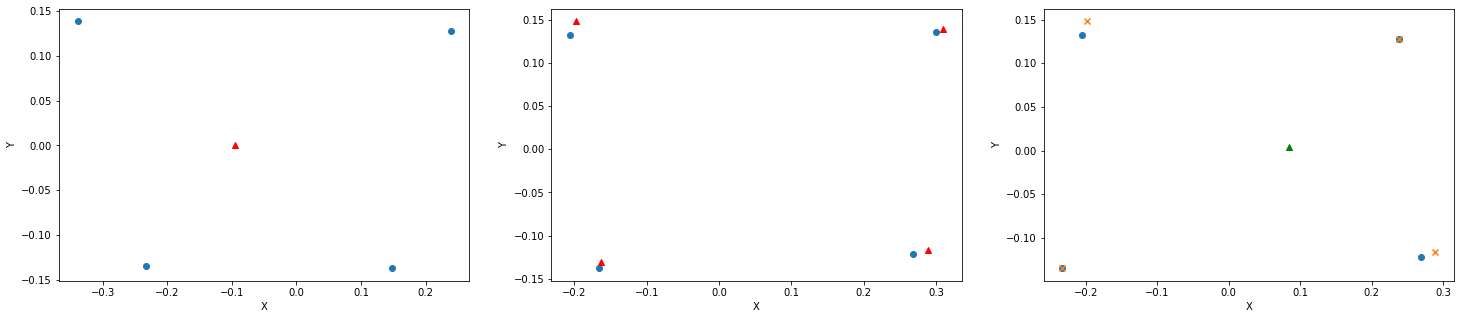

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08264476 0.03041529]


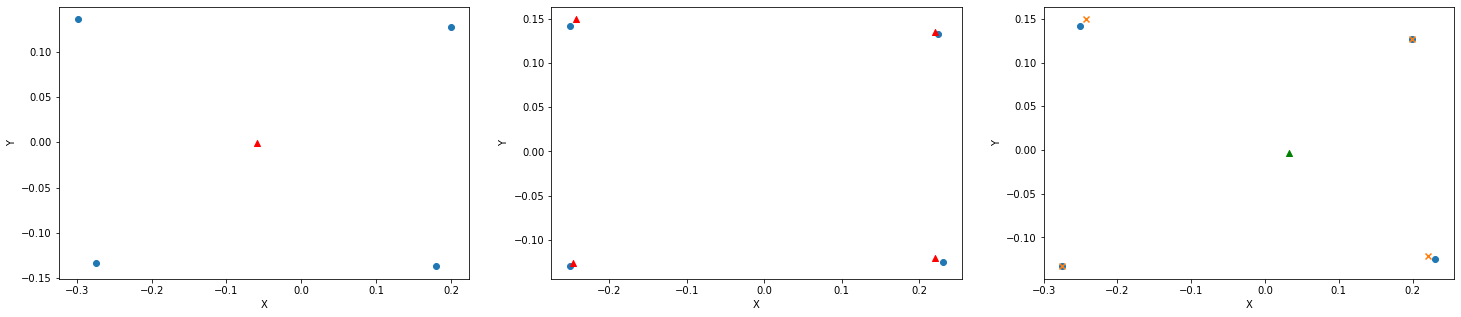

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.22041272 0.03306718]


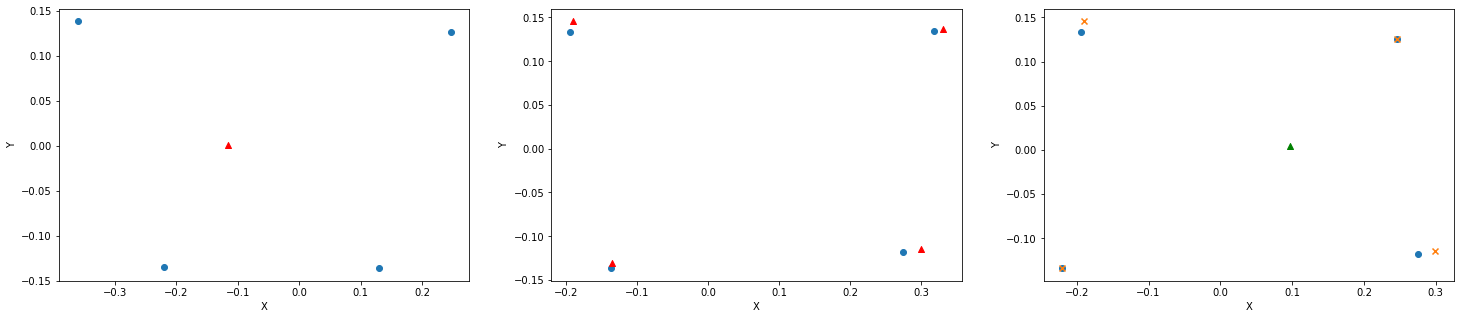

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.2595752 0.0161247]


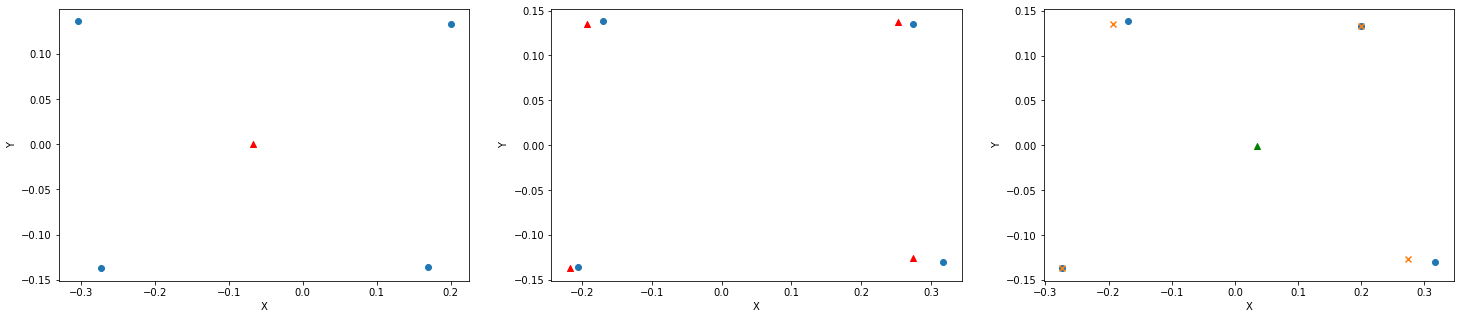

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09516025 0.02132497]


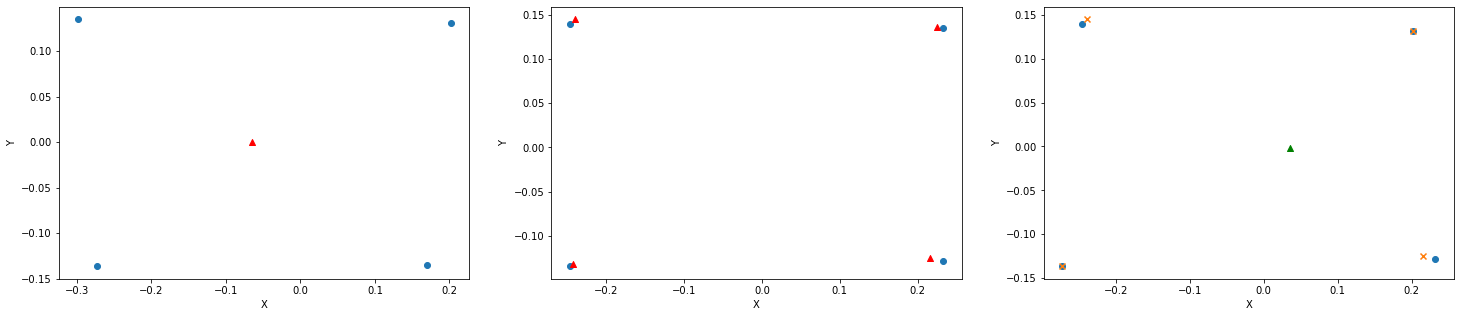

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.10225038 0.01927327]


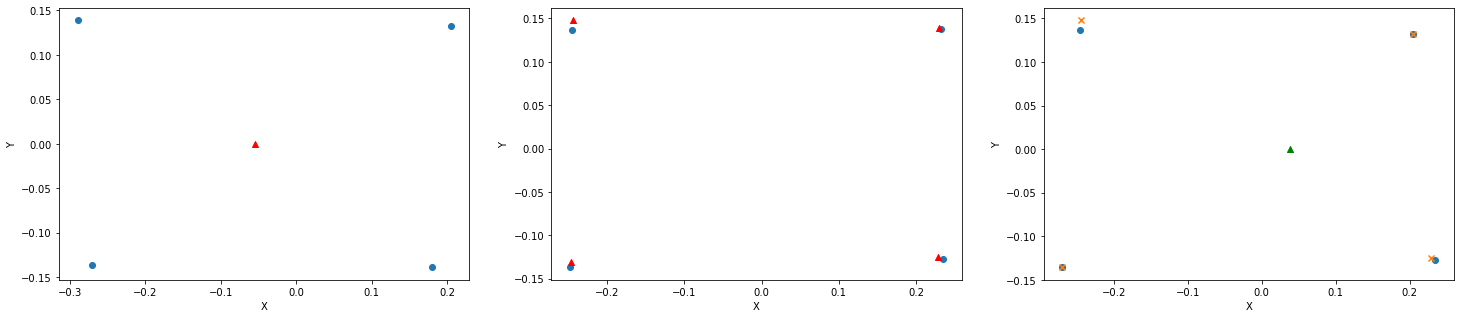

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09704029 0.00726572]


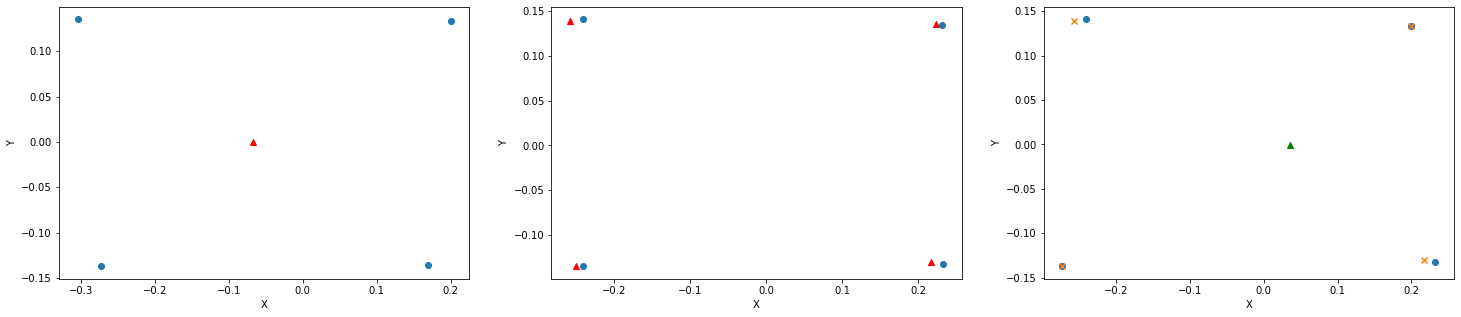

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08970202 0.02456487]


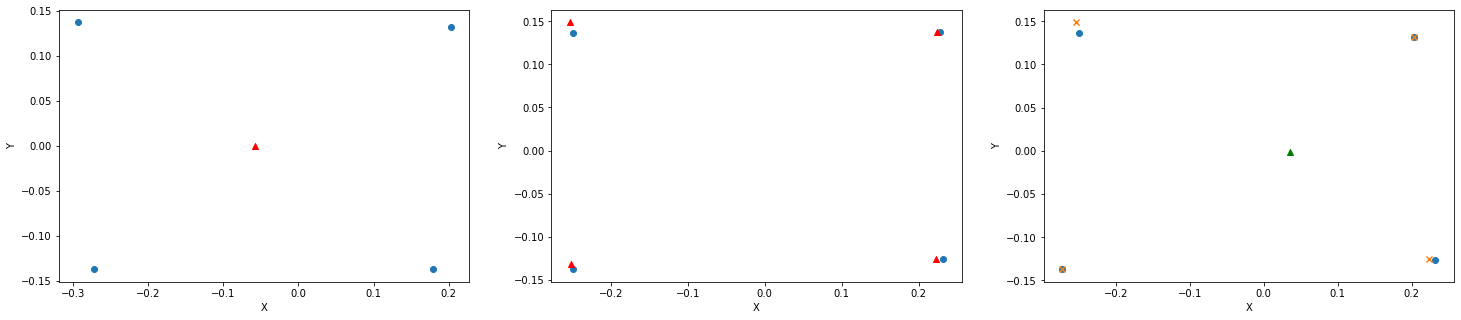

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.1158946  0.00427501]


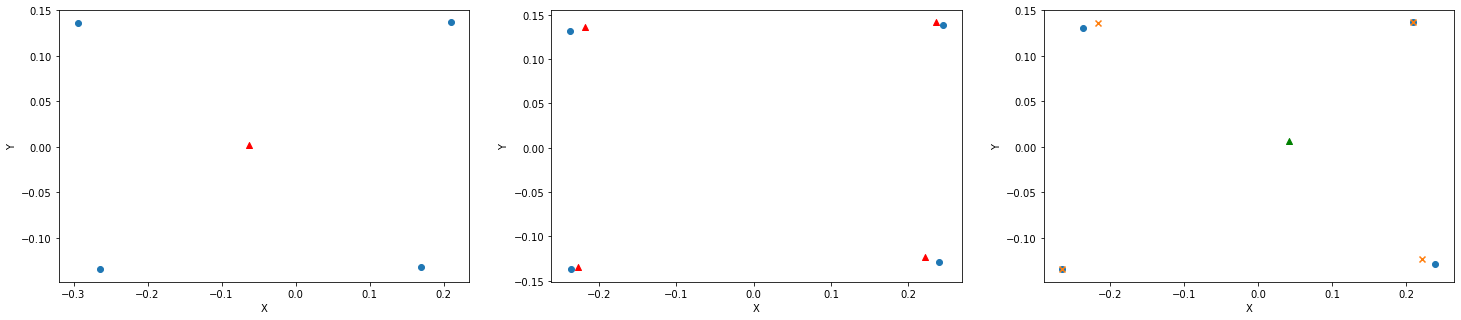

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.0744756  -0.00964021]


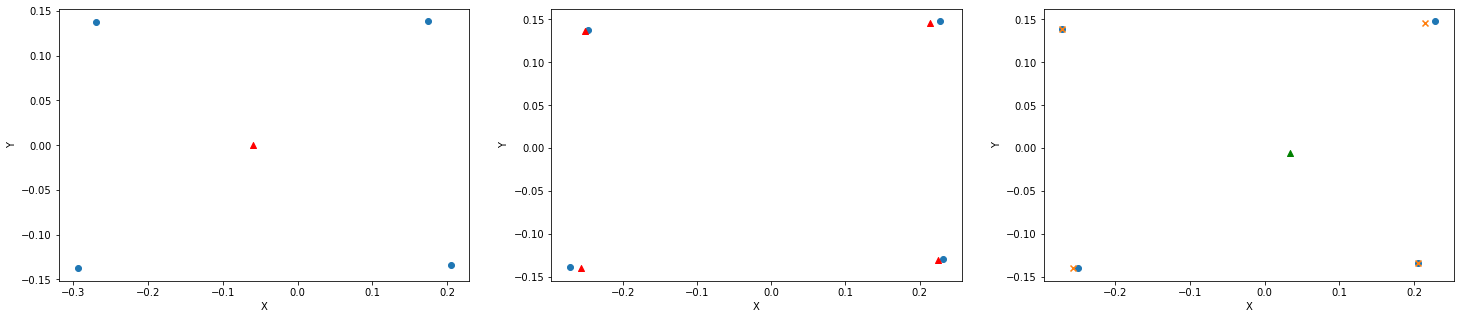

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09830126 -0.00725477]


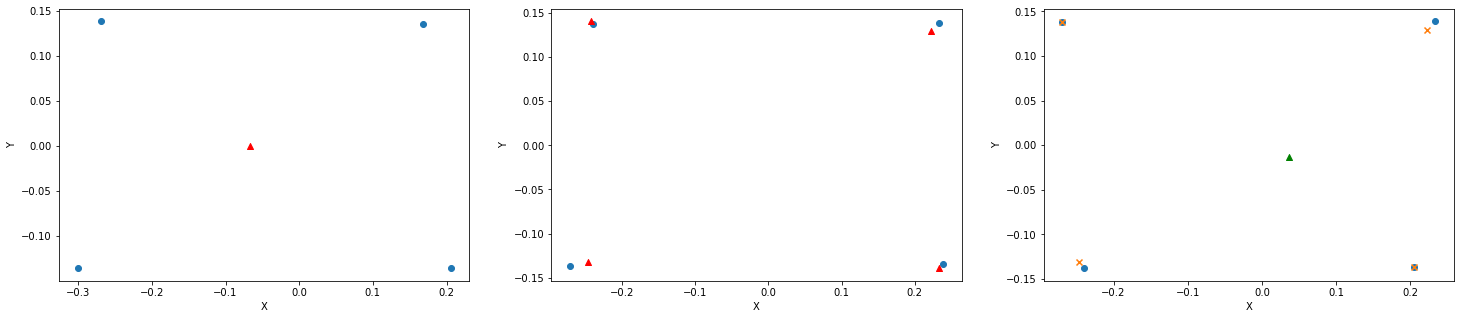

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08747628 -0.00636043]


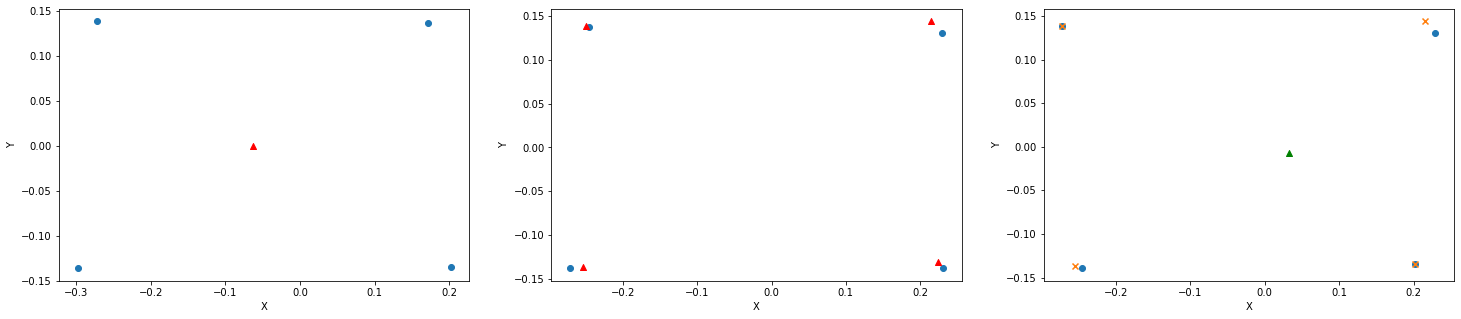

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.10606679 -0.00313638]


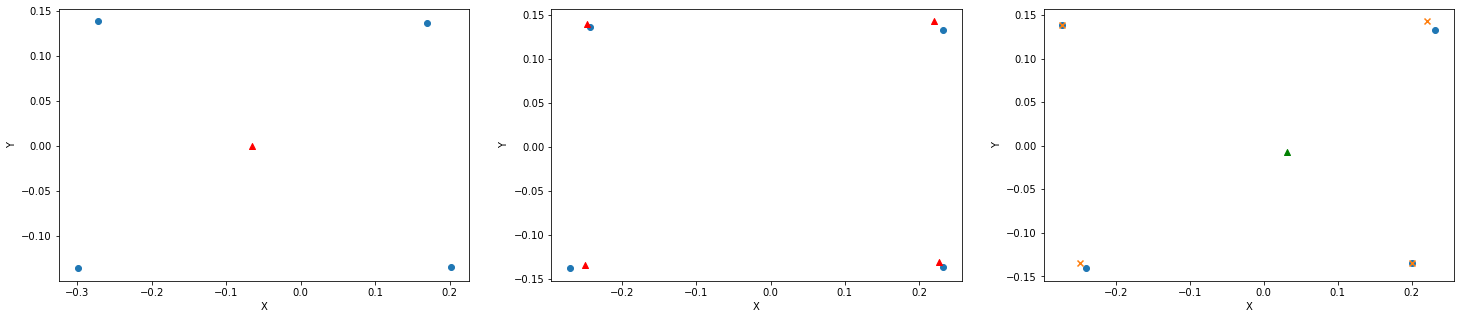

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08924539 0.01189172]


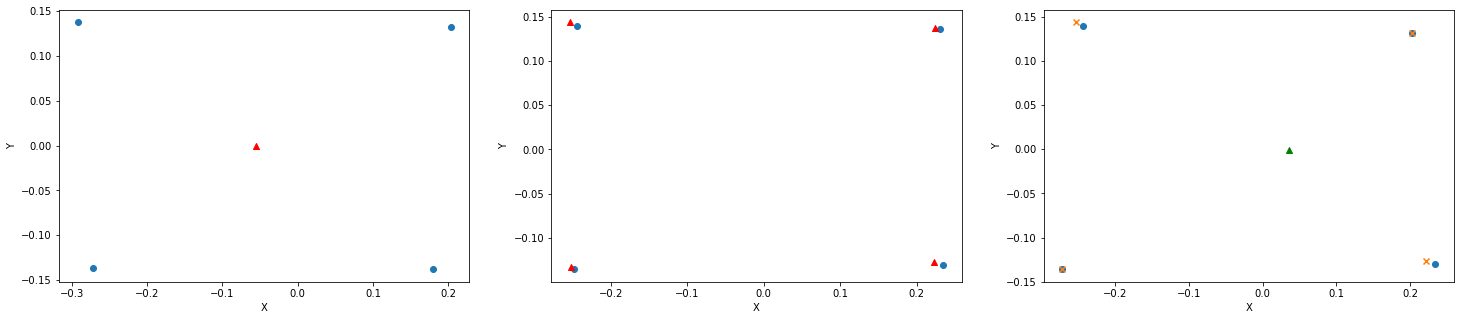

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.10008929 0.00822932]


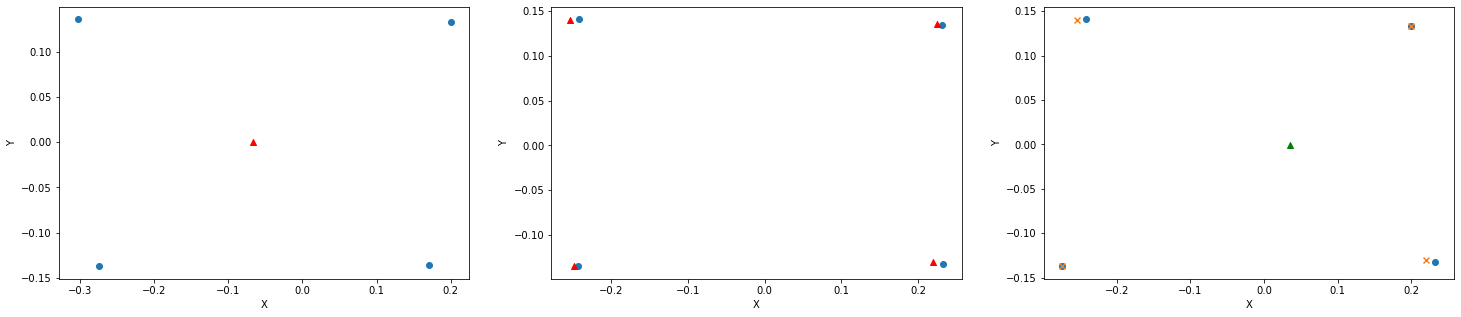

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09645019 0.01732708]


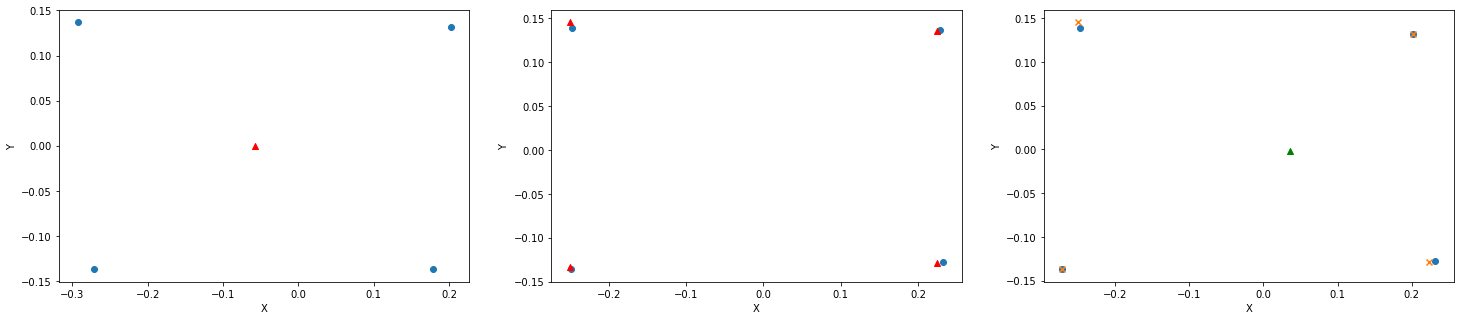

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0774936  0.02235262]


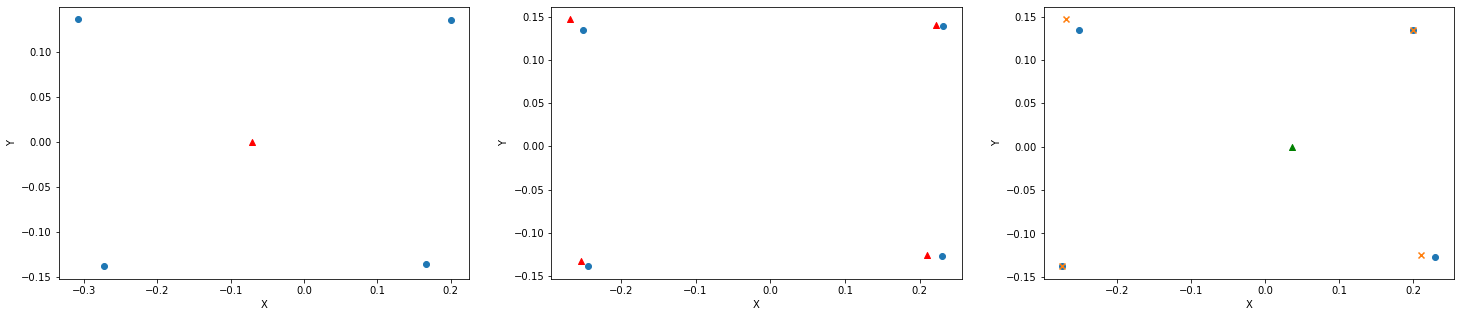

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09606865 0.01797941]


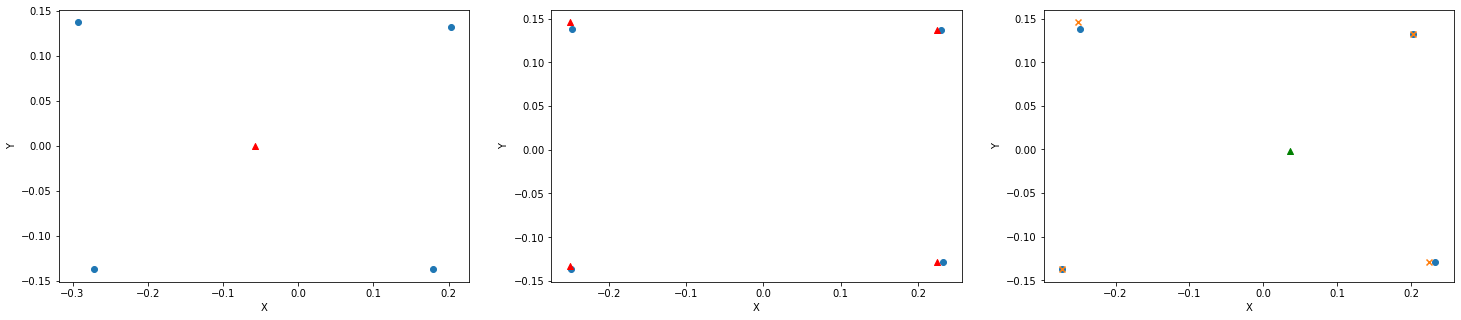

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.107712   -0.00334707]


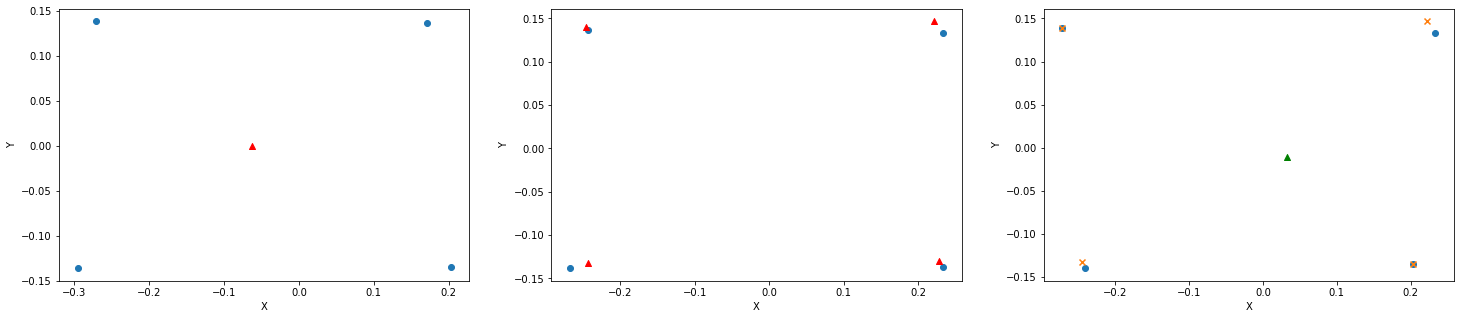

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08340702 0.0226959 ]


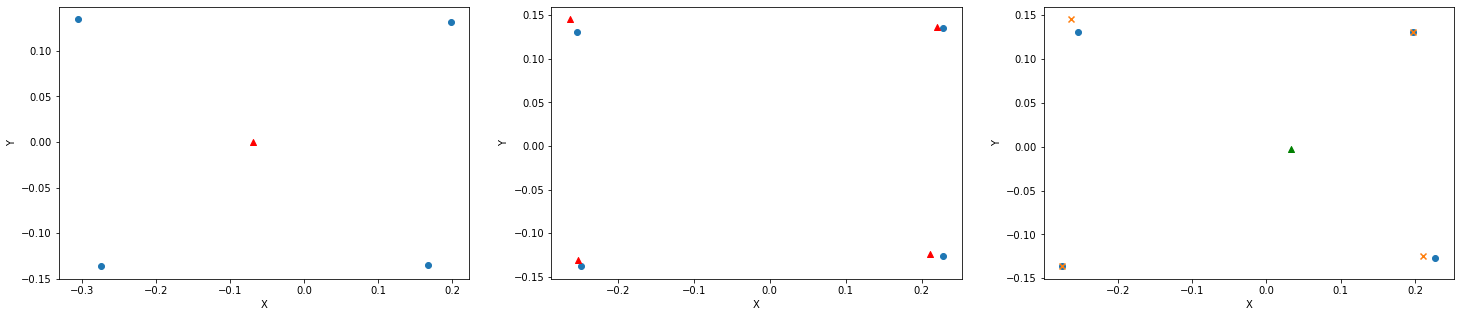

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.10519572 0.00967358]


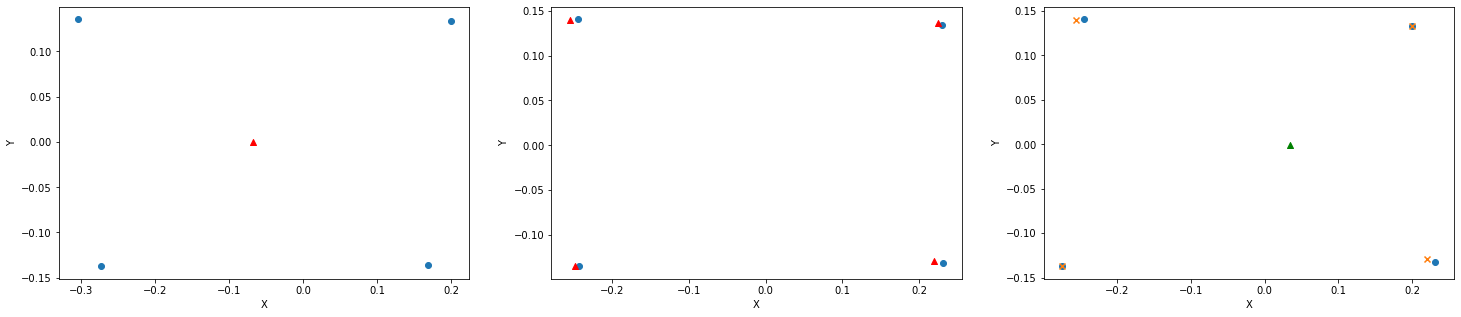

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0895282  0.01689883]


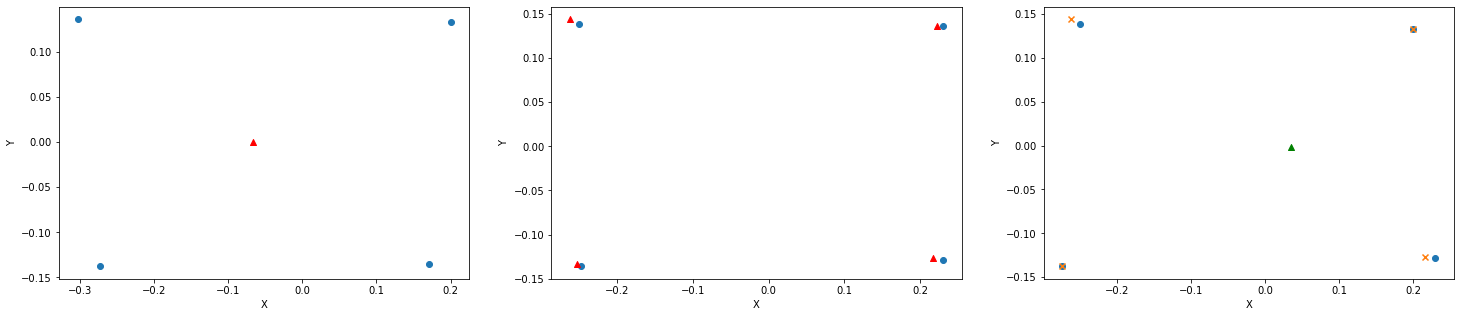

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09641217 0.00766321]


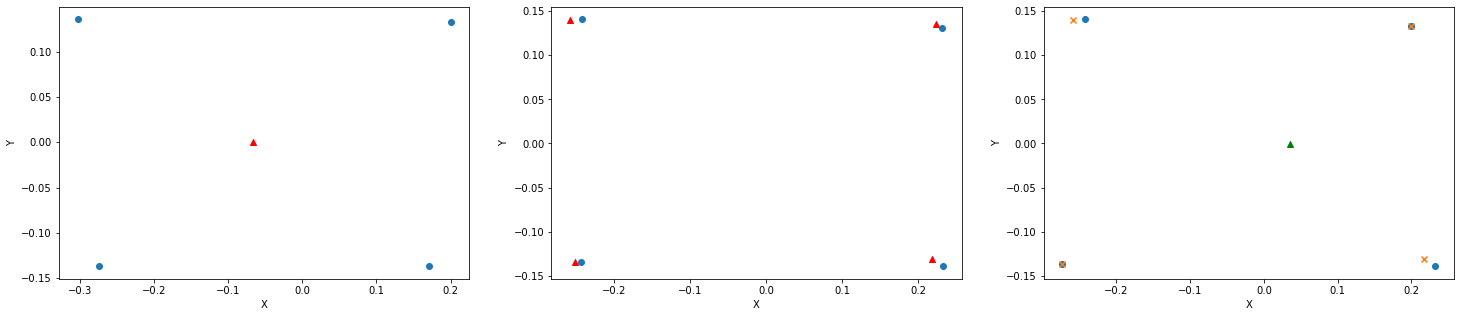

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0774936  0.02235262]


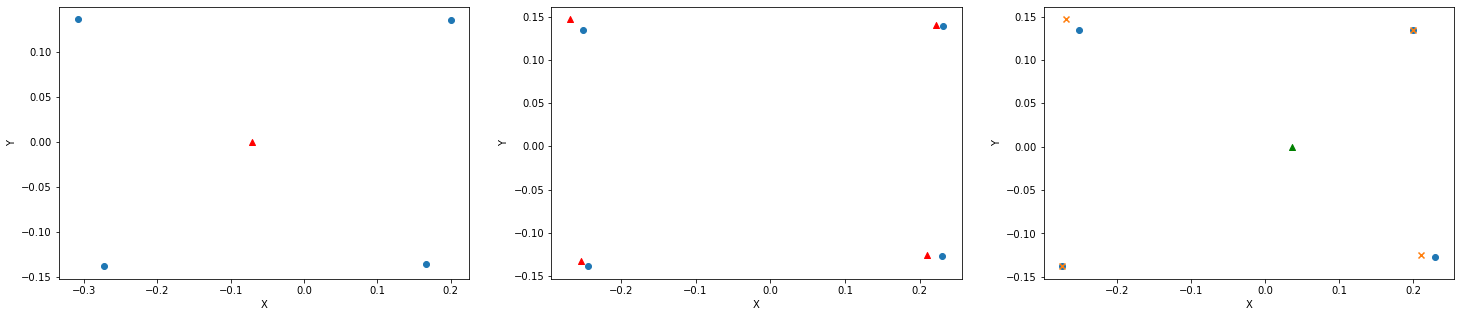

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.06446833 -0.00820052]


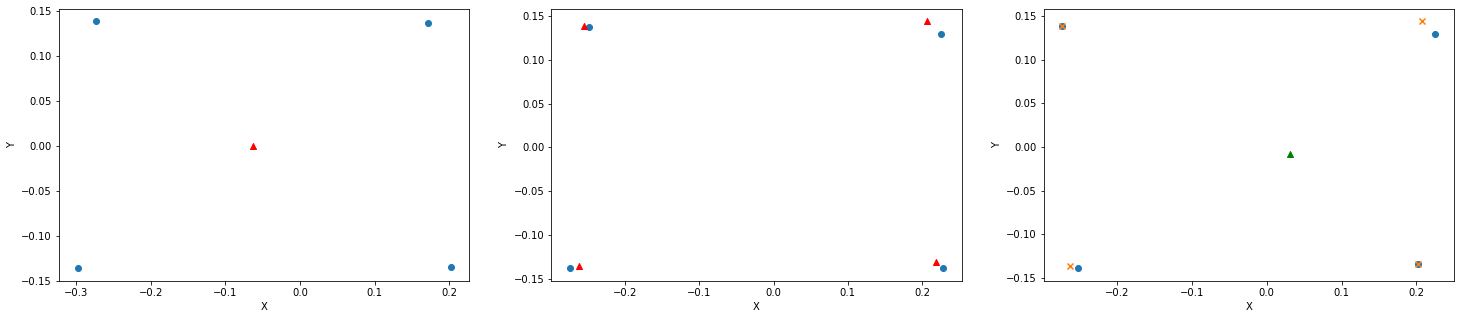

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07648826 -0.01663843]


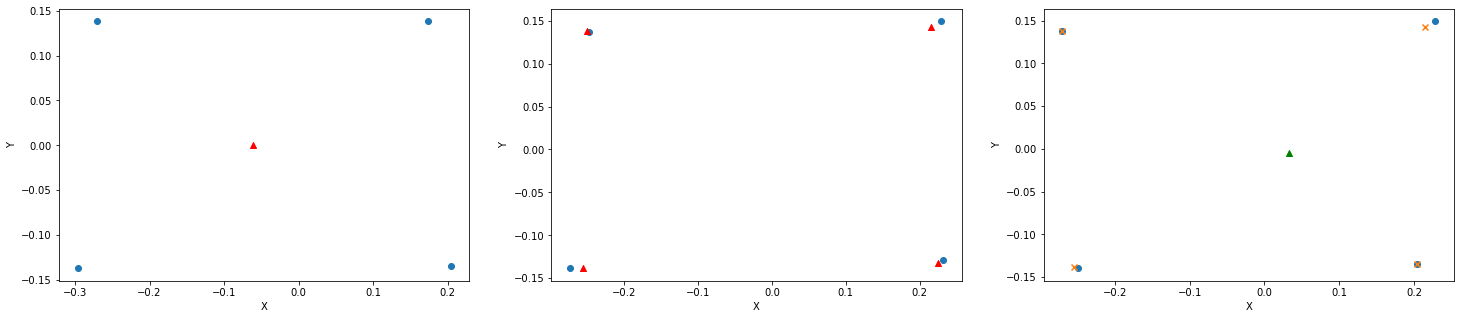

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.1648691  0.01329401]


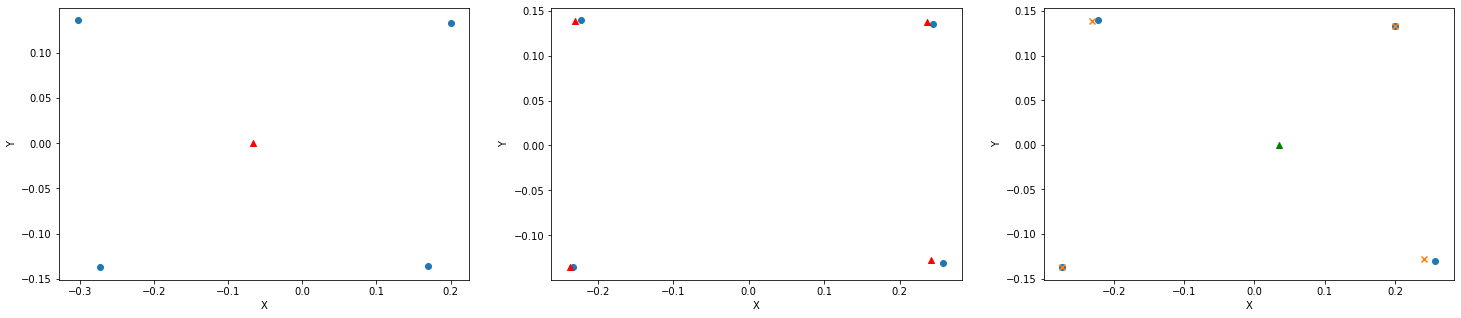

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [0.13365075 0.00827807]


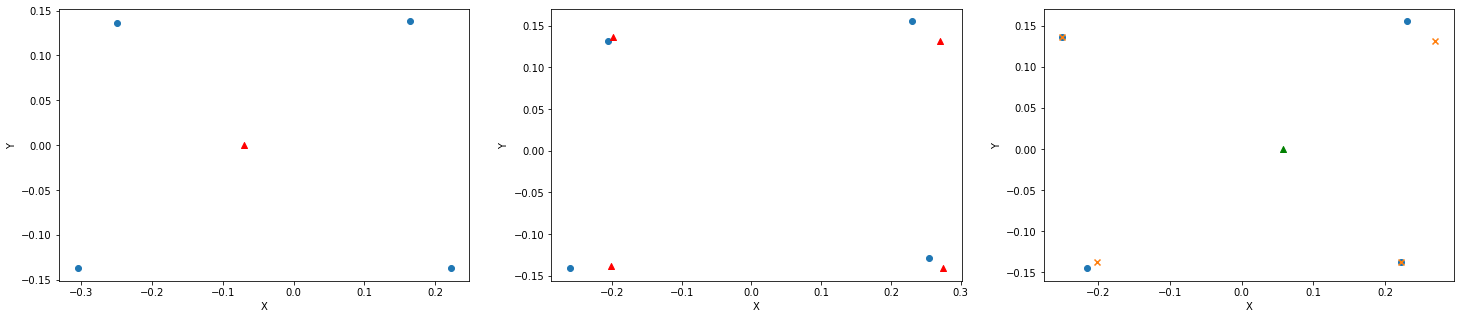

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07012082 -0.00961408]


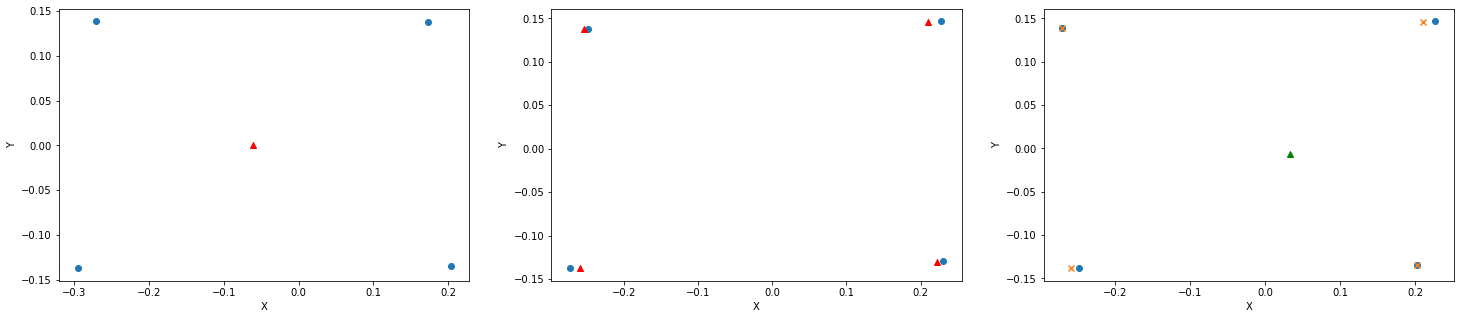

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08174066 0.01634245]


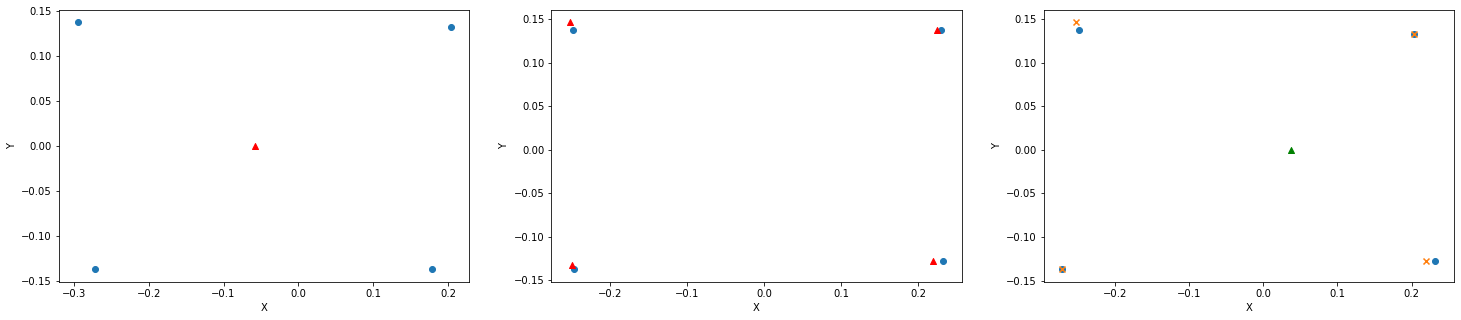

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07388707 -0.00454251]


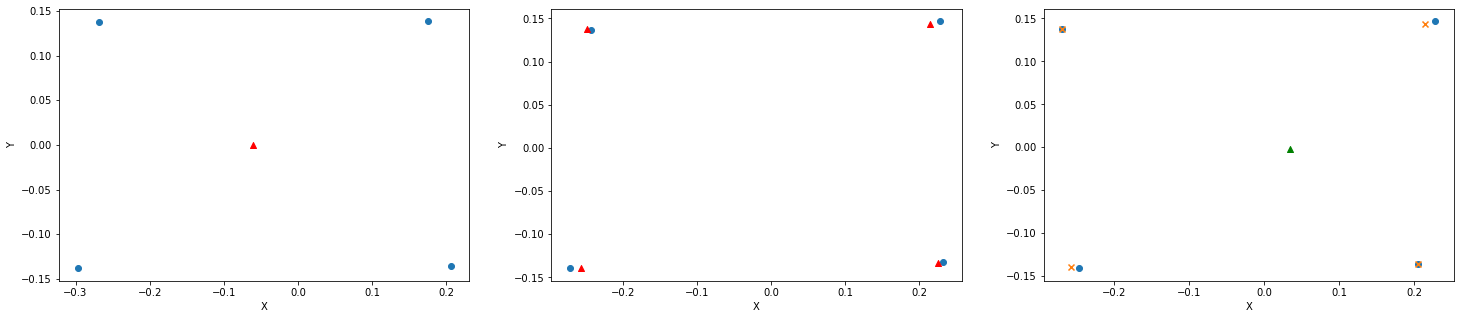

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.06405346 -0.01627887]


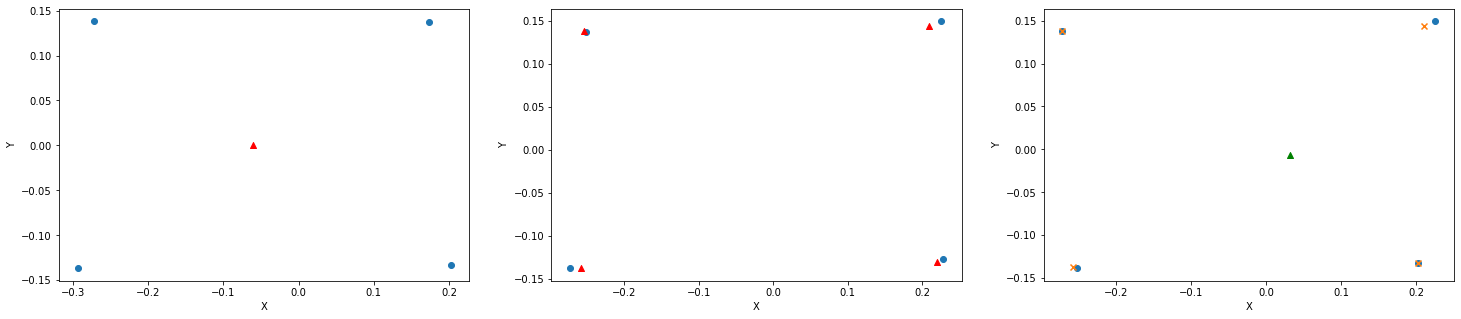

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.0732181  -0.01304736]


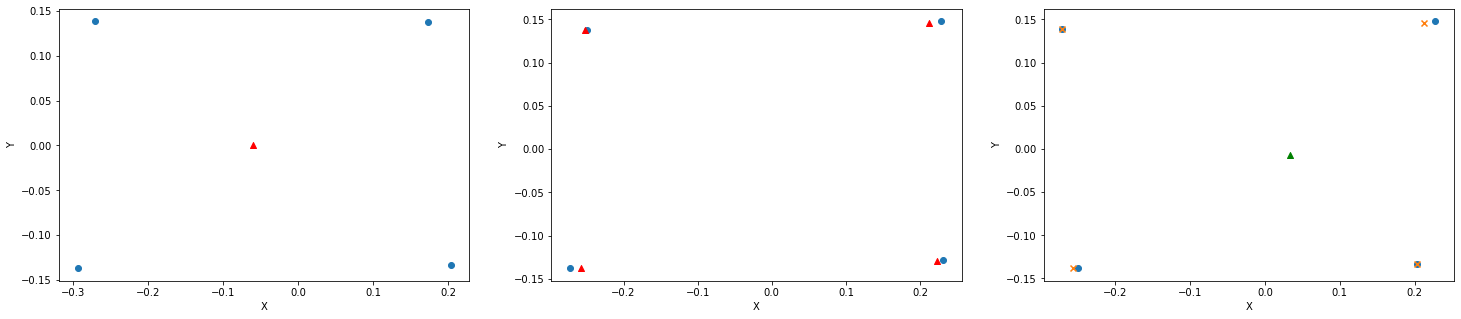

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.1025313  -0.00693138]


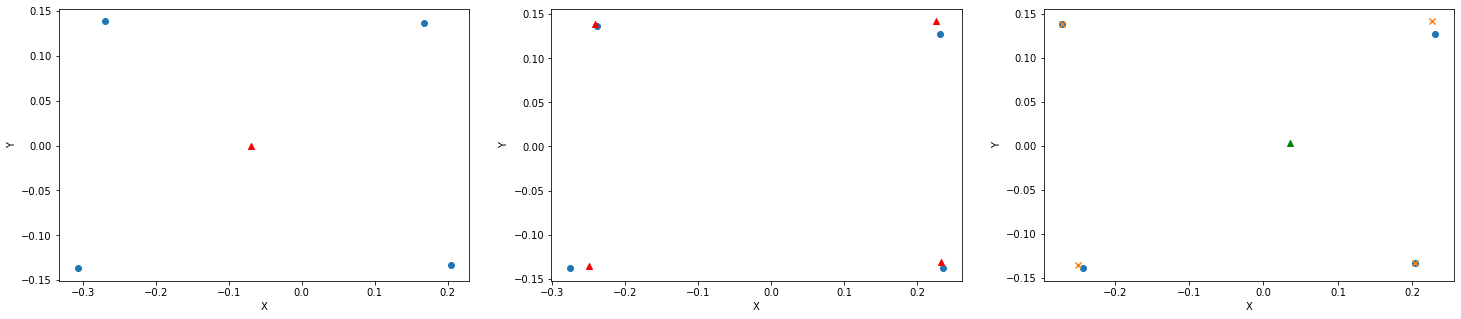

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08284291 -0.0060775 ]


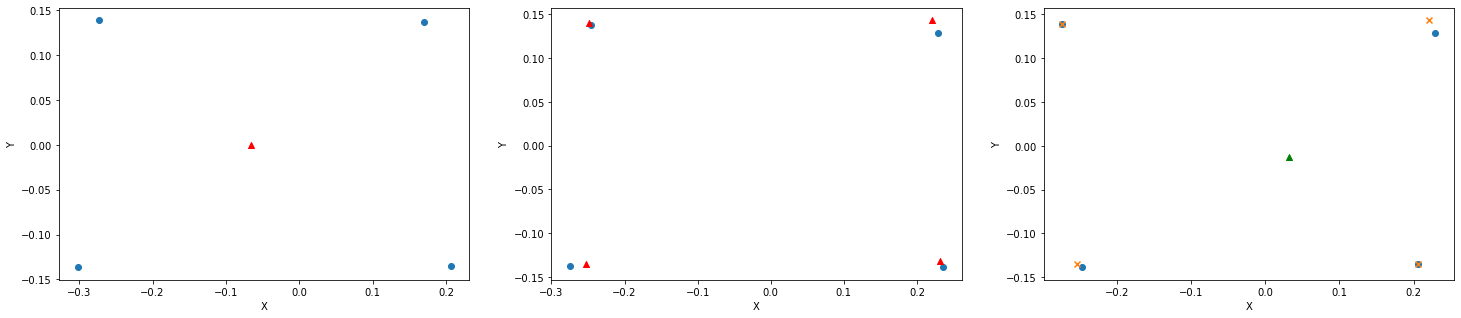

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0994711  0.00289442]


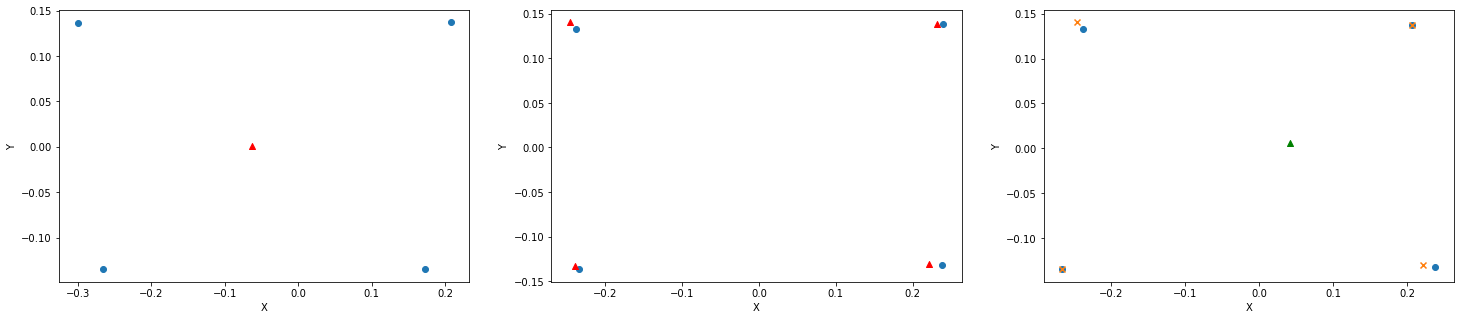

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08520606 0.0122368 ]


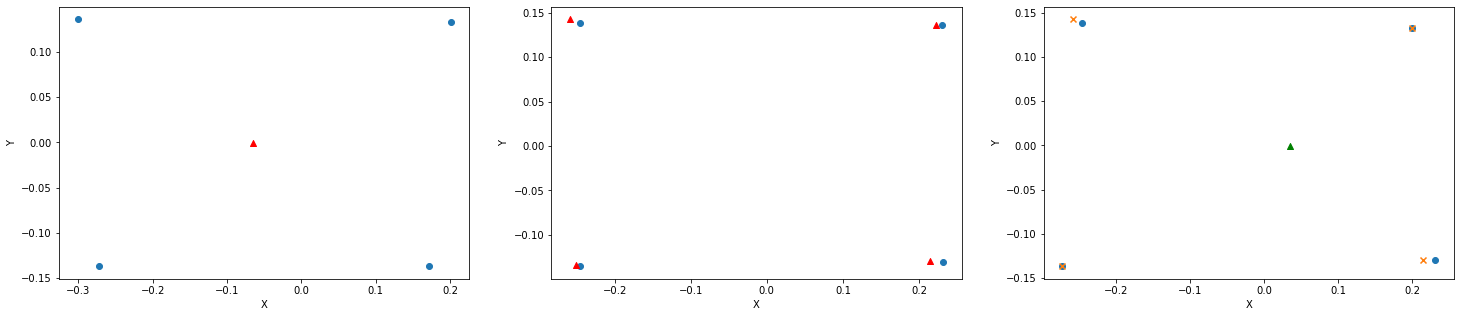

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07882924 -0.03154897]


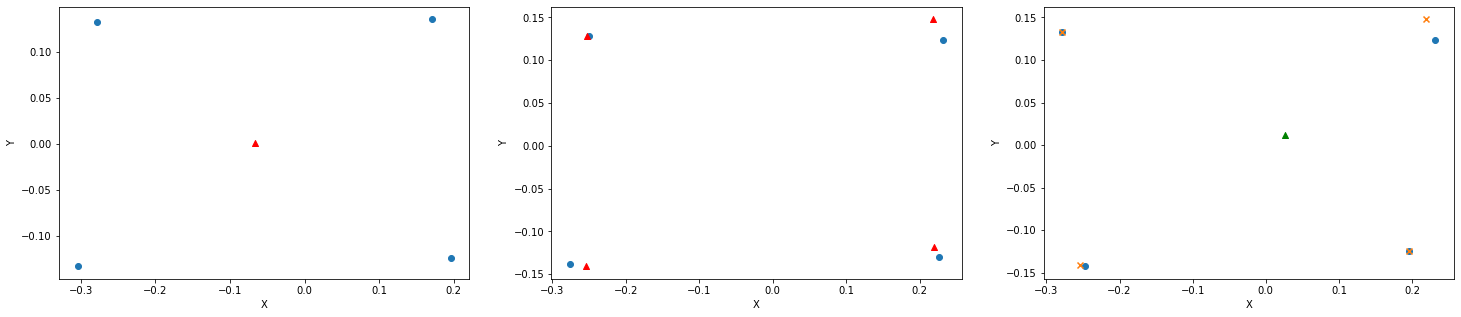

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.0721121  0.00577016]


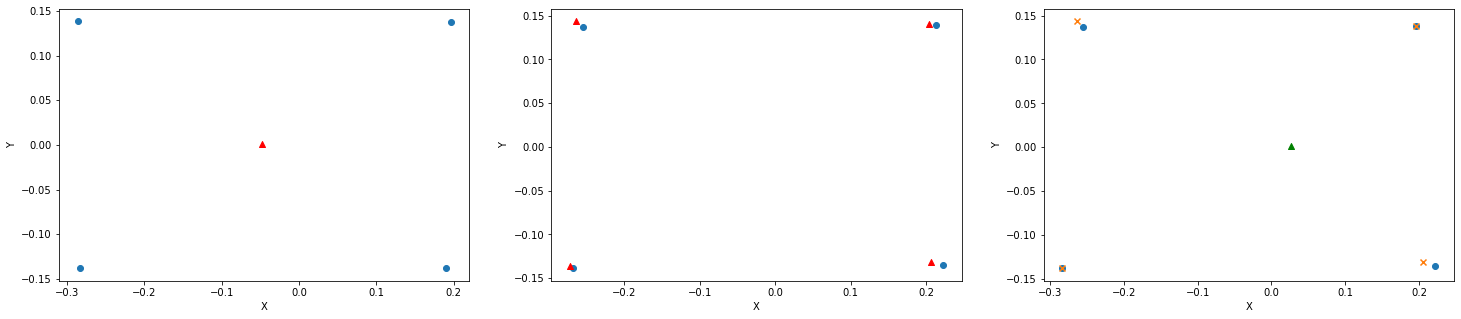

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09761127 -0.00161612]


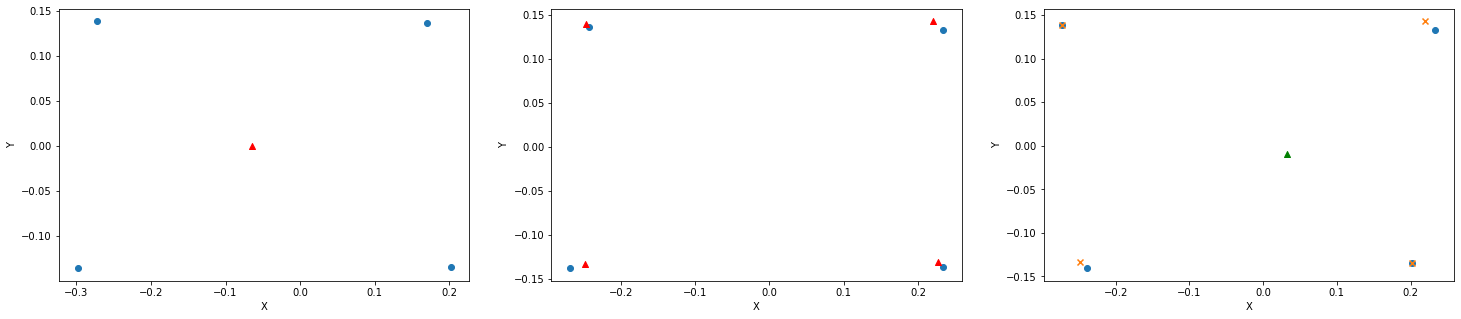

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08639304 0.0191392 ]


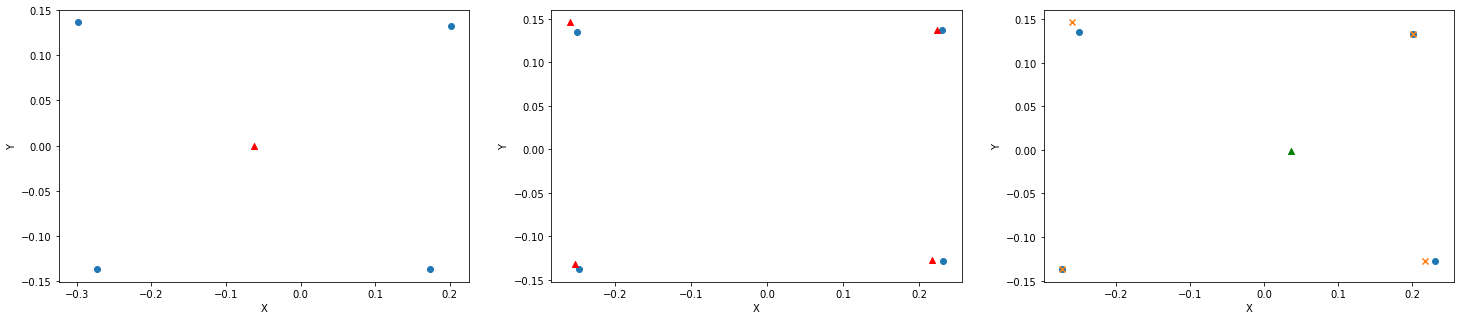

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09962191 -0.00241291]


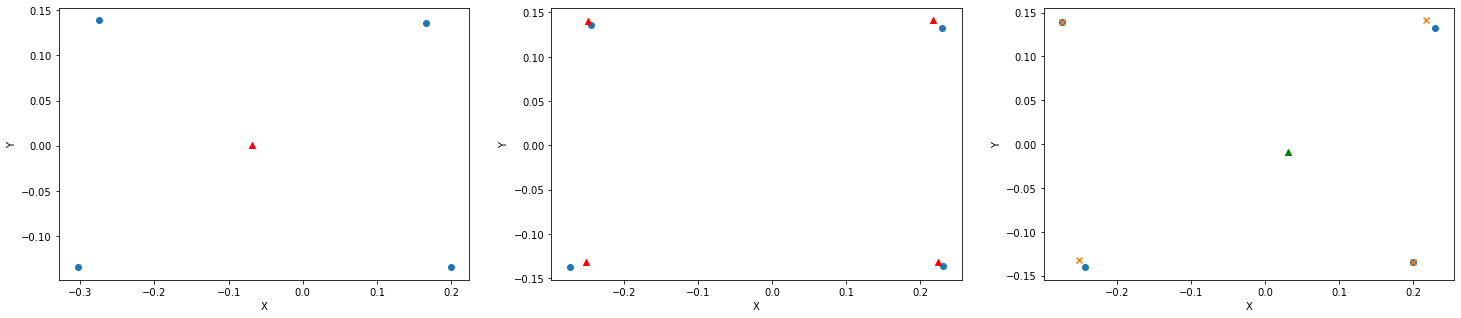

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.10795061 -0.00686456]


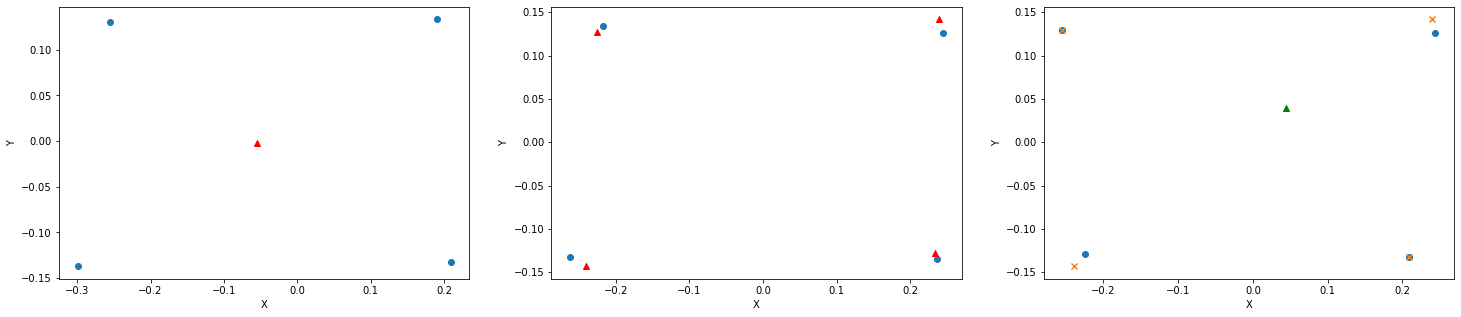

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09394525 0.02388038]


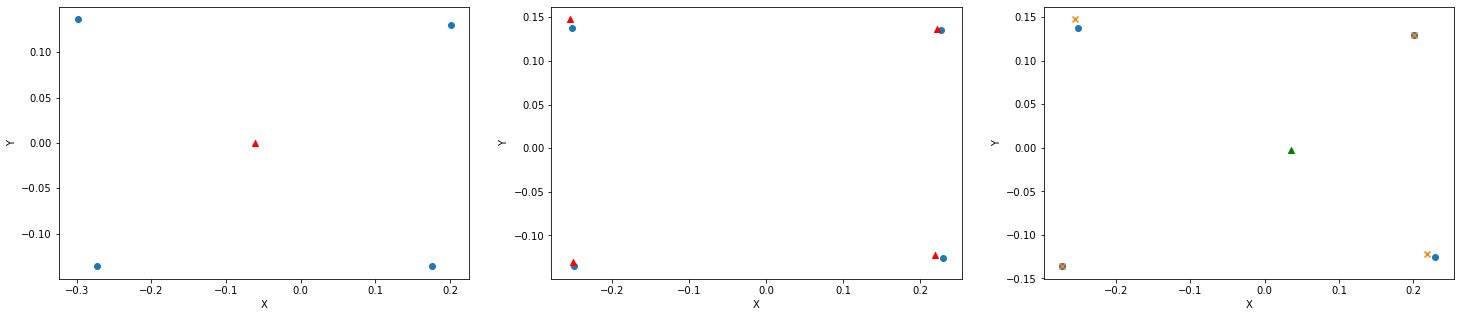

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07091524 -0.00778021]


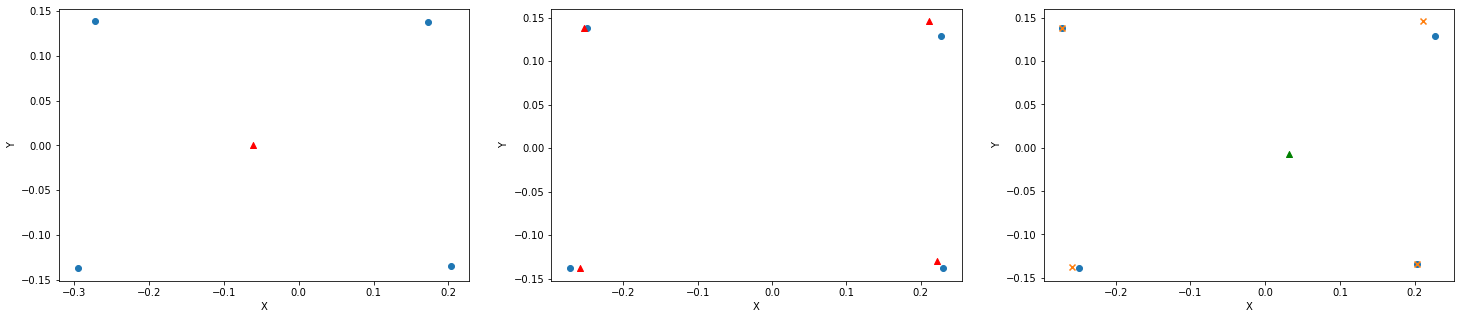

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08931167 0.01038049]


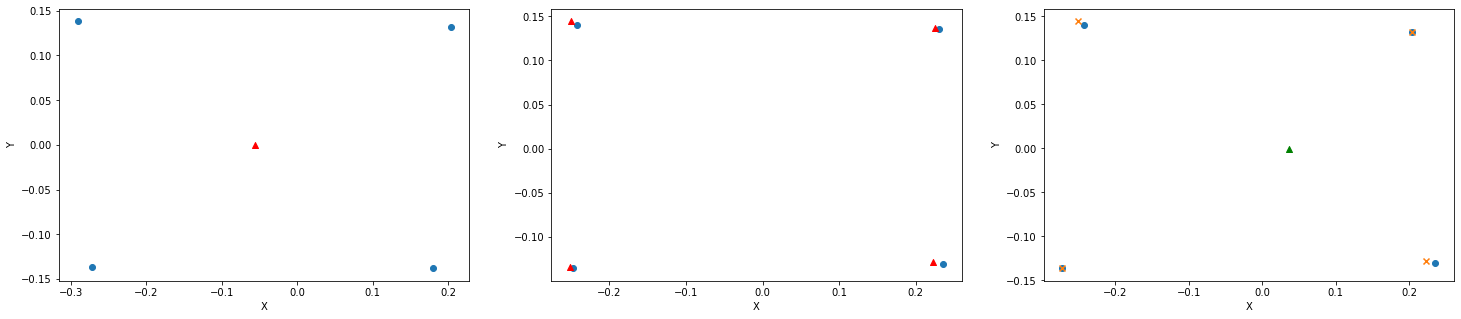

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.22444728 -0.00043174]


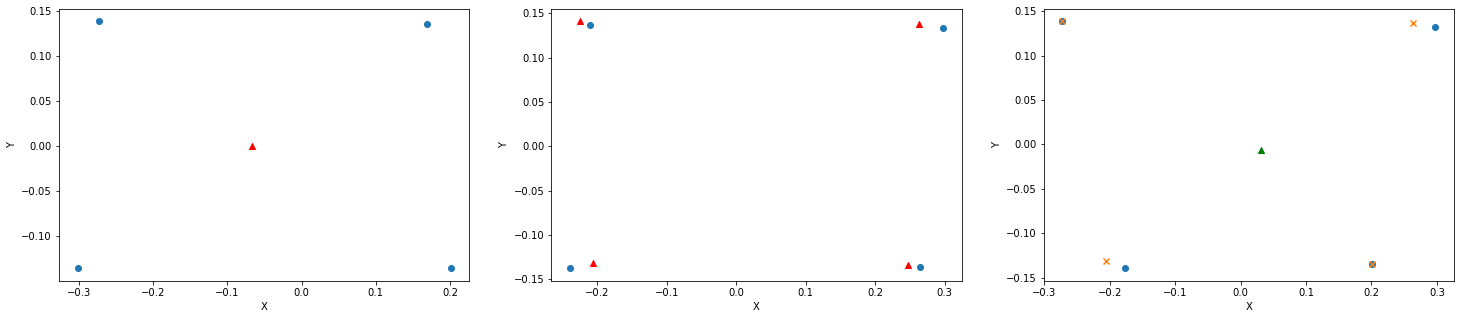

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09450006 -0.01259386]


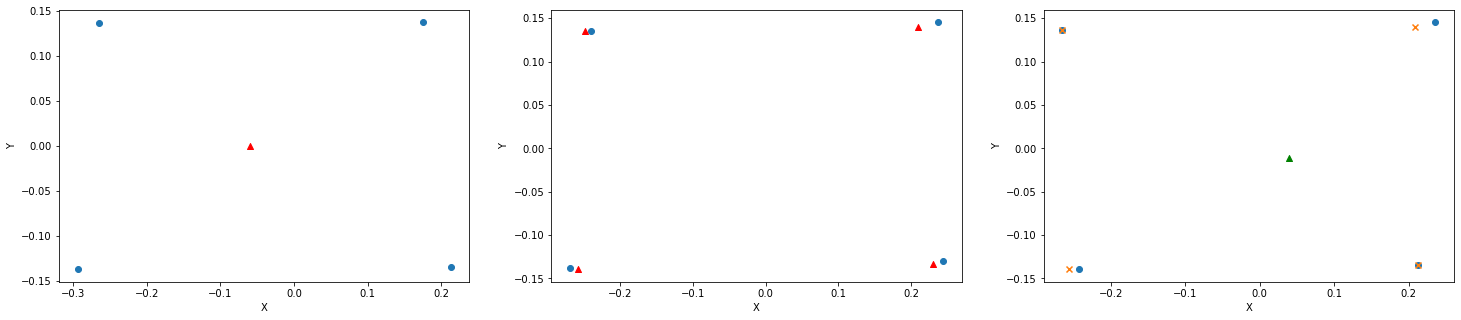

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.05099229 0.03121047]


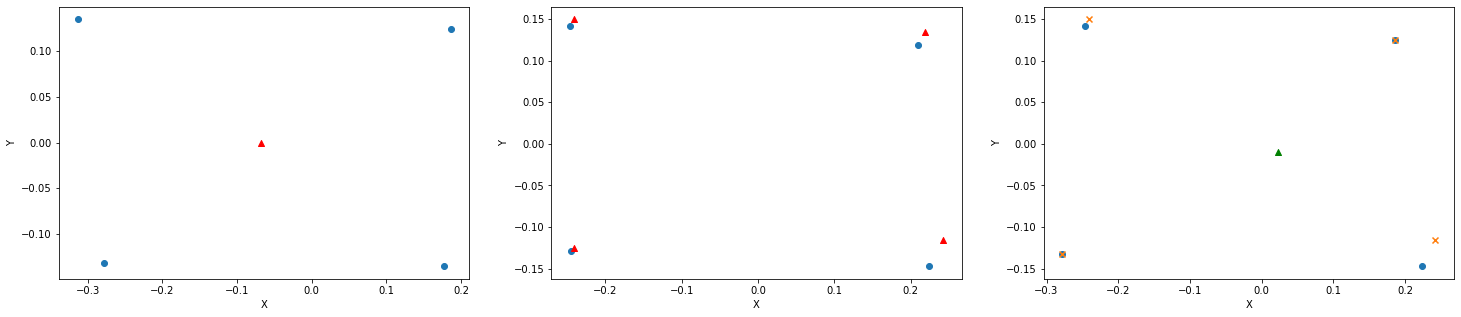

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.10719849 0.00494386]


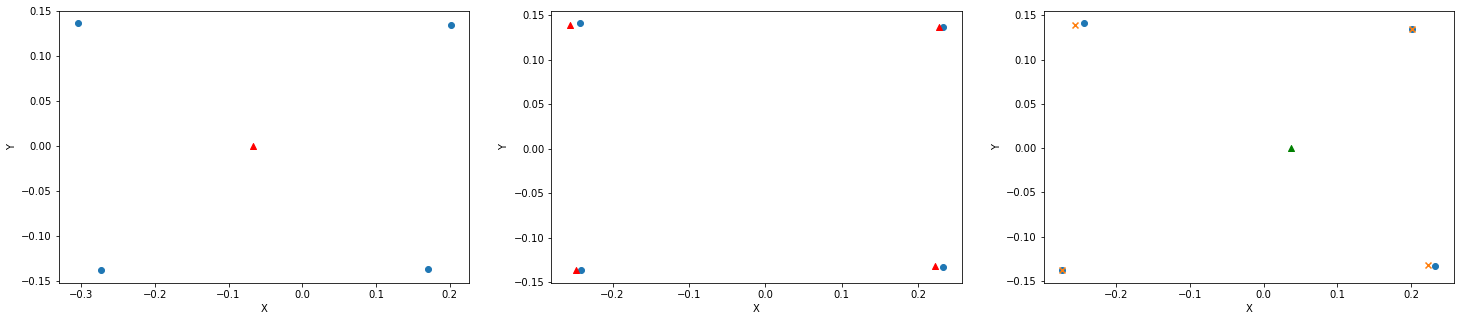

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.06912073 -0.00897215]


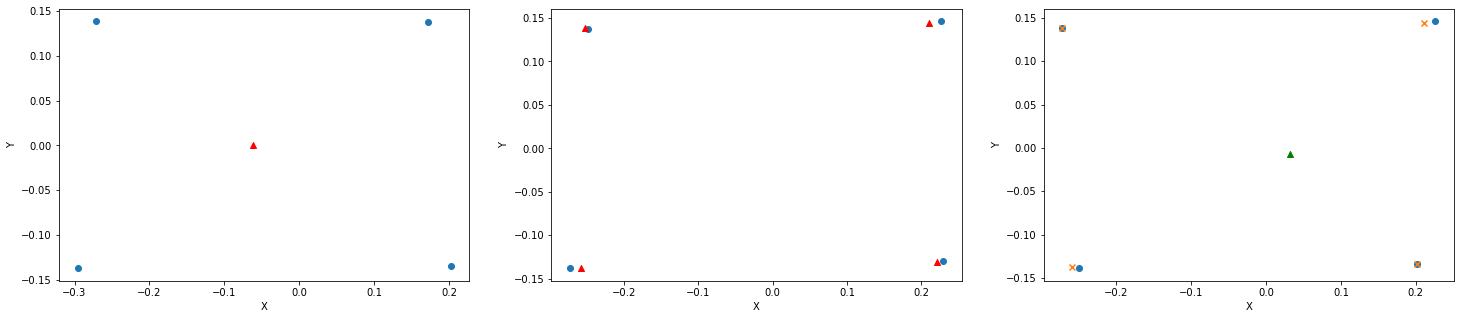

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.06642499 -0.01020476]


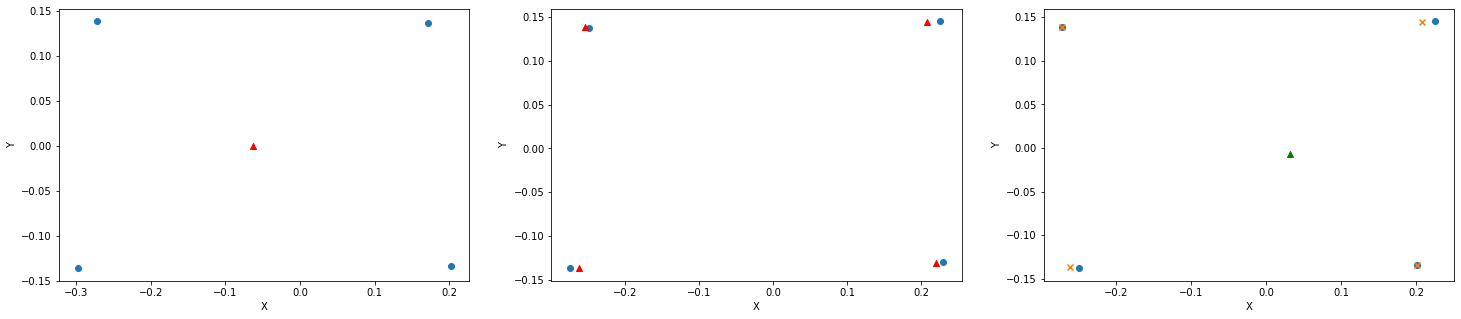

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.1158946  0.00427501]


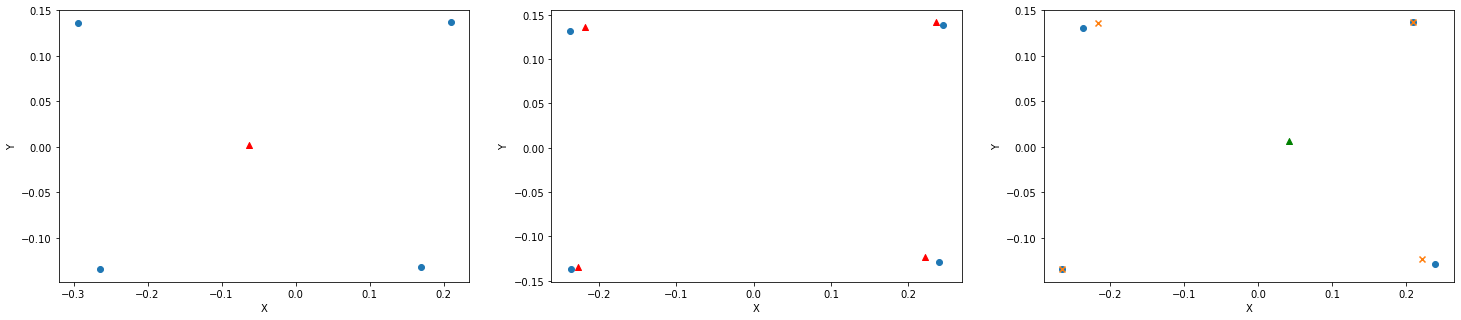

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09761127 -0.00161612]


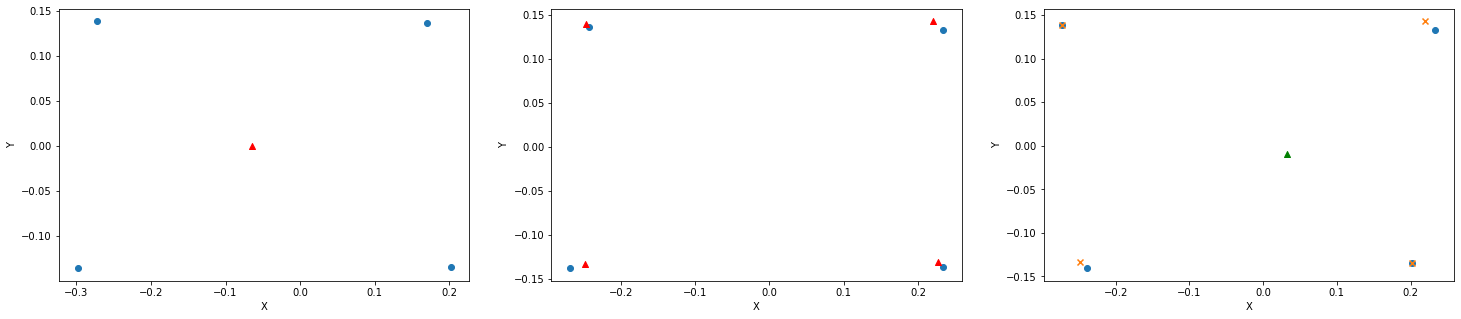

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07695755 -0.00867233]


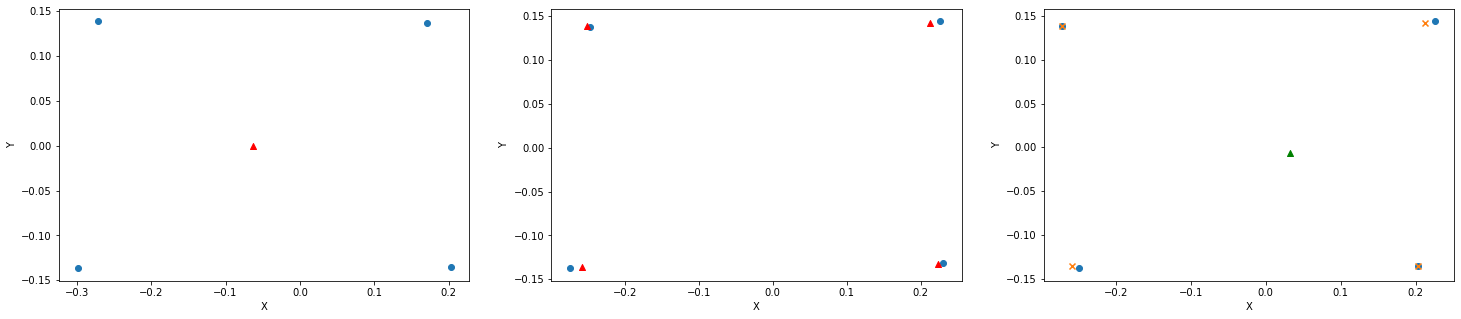

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09473612 0.02177341]


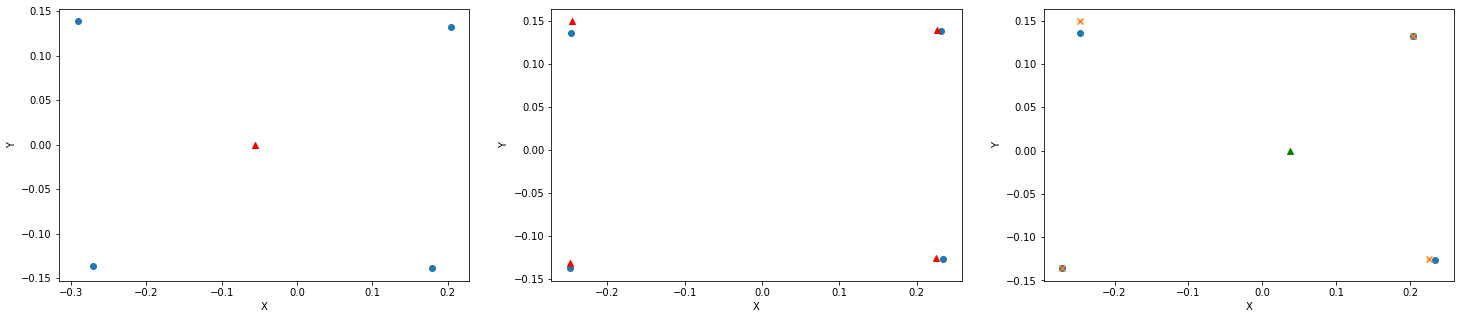

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09464283 0.01718134]


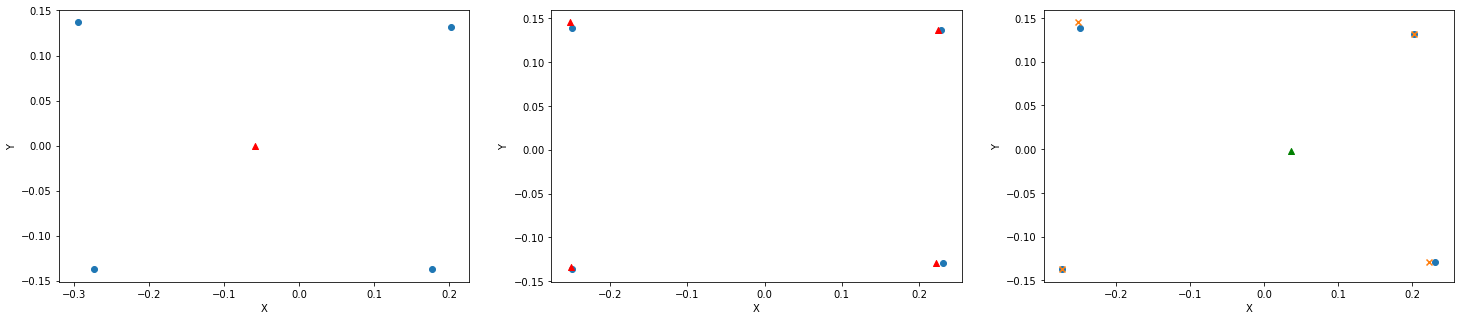

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09488965 0.0119432 ]


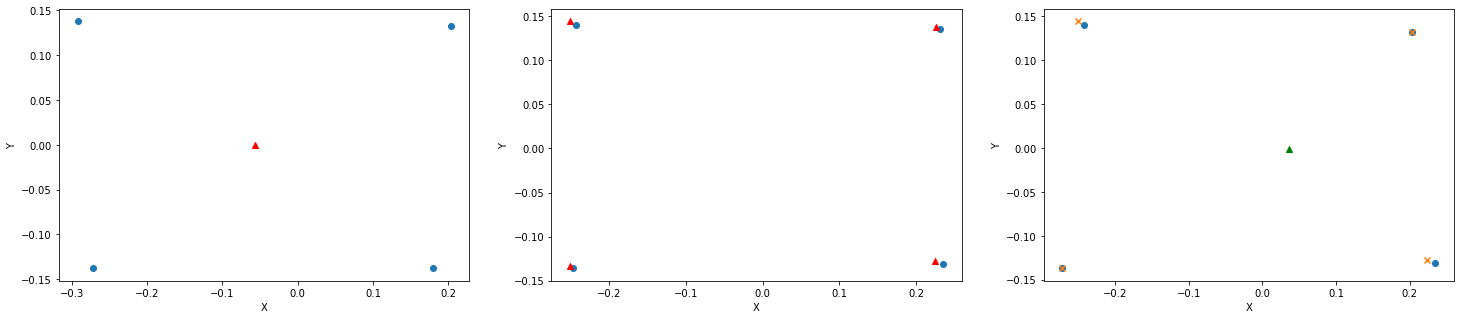

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.11537957 -0.01119805]


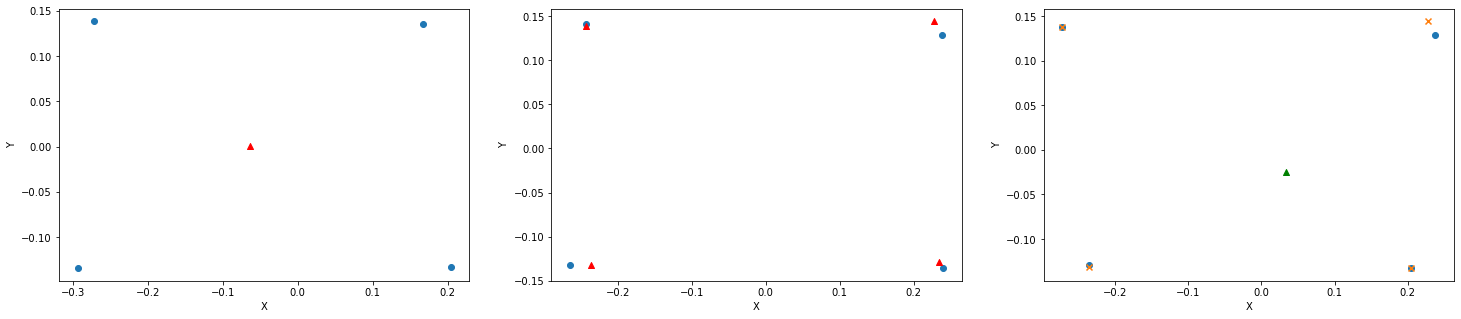

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.33335302 0.01681094]


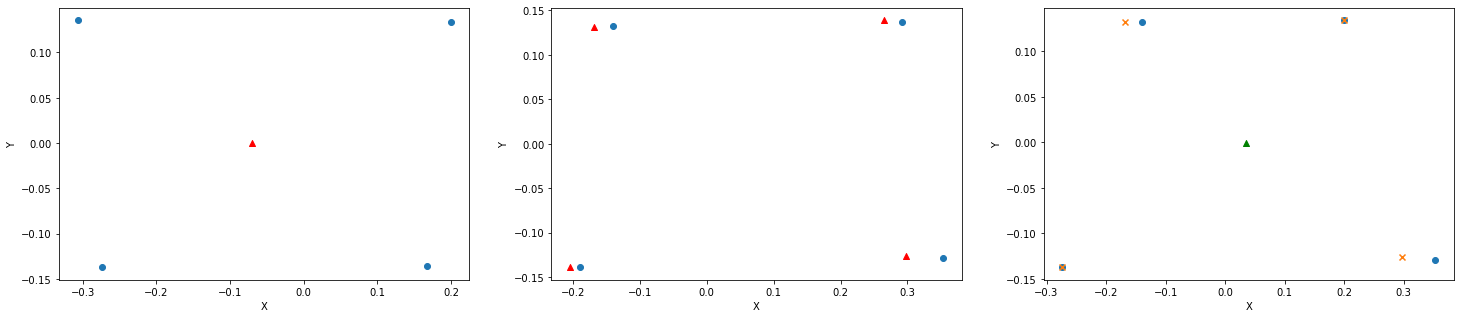

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09394525 0.02388038]


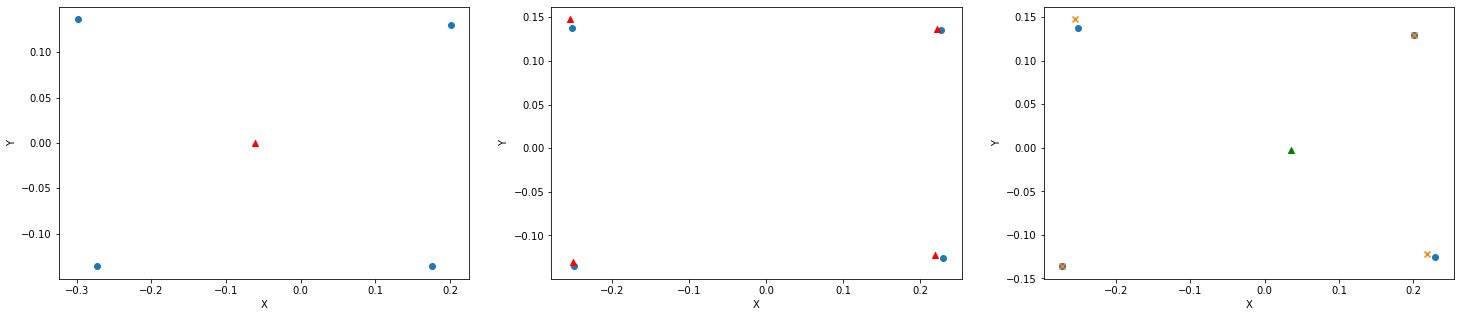

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07049346 -0.00831864]


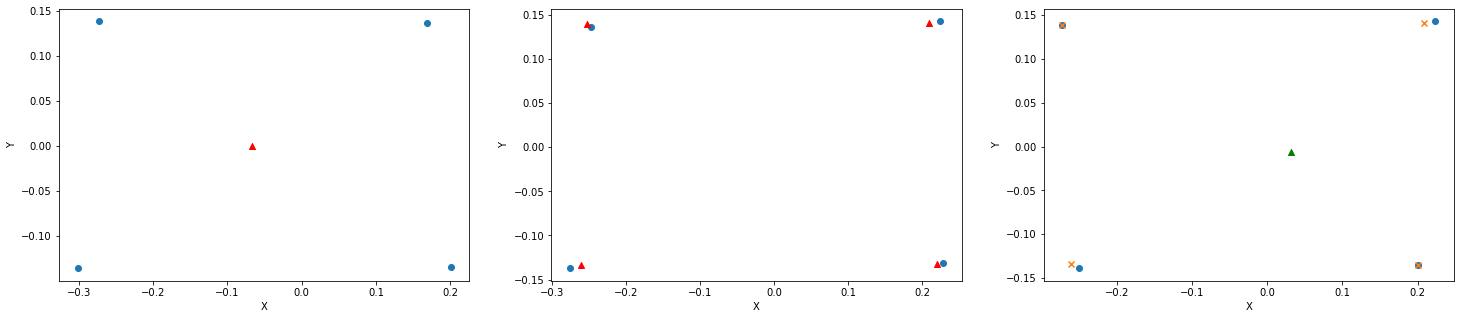

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07120657 -0.0090529 ]


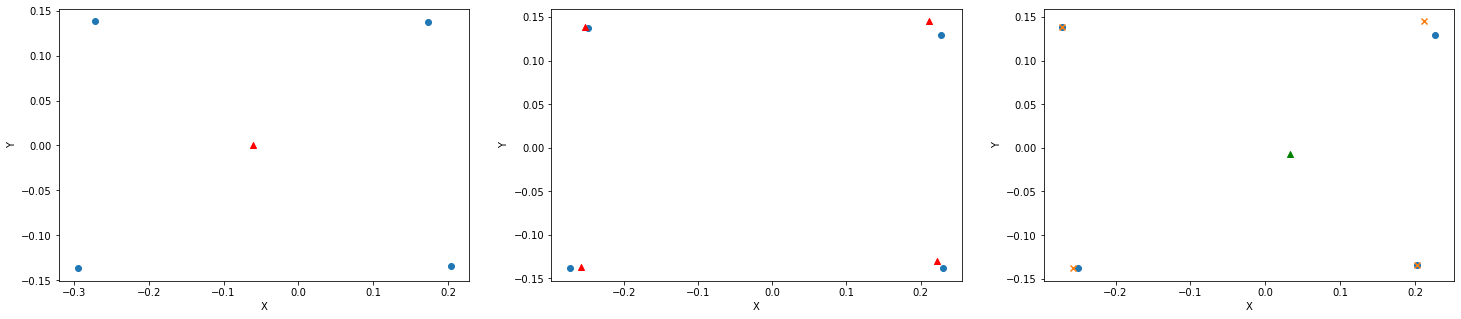

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.09330722 0.01797735]


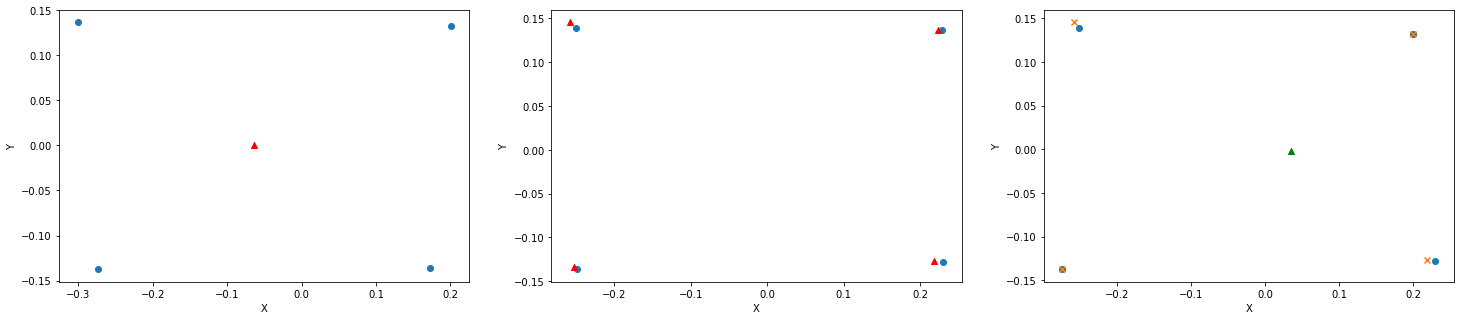

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09678889 -0.00357051]


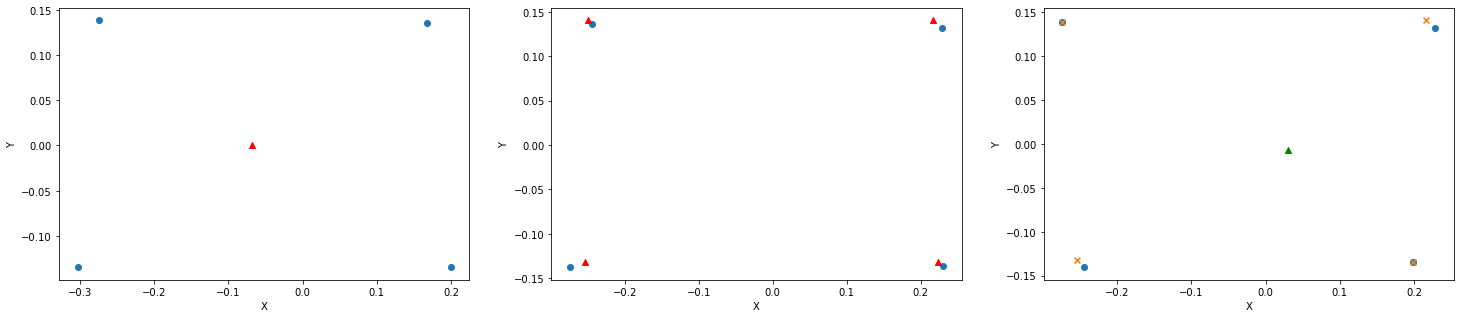

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.17289562 -0.01282563]


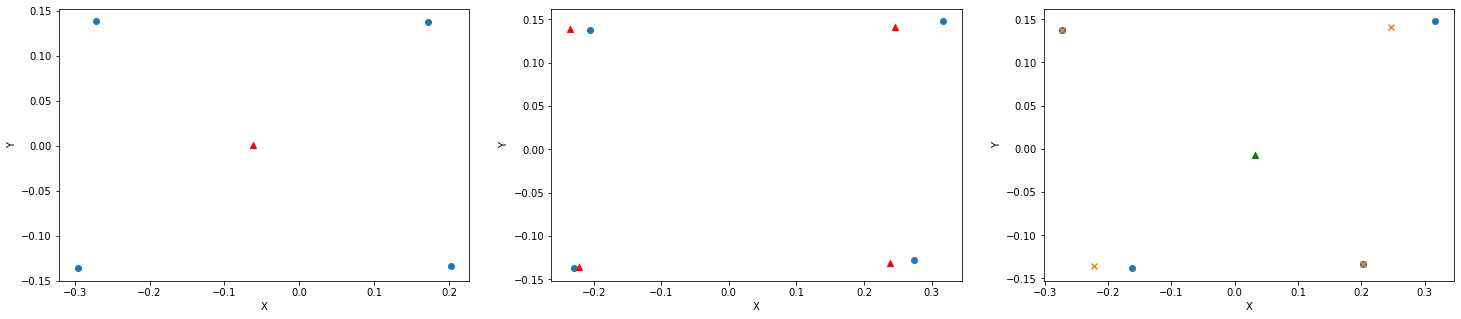

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07455317 -0.00890097]


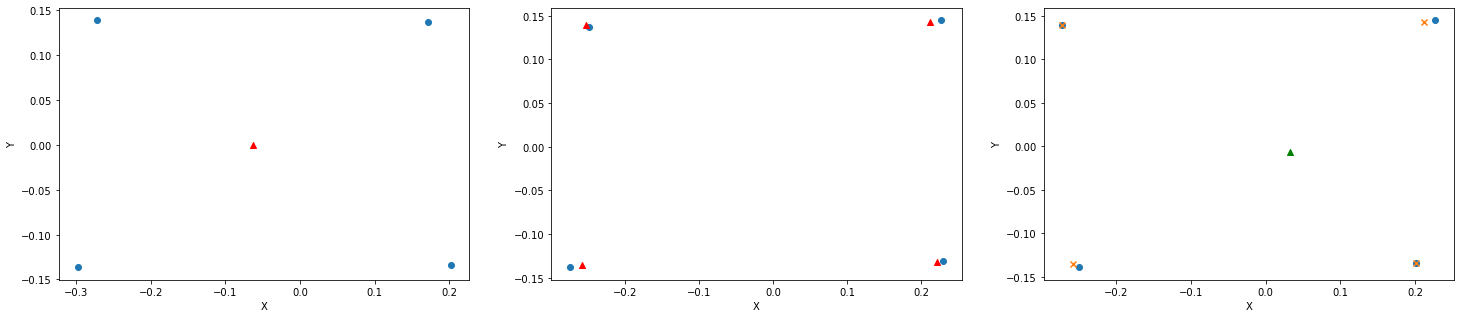

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09097079 -0.01457652]


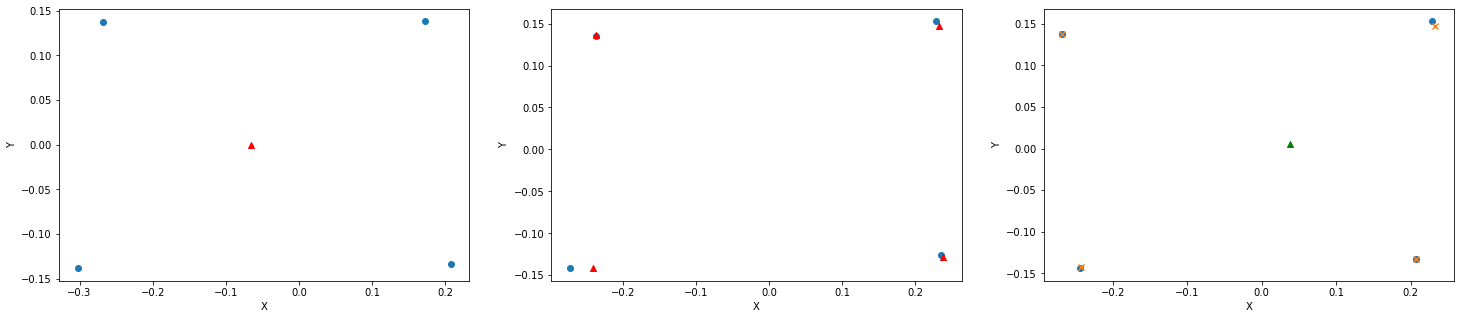

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.11083745 -0.00445496]


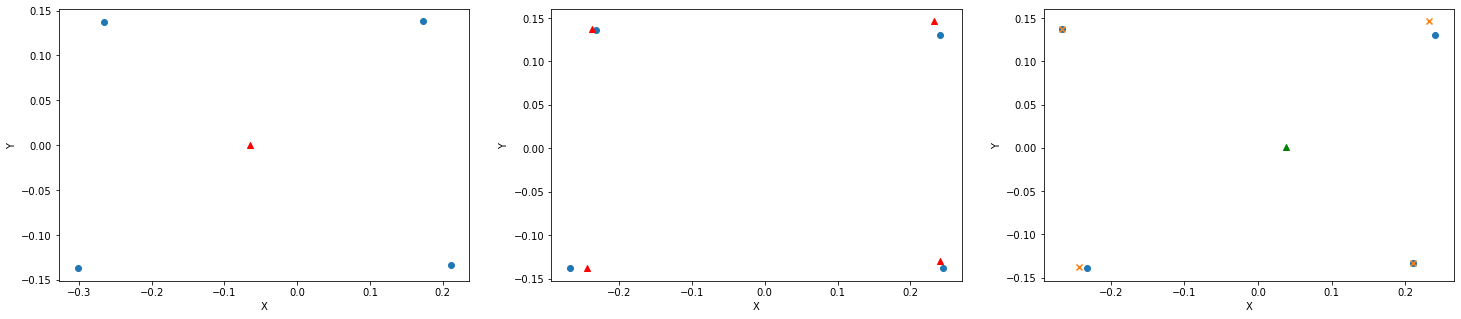

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09045344 -0.00674871]


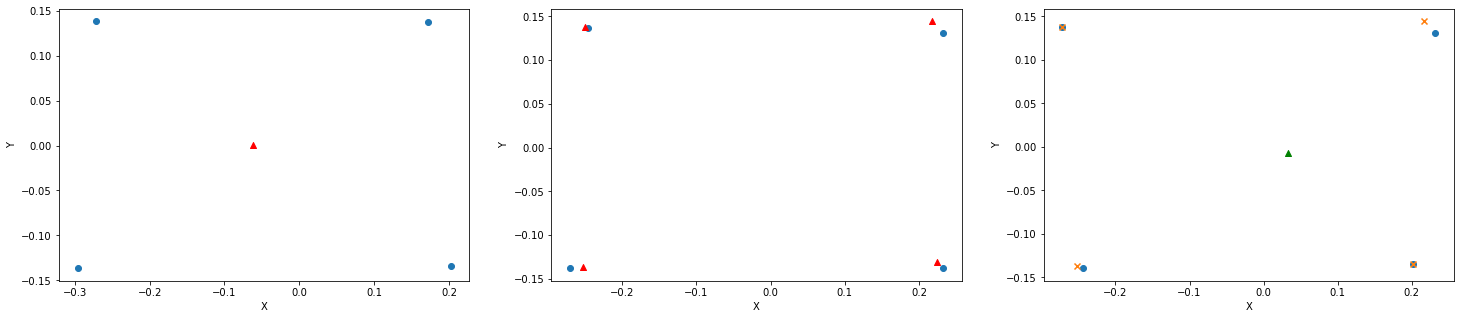

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07584281 -0.01245345]


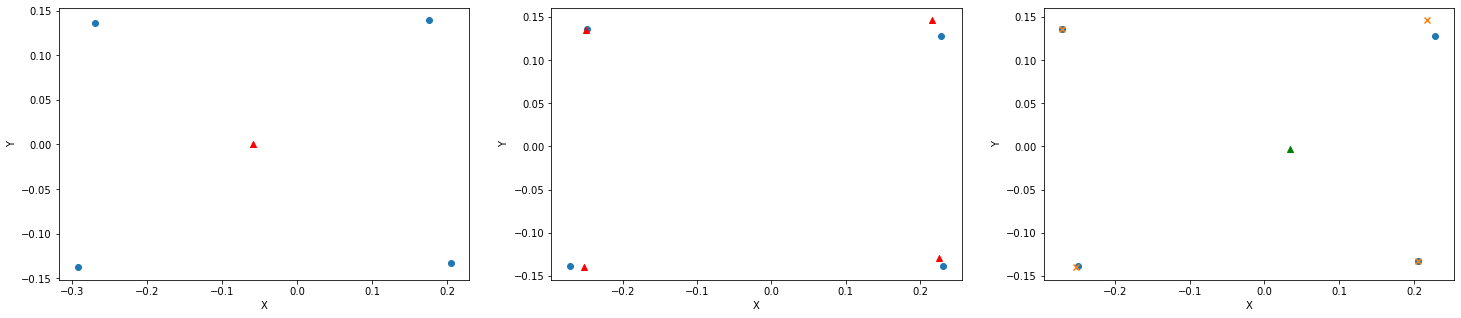

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.10558378 -0.00351362]


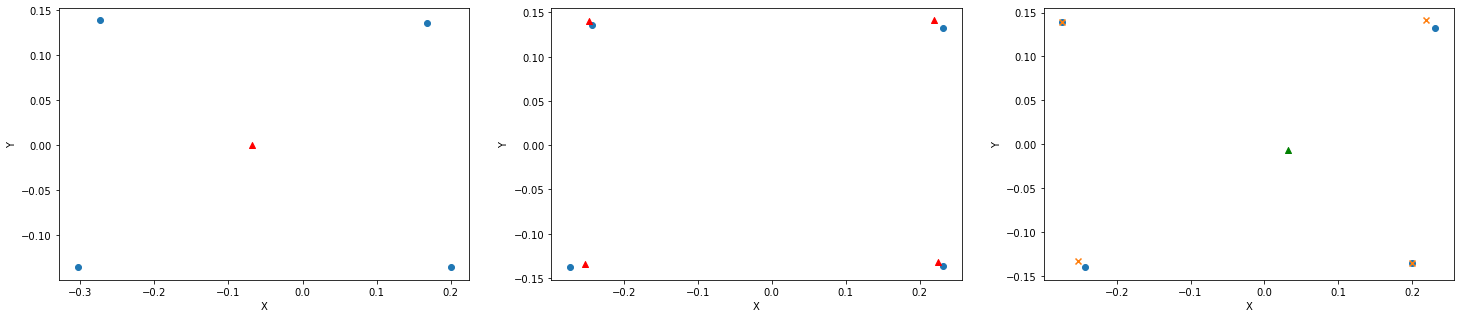

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09538117 -0.00842431]


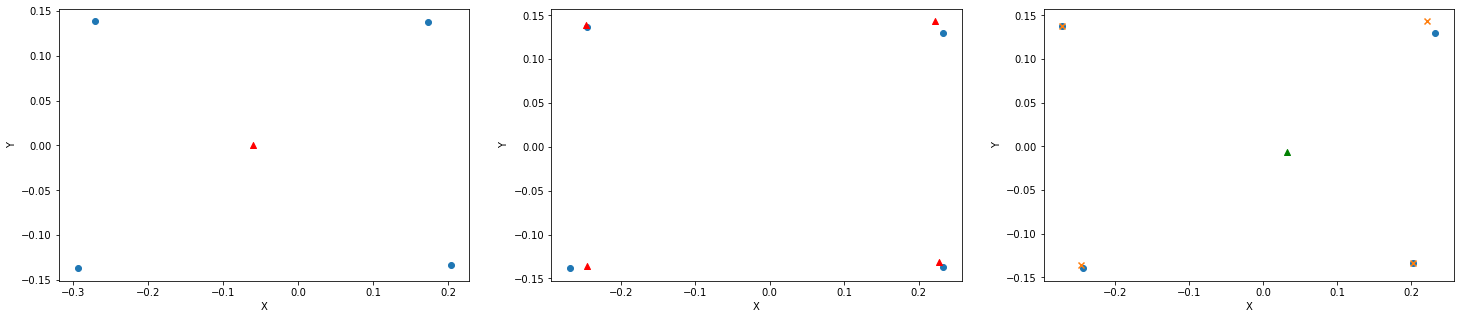

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07032444 -0.01101392]


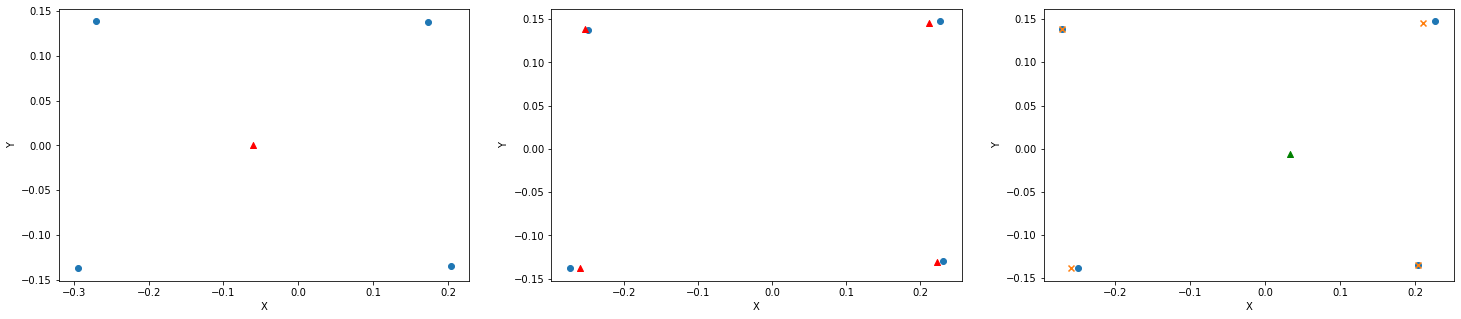

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07012082 -0.00961408]


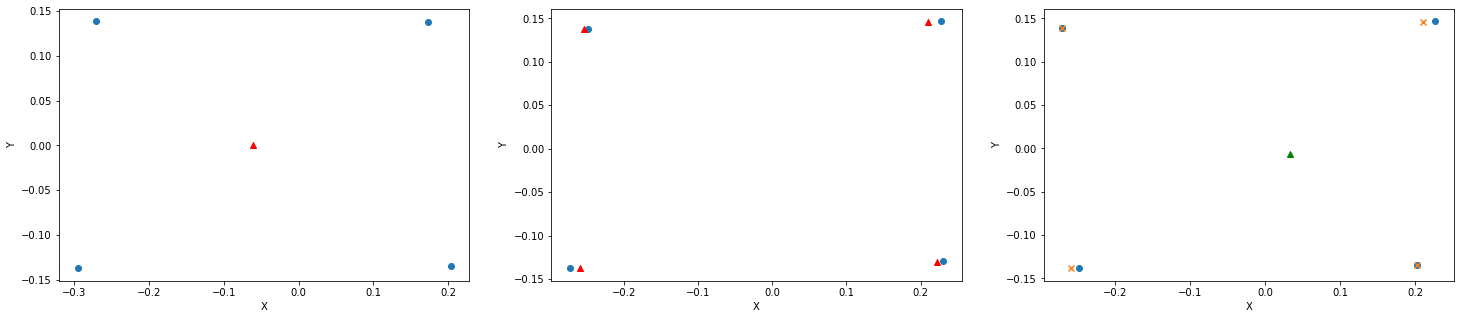

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.06446833 -0.00820052]


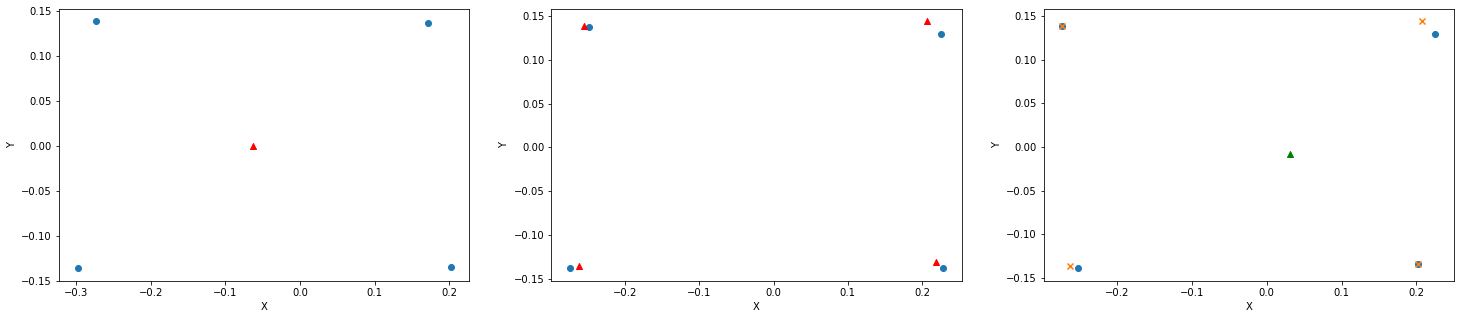

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [0.06736716 0.00028378]


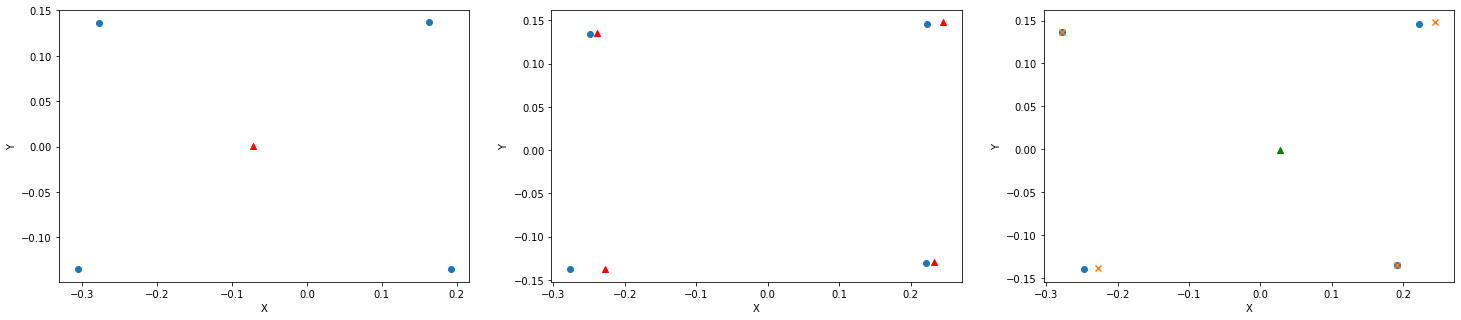

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.05447737 0.05175315]


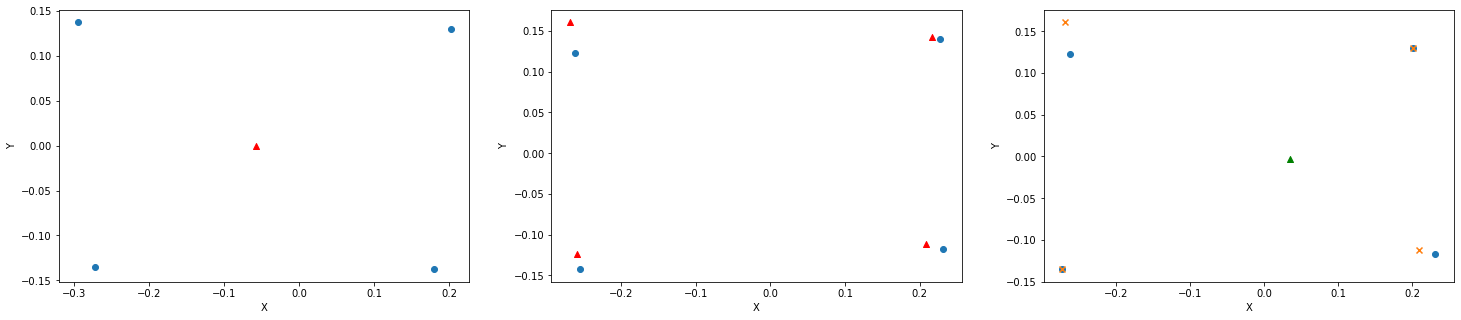

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07703422 -0.01234831]


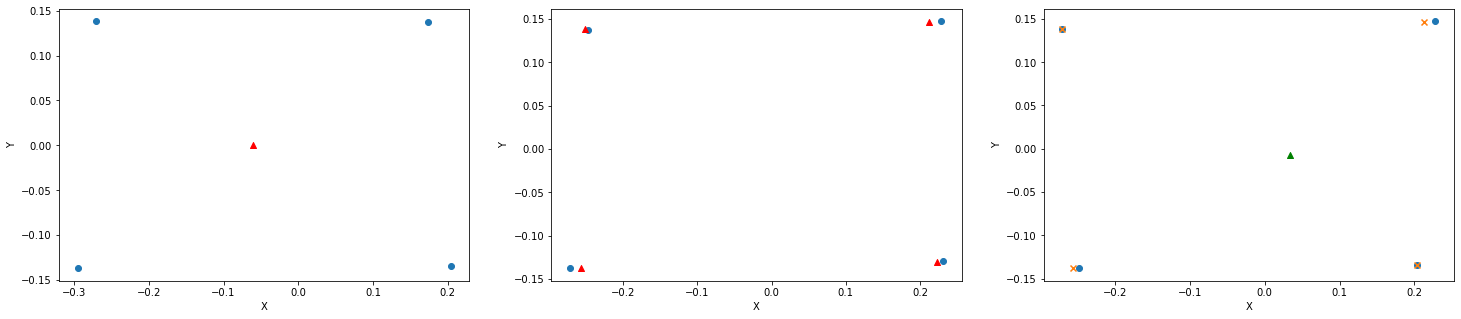

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.08983584 0.01427072]


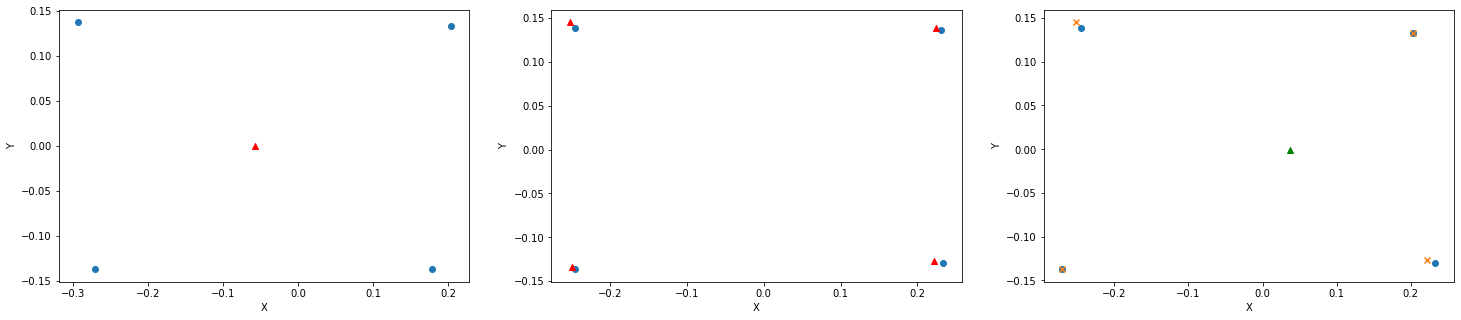

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.07674604 -0.00871003]


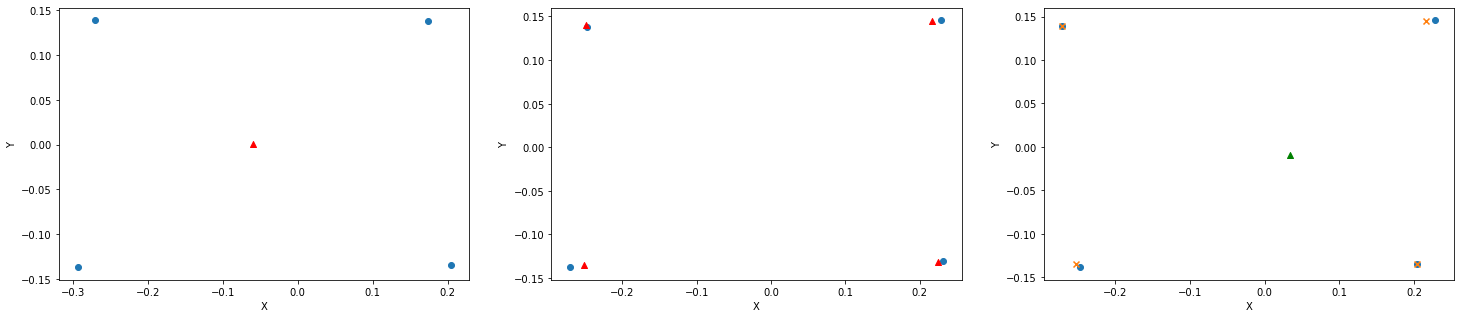

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.08348848 -0.00761735]


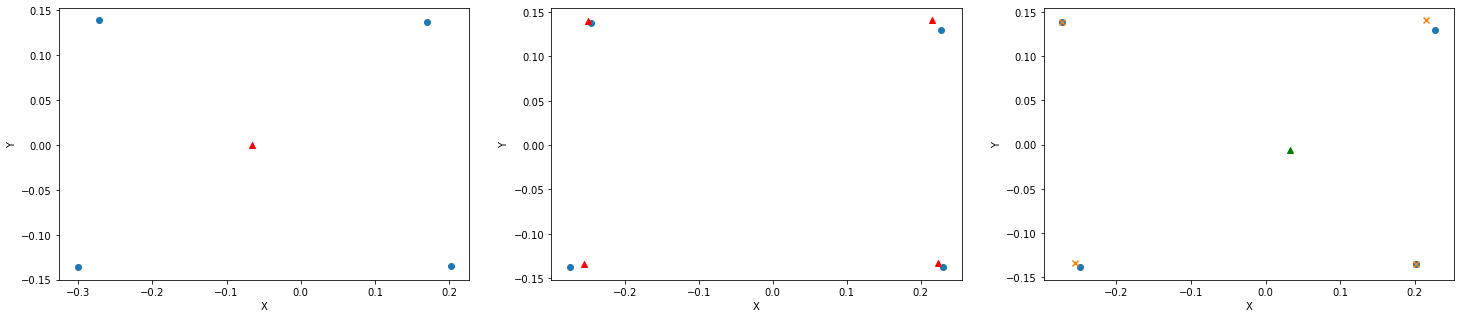

[0.1, 0.0, 0.0] [1. 0.]
CoM velocity:  [0.05399825 0.00159217]


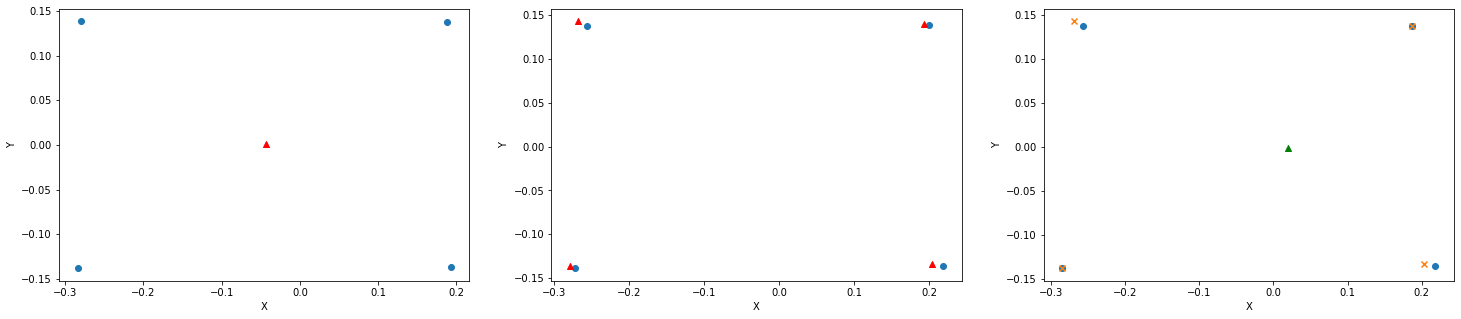

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.17641029 -0.01679673]


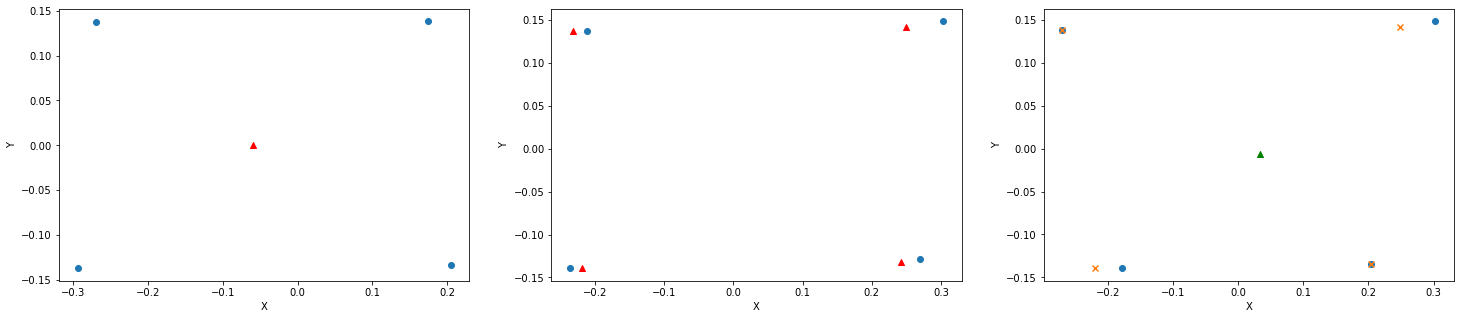

[0.1, 0.0, 0.0] [0. 1.]
CoM velocity:  [ 0.09177188 -0.0010514 ]


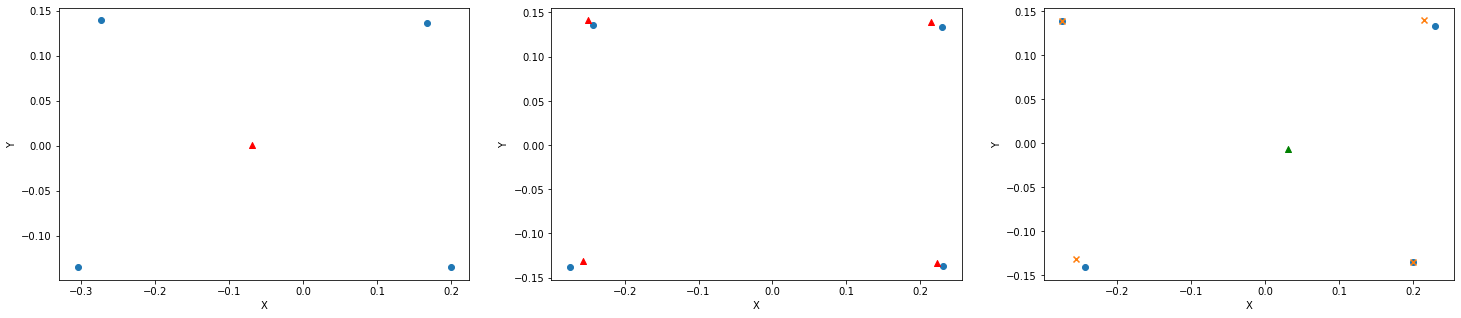

[0.1, 0.0, 0.0] [0. 1.]


KeyboardInterrupt: 

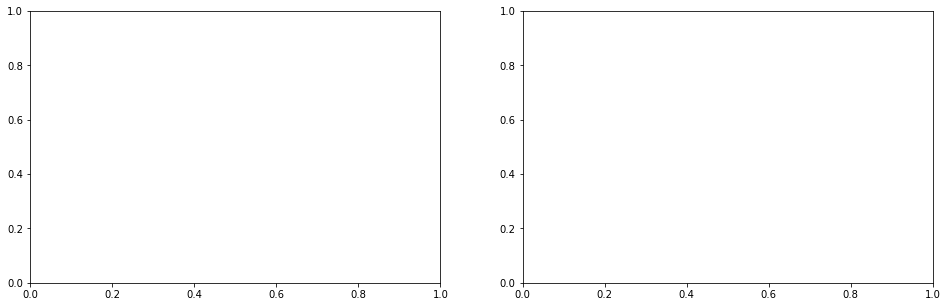

In [28]:
# Visualize footsteps
#for x in range(X_motion_step.shape[0]):        
while True:
    x = np.random.randint(0, X_motion_step.shape[0])
    
    if not X_motion_step[x, 0] == 0.1:
        continue
        
    print(X_motion_step[x, :2].tolist() + [X_motion_step[x, 5]], X_motion_step[x, 24:26])
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    
    # Starting posiitons
    fl_x = X_motion_step[x, 12]
    fl_y = X_motion_step[x, 13]
    fr_x = X_motion_step[x, 15]
    fr_y = X_motion_step[x, 16]
    rl_x = X_motion_step[x, 18]
    rl_y = X_motion_step[x, 19]
    rr_x = X_motion_step[x, 21]
    rr_y = X_motion_step[x, 22]
    
    # Footstep sizes (predictions)
    fl_predicted_movement_x = 0
    fl_predicted_movement_y = 0
    fr_predicted_movement_x = 0 
    fr_predicted_movement_y = 0
    rl_predicted_movement_x = 0 
    rl_predicted_movement_y = 0
    rr_predicted_movement_x = 0 
    rr_predicted_movement_y = 0
    
    # Footstep sizes (targets)
    fl_target_movement_x = Y_motion_step[x, 0]
    fl_target_movement_y = Y_motion_step[x, 1]
    fr_target_movement_x = Y_motion_step[x, 2]
    fr_target_movement_y = Y_motion_step[x, 3]
    rl_target_movement_x = Y_motion_step[x, 4]
    rl_target_movement_y = Y_motion_step[x, 5]
    rr_target_movement_x = Y_motion_step[x, 6]
    rr_target_movement_y = Y_motion_step[x, 7]
    
    # CoM
    prev_com = [0, 0]
    curr_com = [0, 0]
    target_com = [0, 0]
    predicted_com = [0, 0]
    
    print("CoM velocity: ", X_motion_step[x, 34:36])
    
    # FR and RL moving
    if X_motion_step[x, 24]:
        input_fr_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 28], X_motion_step[x, 26], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        fr_predicted_movement_x = model_fr_x.predict(input_fr_x)
        
        input_fr_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 29], X_motion_step[x, 27], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        fr_predicted_movement_y = model_fr_y.predict(input_fr_y)
        
        input_rl_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 30], X_motion_step[x, 32], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        rl_predicted_movement_x = model_rl_x.predict(input_rl_x)
        
        input_rl_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 31], X_motion_step[x, 33], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        rl_predicted_movement_y = model_rl_y.predict(input_rl_y)
        
        input_com_fr_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[0] = model_fr_com_x.predict(input_com_fr_x)
        
        input_com_fr_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[1] = model_fr_com_y.predict(input_com_fr_y)
        
        print(f'FR x velocity: {fr_predicted_movement_x/0.34}')
        
        point1 = [fr_x + fr_predicted_movement_x, fr_y + fr_predicted_movement_y]
        point2 = [rl_x + rl_predicted_movement_x, rl_y + rl_predicted_movement_y]
        prev_com[0] = (fr_x + rl_x) / 2
        prev_com[1] = (fr_y + rl_y) / 2
        curr_com[0] = (point1[0] + point2[0]) / 2
        curr_com[1] = (point1[1] + point2[1]) / 2
        target_com[0] = (fr_x + fr_target_movement_x + rl_x + rl_target_movement_x) / 2
        target_com[1] = (fr_y + fr_target_movement_y + rl_y + rl_target_movement_y) / 2
    # FL and RR moving
    else:
        input_fl_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 26], X_motion_step[x, 28], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        fl_predicted_movement_x = model_fl_x.predict(input_fl_x)
        
        input_fl_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 27], X_motion_step[x, 29], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        fl_predicted_movement_y = model_fl_y.predict(input_fl_y)
        
        input_rr_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 32], X_motion_step[x, 30], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        rr_predicted_movement_x = model_rr_x.predict(input_rr_x)
        
        input_rr_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], X_motion_step[x-1, 33], X_motion_step[x, 31], X_motion_step[x, 34], X_motion_step[x, 35]]).reshape(-1, 1).T
        rr_predicted_movement_y = model_rr_y.predict(input_rr_y)
        
        input_com_fl_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[0] = model_fl_com_x.predict(input_com_fl_x)
        
        input_com_fl_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[1] = model_fl_com_y.predict(input_com_fl_y)
        
        point1 = [fl_x + fl_predicted_movement_x, fl_y + fl_predicted_movement_y]
        point2 = [rr_x + rr_predicted_movement_x, rr_y + rr_predicted_movement_y]
        prev_com[0] = (fl_x + rr_x) / 2
        prev_com[1] = (fl_y + rr_y) / 2
        curr_com[0] = (point1[0] + point2[0]) / 2
        curr_com[1] = (point1[1] + point2[1]) / 2
        target_com[0] = (fl_x + fl_target_movement_x + rr_x + rr_target_movement_x) / 2
        target_com[1] = (fl_y + fl_target_movement_y + rr_y + rr_target_movement_y) / 2
        
    # Inputs 3D positions        
    xs_input = np.array([fl_x, fr_x, rl_x, rr_x] ,dtype=object)
    ys_input = np.array([fl_y, fr_y, rl_y, rr_y] ,dtype=object)
    
    # Labels 3D positions        
    xs_targets = np.array([fl_x + fl_target_movement_x, fr_x + fr_target_movement_x, rl_x + rl_target_movement_x, rr_x + rr_target_movement_x] ,dtype=object)
    ys_targets = np.array([fl_y + fl_target_movement_y, fr_y + fr_target_movement_y, rl_y + rl_target_movement_y, rr_y + rr_target_movement_y] ,dtype=object)
    
    # Predictions 3D positions        
    xs_predictions = np.array([fl_x + fl_predicted_movement_x, fr_x + fr_predicted_movement_x, rl_x + rl_predicted_movement_x, rr_x + rr_predicted_movement_x] ,dtype=object)
    ys_predictions = np.array([fl_y + fl_predicted_movement_y, fr_y + fr_predicted_movement_y, rl_y + rl_predicted_movement_y, rr_y + rr_predicted_movement_y] ,dtype=object)
    
    # Idle positions
    xs_idle_targets = None 
    ys_idle_targets = None
    xs_idle_predictions = None
    ys_idle_predictions = None
    
    if X_motion_step[x, 24]:
        # Target idle position
        xs_idle_targets = np.array([fl_x + fr_target_movement_x/2, fr_x + fr_target_movement_x, rl_x + rl_target_movement_x, rr_x + rl_target_movement_x/2] ,dtype=object)
        ys_idle_targets = np.array([fl_y + fr_target_movement_y/2, fr_y + fr_target_movement_y, rl_y + rl_target_movement_y, rr_y + rl_target_movement_y/2] ,dtype=object)

        # Predicted idle positions    
        xs_idle_predictions = np.array([fl_x + fr_predicted_movement_x/2, fr_x + fr_predicted_movement_x, rl_x + rl_predicted_movement_x, rr_x + rl_predicted_movement_x/2] ,dtype=object)
        ys_idle_predictions = np.array([fl_y + fr_predicted_movement_y/2, fr_y + fr_predicted_movement_y, rl_y + rl_predicted_movement_y, rr_y + rl_predicted_movement_y/2] ,dtype=object)
    else:
        # Target idle position
        xs_idle_targets = np.array([fl_x + fl_target_movement_x, fr_x + fl_target_movement_x/2, rl_x + rr_target_movement_x/2, rr_x + rr_target_movement_x/2] ,dtype=object)
        ys_idle_targets = np.array([fl_y + fl_target_movement_y, fr_y + fl_target_movement_y/2, rl_y + rr_target_movement_y/2, rr_y + rr_target_movement_y/2] ,dtype=object)

        # Predicted idle positions    
        xs_idle_predictions = np.array([fl_x + fl_predicted_movement_x, fr_x + fl_predicted_movement_x/2, rl_x + rr_predicted_movement_x/2, rr_x + rr_predicted_movement_x] ,dtype=object)
        ys_idle_predictions = np.array([fl_y + fl_predicted_movement_y, fr_y + fl_predicted_movement_y/2, rl_y + rr_predicted_movement_y/2, rr_y + rr_predicted_movement_y] ,dtype=object)
    
    
    axes[0].scatter(xs_input, ys_input, marker='o', label="Starting Config.")
    axes[0].scatter(prev_com[0], prev_com[1], marker='^', c= 'r', label="Prev CoM")
    
    axes[1].scatter(xs_idle_targets, ys_idle_targets, marker='o', label="Idle Predicted Config")
    axes[1].scatter(xs_idle_predictions, ys_idle_predictions, marker='^', c= 'r', label="Idle Target Config")
    
    axes[2].scatter(xs_targets, ys_targets, marker='o', label="Target Config.")
    axes[2].scatter(xs_predictions, ys_predictions, marker='x', label="Predicted Config.")
    axes[2].scatter(predicted_com[0], predicted_com[1], marker='^', c= 'g', label="Predicted CoM")
    
    
    #ax1.scatter(curr_com[0], curr_com[1], marker='^', c='b', label="Predicted CoM")
    #ax1.scatter(target_com[0], target_com[1], marker='^', c= 'g', label="Target CoM")
    
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    plt.show()